In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as  plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [3]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense , TimeDistributed
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [4]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-4-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [5]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

user_id activity        timestamp    x_axis     y_axis    z_axis  \
0             33  Jogging   49105962326000 -0.694638  12.680544  0.503953   
1             33  Jogging   49106062271000  5.012288  11.264028  0.953424   
2             33  Jogging   49106112167000  4.903325  10.882658 -0.081722   
3             33  Jogging   49106222305000 -0.612916  18.496431  3.023717   
4             33  Jogging   49106332290000 -1.184970  12.108489  7.205164   
...          ...      ...              ...       ...        ...       ...   
1098200       19  Sitting  131623331483000  9.000000  -1.570000  1.690000   
1098201       19  Sitting  131623371431000  9.040000  -1.460000  1.730000   
1098202       19  Sitting  131623411592000  9.080000  -1.380000  1.690000   
1098203       19  Sitting  131623491487000  9.000000  -1.460000  1.730000   
1098204       19  Sitting  131623531465000  8.880000  -1.330000  1.610000   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1098200                4  
1098201                4  
1098202                4  
1098203                4  
1098204                4  

[1098204 rows x 7 columns]

<Axes: xlabel='activity', ylabel='count'>

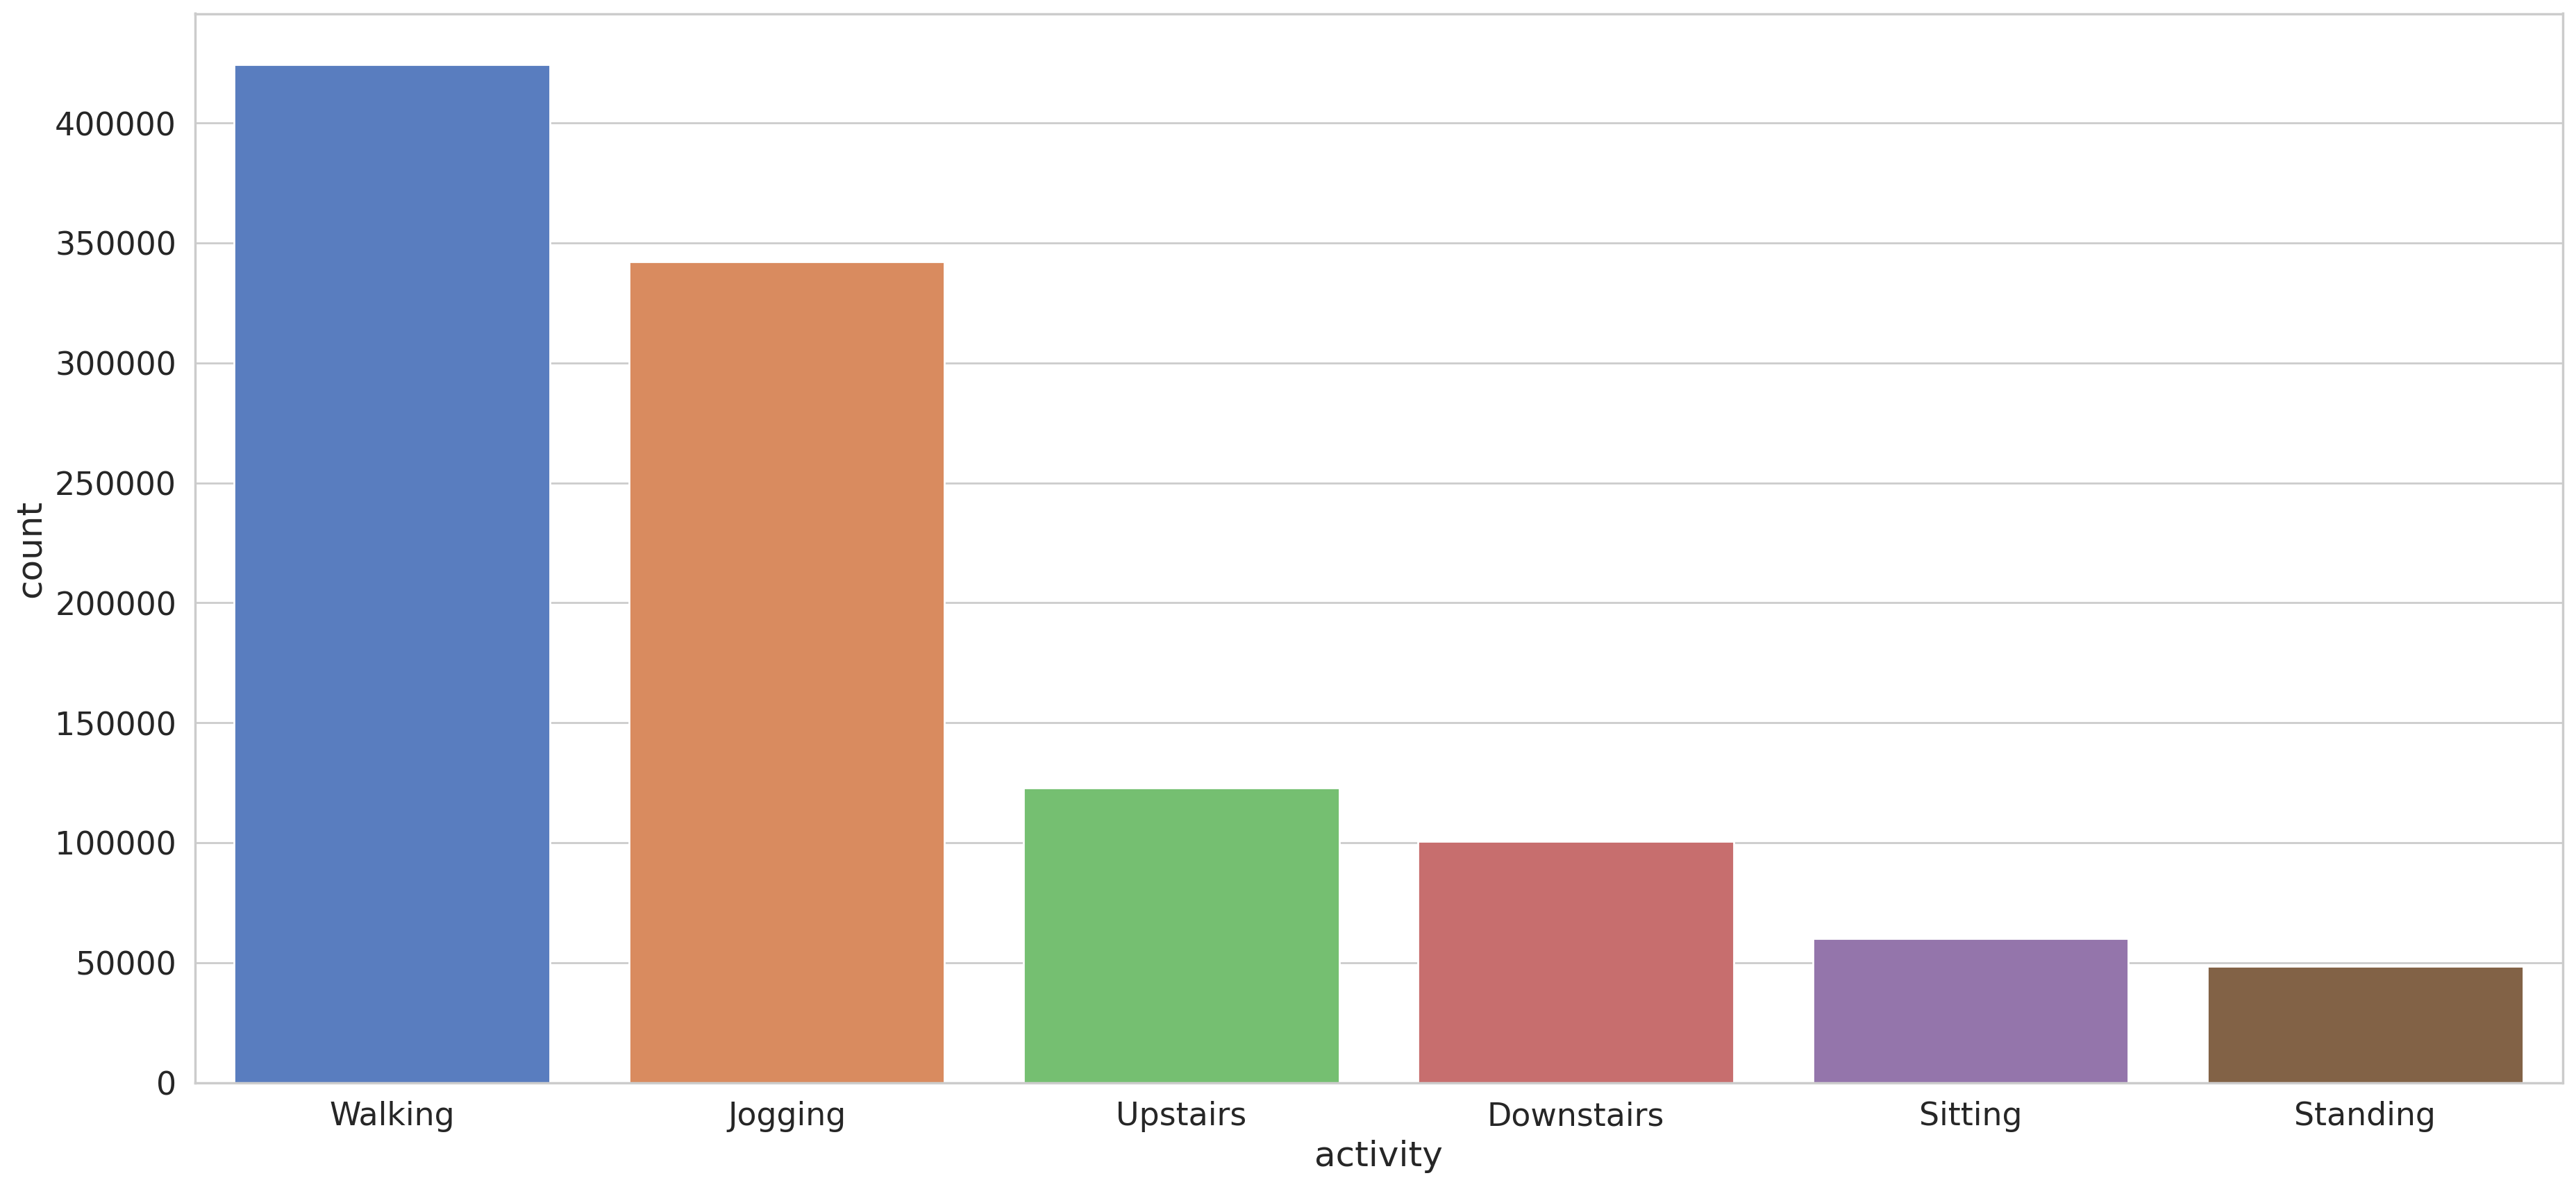

In [6]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

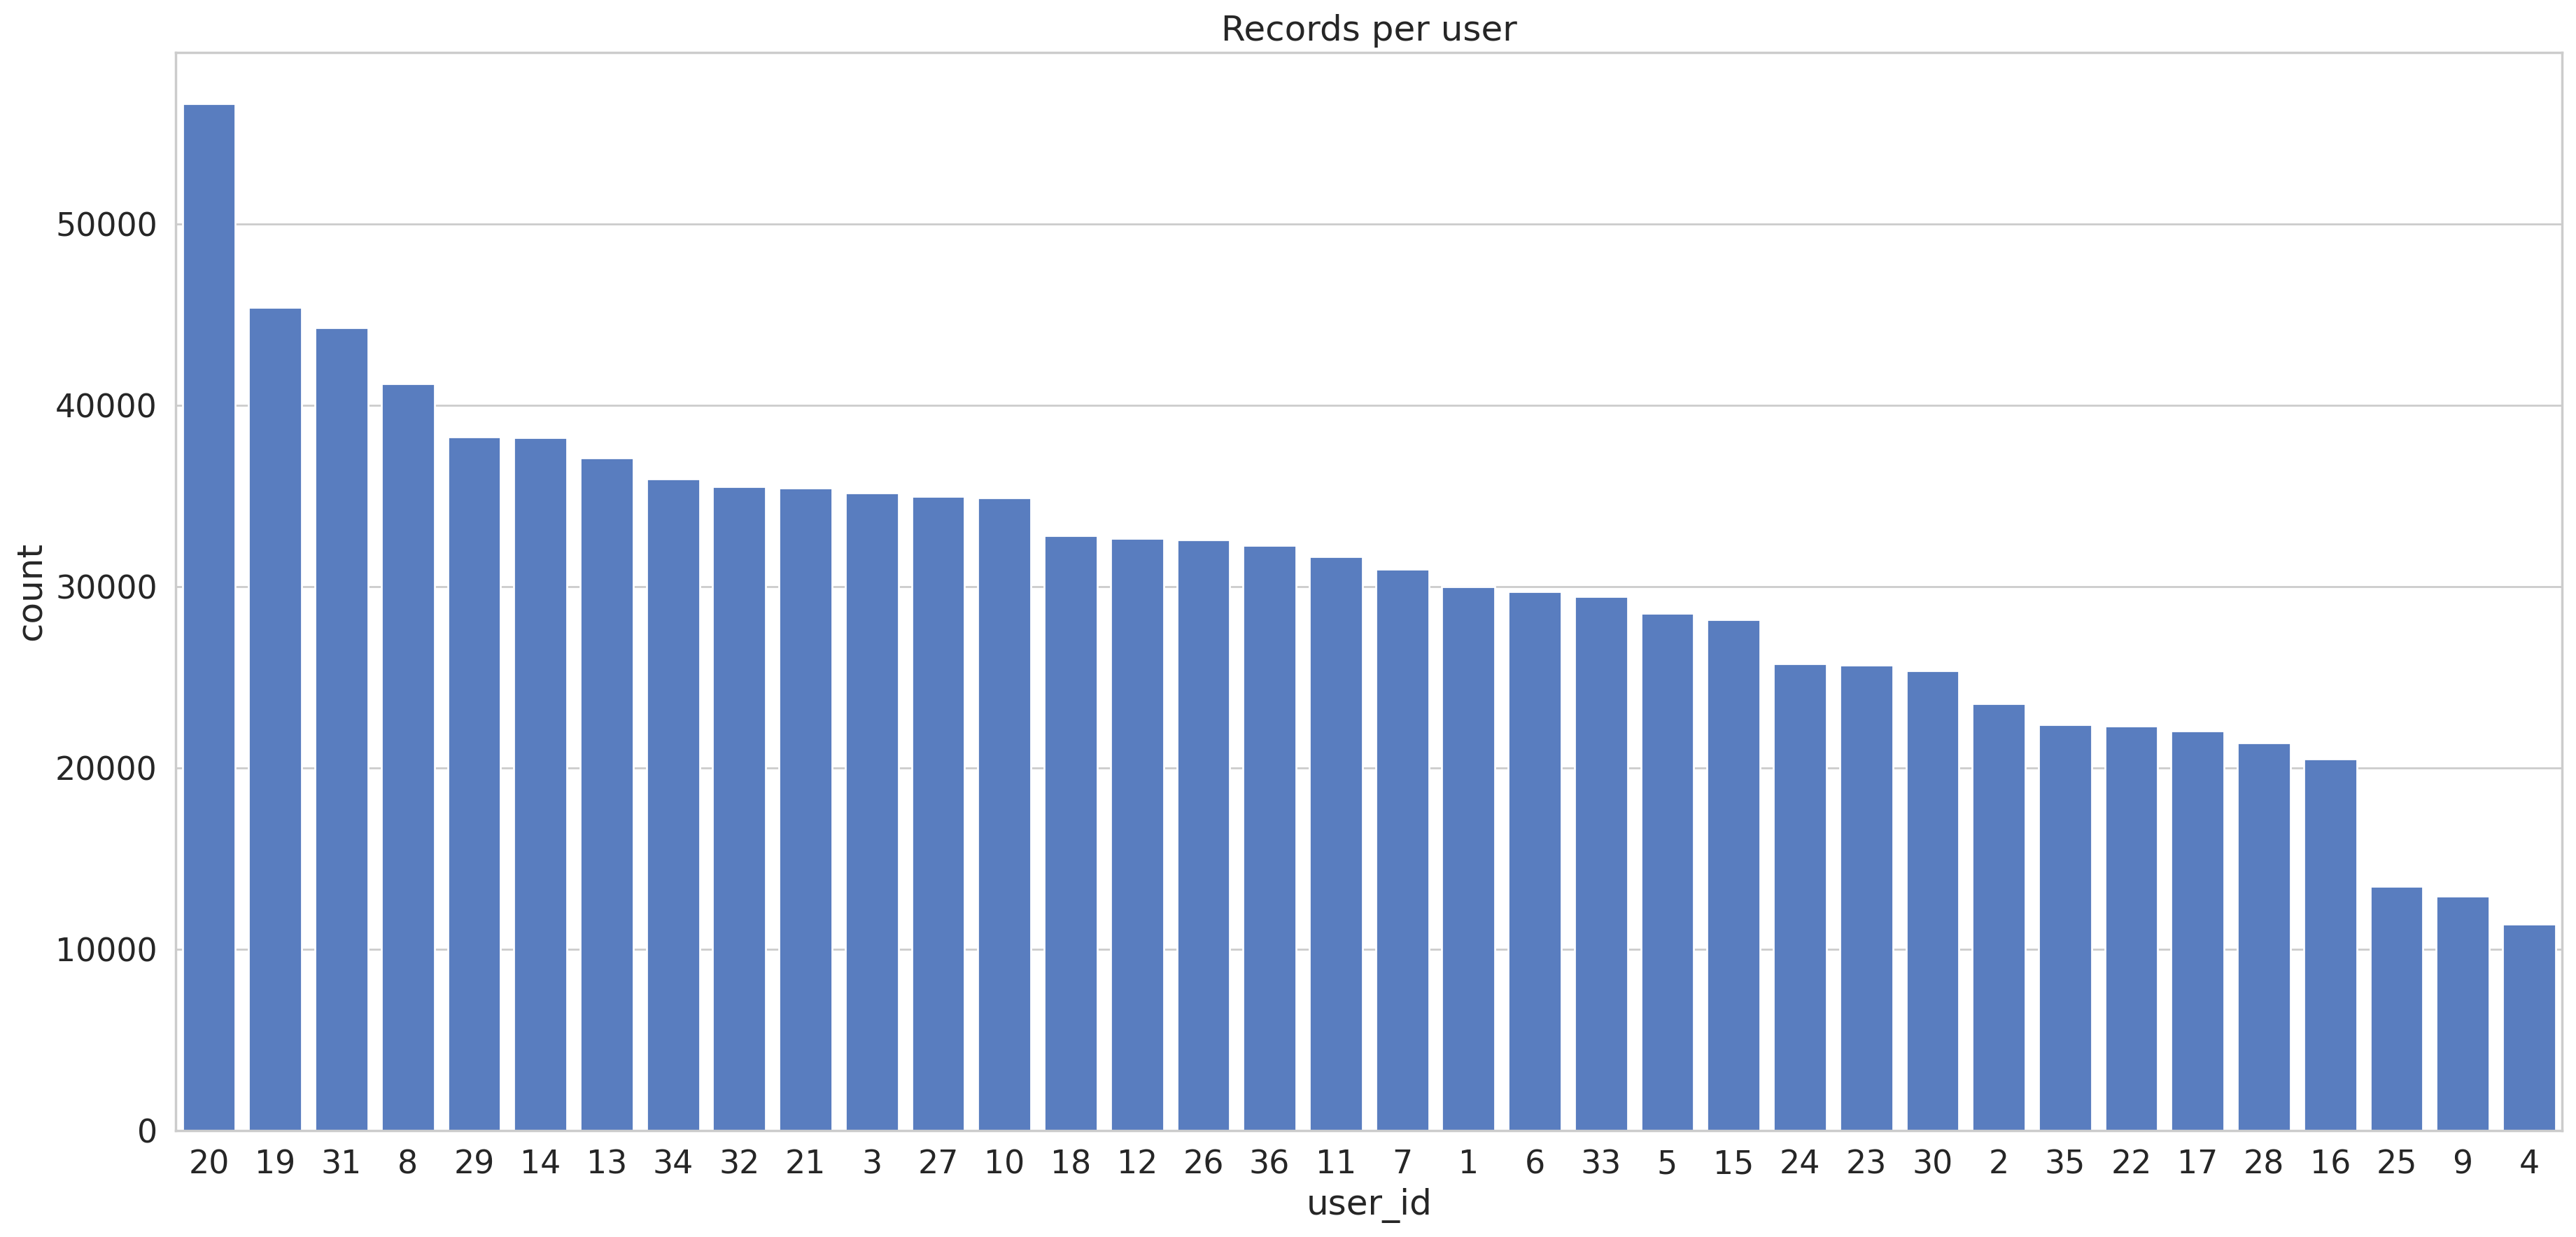

In [7]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


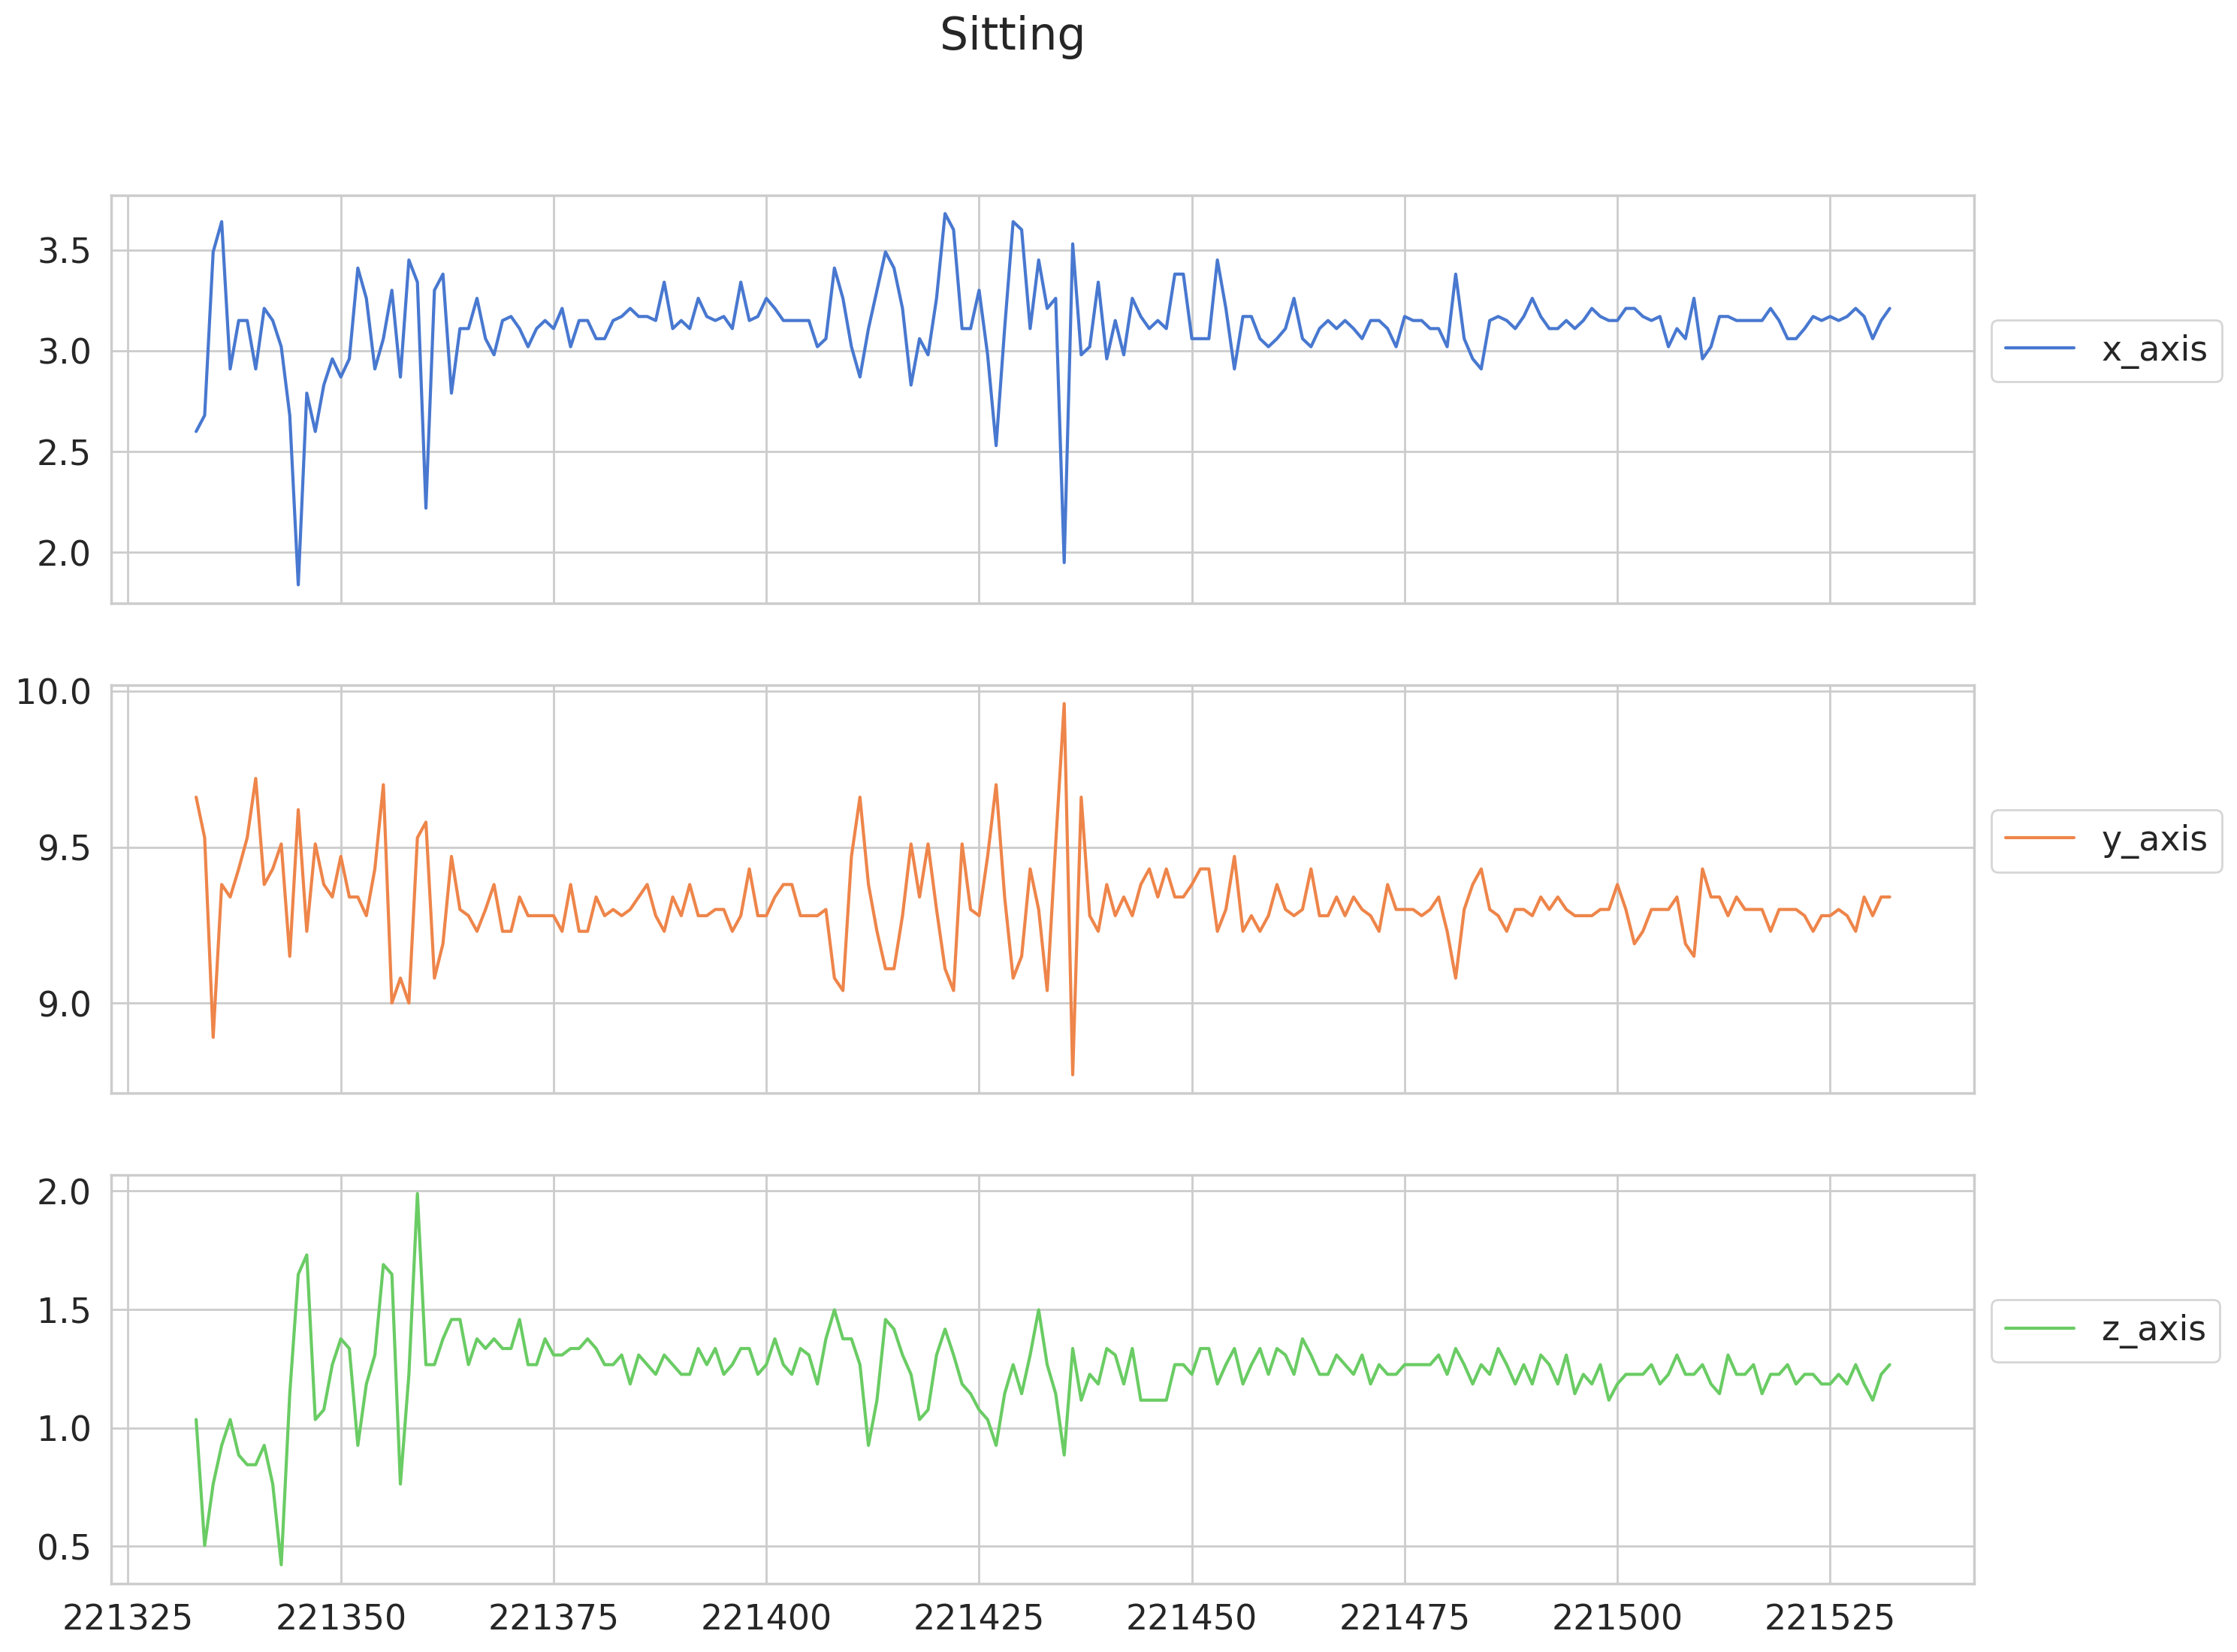

In [ ]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [ ]:
indexes = df[ (df['activity'] == 'Sitting') | (df['activity'] == 'Standing')].index
df.drop(indexes , inplace=True)

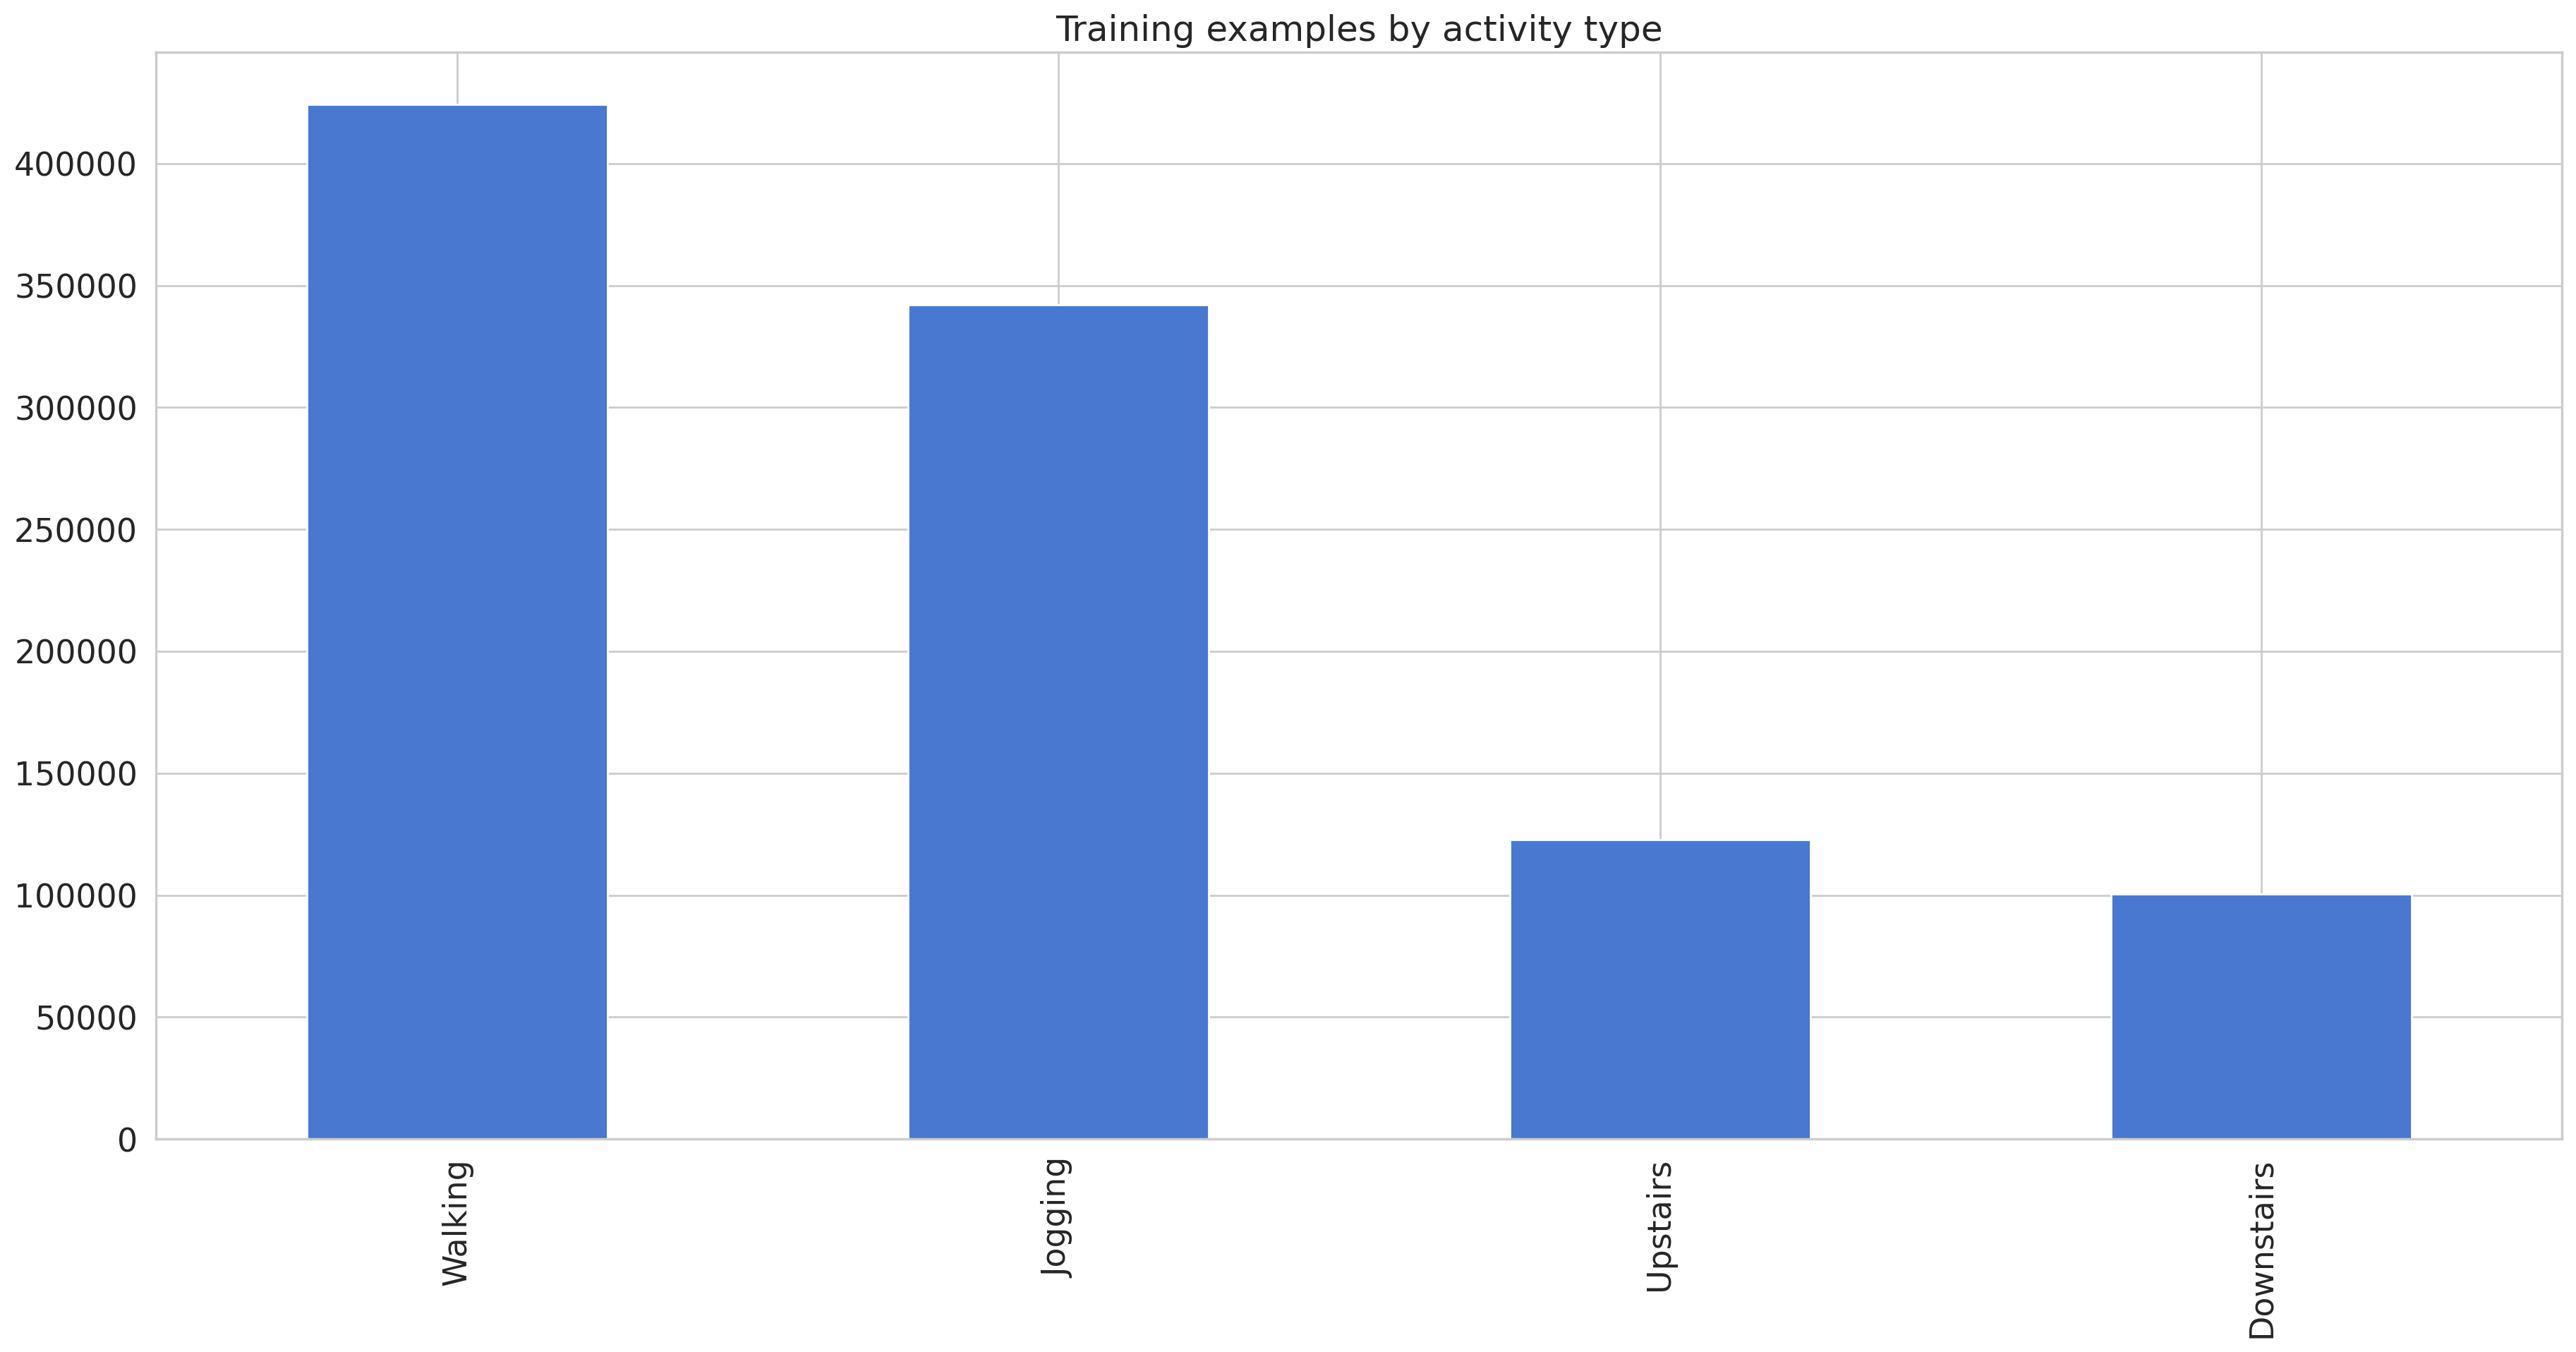

In [ ]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [ ]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


user_id    activity        timestamp    x_axis    y_axis    z_axis  \
0             33     Jogging   49105962326000 -0.139064  0.528798  0.162904   
1             33     Jogging   49106062271000  0.627996  0.365980  0.257510   
2             33     Jogging   49106112167000  0.613350  0.322145  0.039629   
3             33     Jogging   49106222305000 -0.128080  1.197291  0.693271   
4             33     Jogging   49106332290000 -0.204969  0.463045  1.573395   
...          ...         ...              ...       ...       ...       ...   
1093534       19  Downstairs  131357151521000 -0.602151 -0.017241  0.635659   
1093535       19  Downstairs  131357191438000 -0.987903  0.155172  0.248370   
1093536       19  Downstairs  131357231630000 -1.235215  0.718391  0.119975   
1093537       19  Downstairs  131357271516000 -1.065860  0.026437 -0.524103   
1093538       19  Downstairs  131357351686000 -0.977151 -0.510345 -0.103137   

         ActivityEncoded  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
...                  ...  
1093534                3  
1093535                3  
1093536                3  
1093537                3  
1093538                3  

[989870 rows x 7 columns]

In [ ]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)
X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(15834, 200, 3) (15834, 1)
(4949, 200, 3) (4949, 1)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(15834, 200, 3) (15834, 4) (4949, 200, 3) (4949, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 4)

# layer 3

# CNN 1 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           640       
                                                                 
 dropout (Dropout)           (None, 198, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 99, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 99, 100)           66000     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 94s 720ms/step - loss: 0.7224 - accuracy: 0.7354 - val_loss: 0.6092 - val_accuracy: 0.7994
Epoch 2/10
124/124 [==============================] - 86s 689ms/step - loss: 0.5157 - accuracy: 0.8102 - val_loss: 0.4161 - val_accuracy: 0.8447
Epoch 3/10
124/124 [==============================] - 86s 695ms/step - loss: 0.4448 - accuracy: 0.8303 - val_loss: 0.3439 - val_accuracy: 0.8628
Epoch 4/10
124/124 [==============================] - 86s 695ms/step - loss: 0.3725 - accuracy: 0.8540 - val_loss: 0.4041 - val_accuracy: 0.8429
Epoch 5/10
124/124 [==============================] - 87s 702ms/step - loss: 0.3404 - accuracy: 0.8624 - val_loss: 0.3829 - val_accuracy: 0.8502
Epoch 6/10
124/124 [==============================] - 87s 703ms/step - loss: 0.3198 - accuracy: 0.8695 - val_loss: 0.2818 - val_accuracy: 0.8750
Epoch 7/10
124/124 [==============================] - 85s 688ms/step - loss: 0.4065 - accuracy: 0.8504 - val_loss: 0.2983 - val_ac

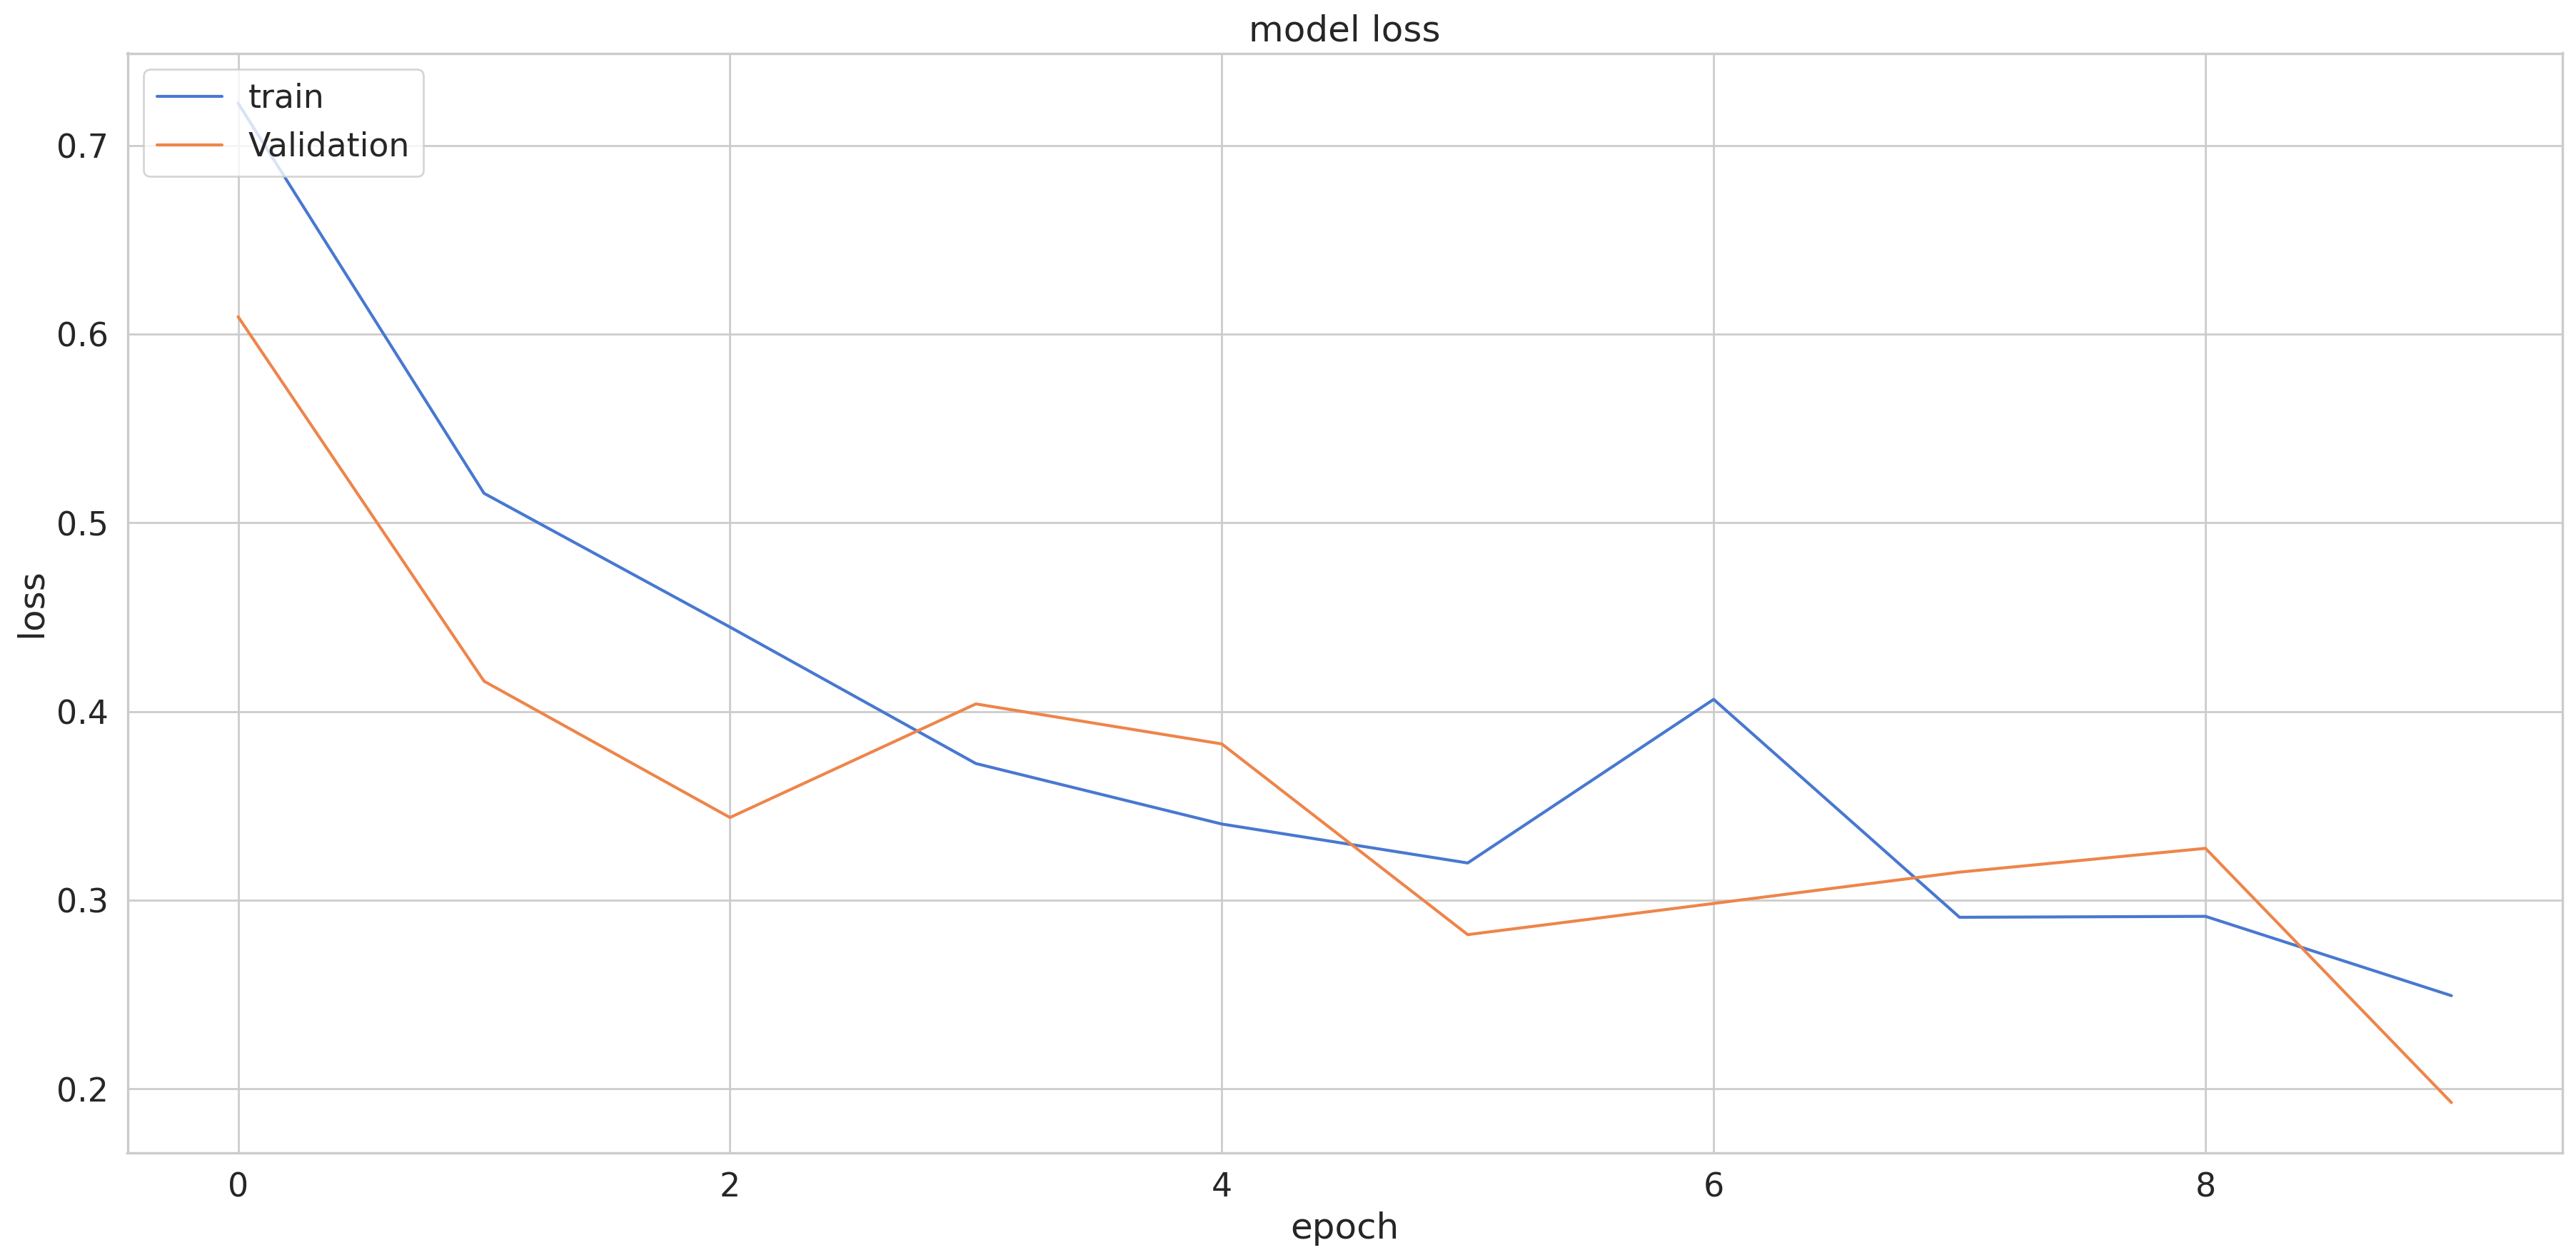

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 10s 57ms/step
f1_score =  0.923898570980751
0.9248332996564963
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2123
           1       0.97      0.99      0.98      1710
           2       0.75      0.77      0.76       615
           3       0.82      0.71      0.76       501

    accuracy                           0.92      4949
   macro avg       0.87      0.86      0.87      4949
weighted avg       0.92      0.92      0.92      4949



<Axes: >

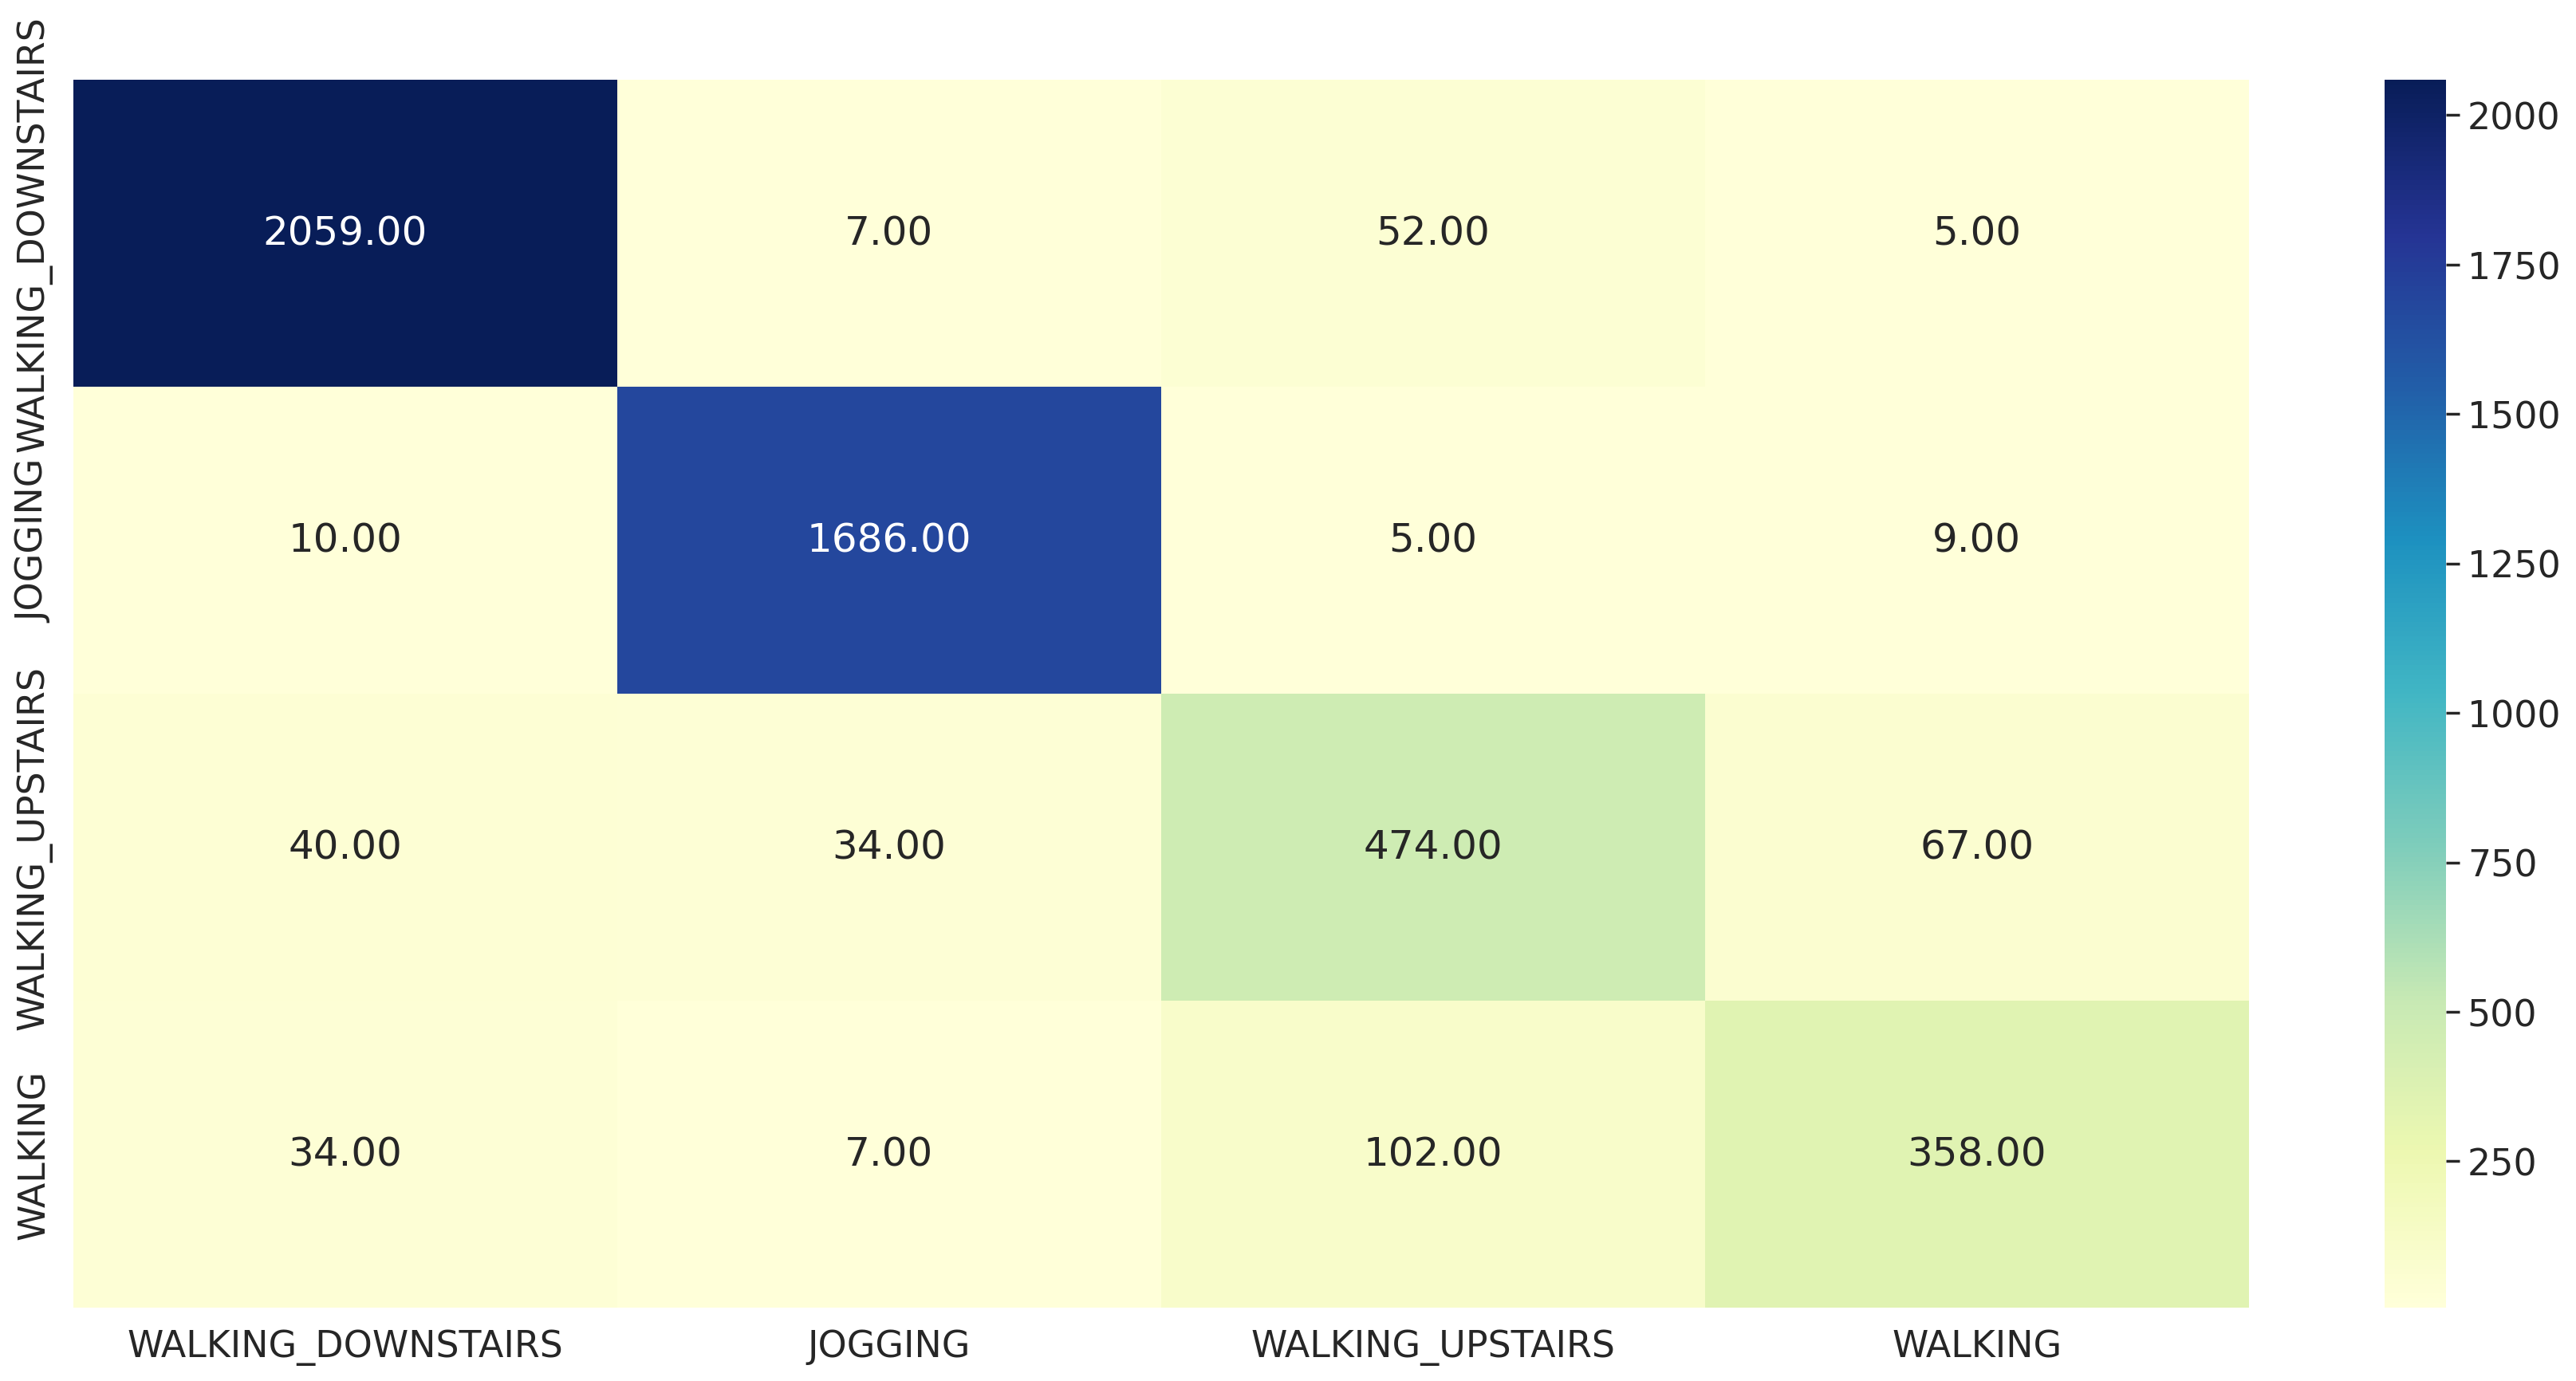

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_2 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 dropout_2 (Dropout)         (None, 196, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 98, 64)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 100)               66000     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 55s 414ms/step - loss: 0.7487 - accuracy: 0.7218 - val_loss: 0.5924 - val_accuracy: 0.7666
Epoch 2/10
124/124 [==============================] - 52s 419ms/step - loss: 0.4710 - accuracy: 0.8189 - val_loss: 0.3468 - val_accuracy: 0.8565
Epoch 3/10
124/124 [==============================] - 52s 419ms/step - loss: 0.3772 - accuracy: 0.8501 - val_loss: 0.4178 - val_accuracy: 0.8530
Epoch 4/10
124/124 [==============================] - 49s 399ms/step - loss: 0.3284 - accuracy: 0.8686 - val_loss: 0.2700 - val_accuracy: 0.8906
Epoch 5/10
124/124 [==============================] - 50s 401ms/step - loss: 0.2792 - accuracy: 0.8866 - val_loss: 0.2169 - val_accuracy: 0.9065
Epoch 6/10
124/124 [==============================] - 48s 386ms/step - loss: 0.2274 - accuracy: 0.9026 - val_loss: 0.2128 - val_accuracy: 0.9151
Epoch 7/10
124/124 [==============================] - 48s 386ms/step - loss: 0.2122 - accuracy: 0.9163 - val_loss: 0.1979 - val_ac

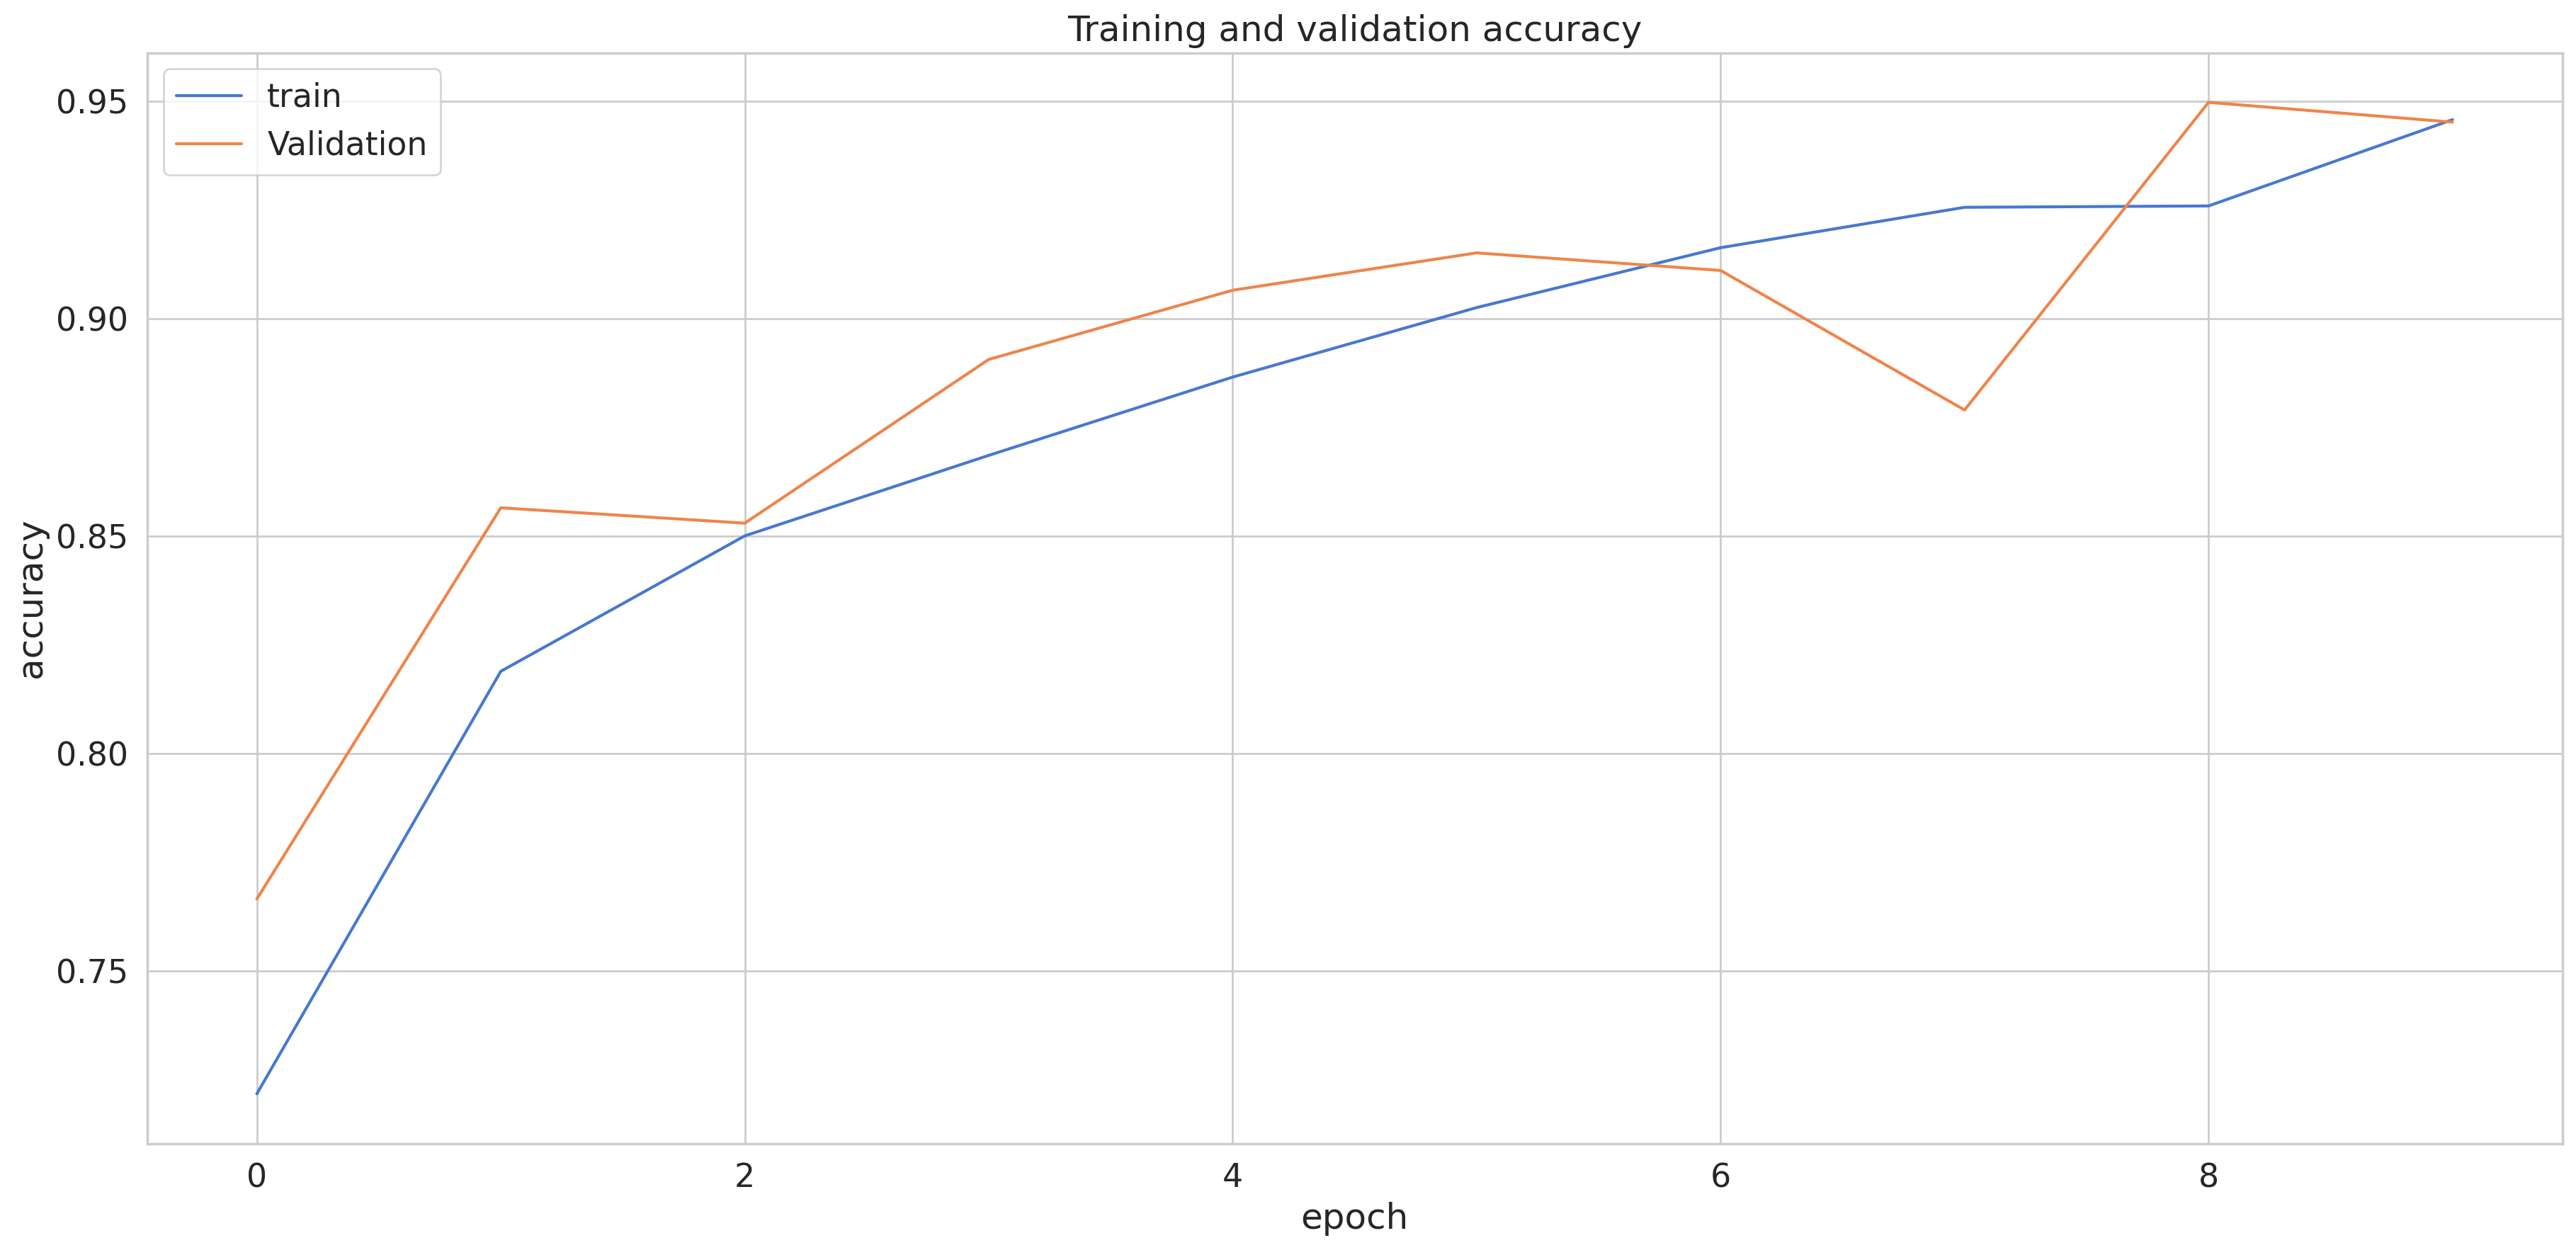

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

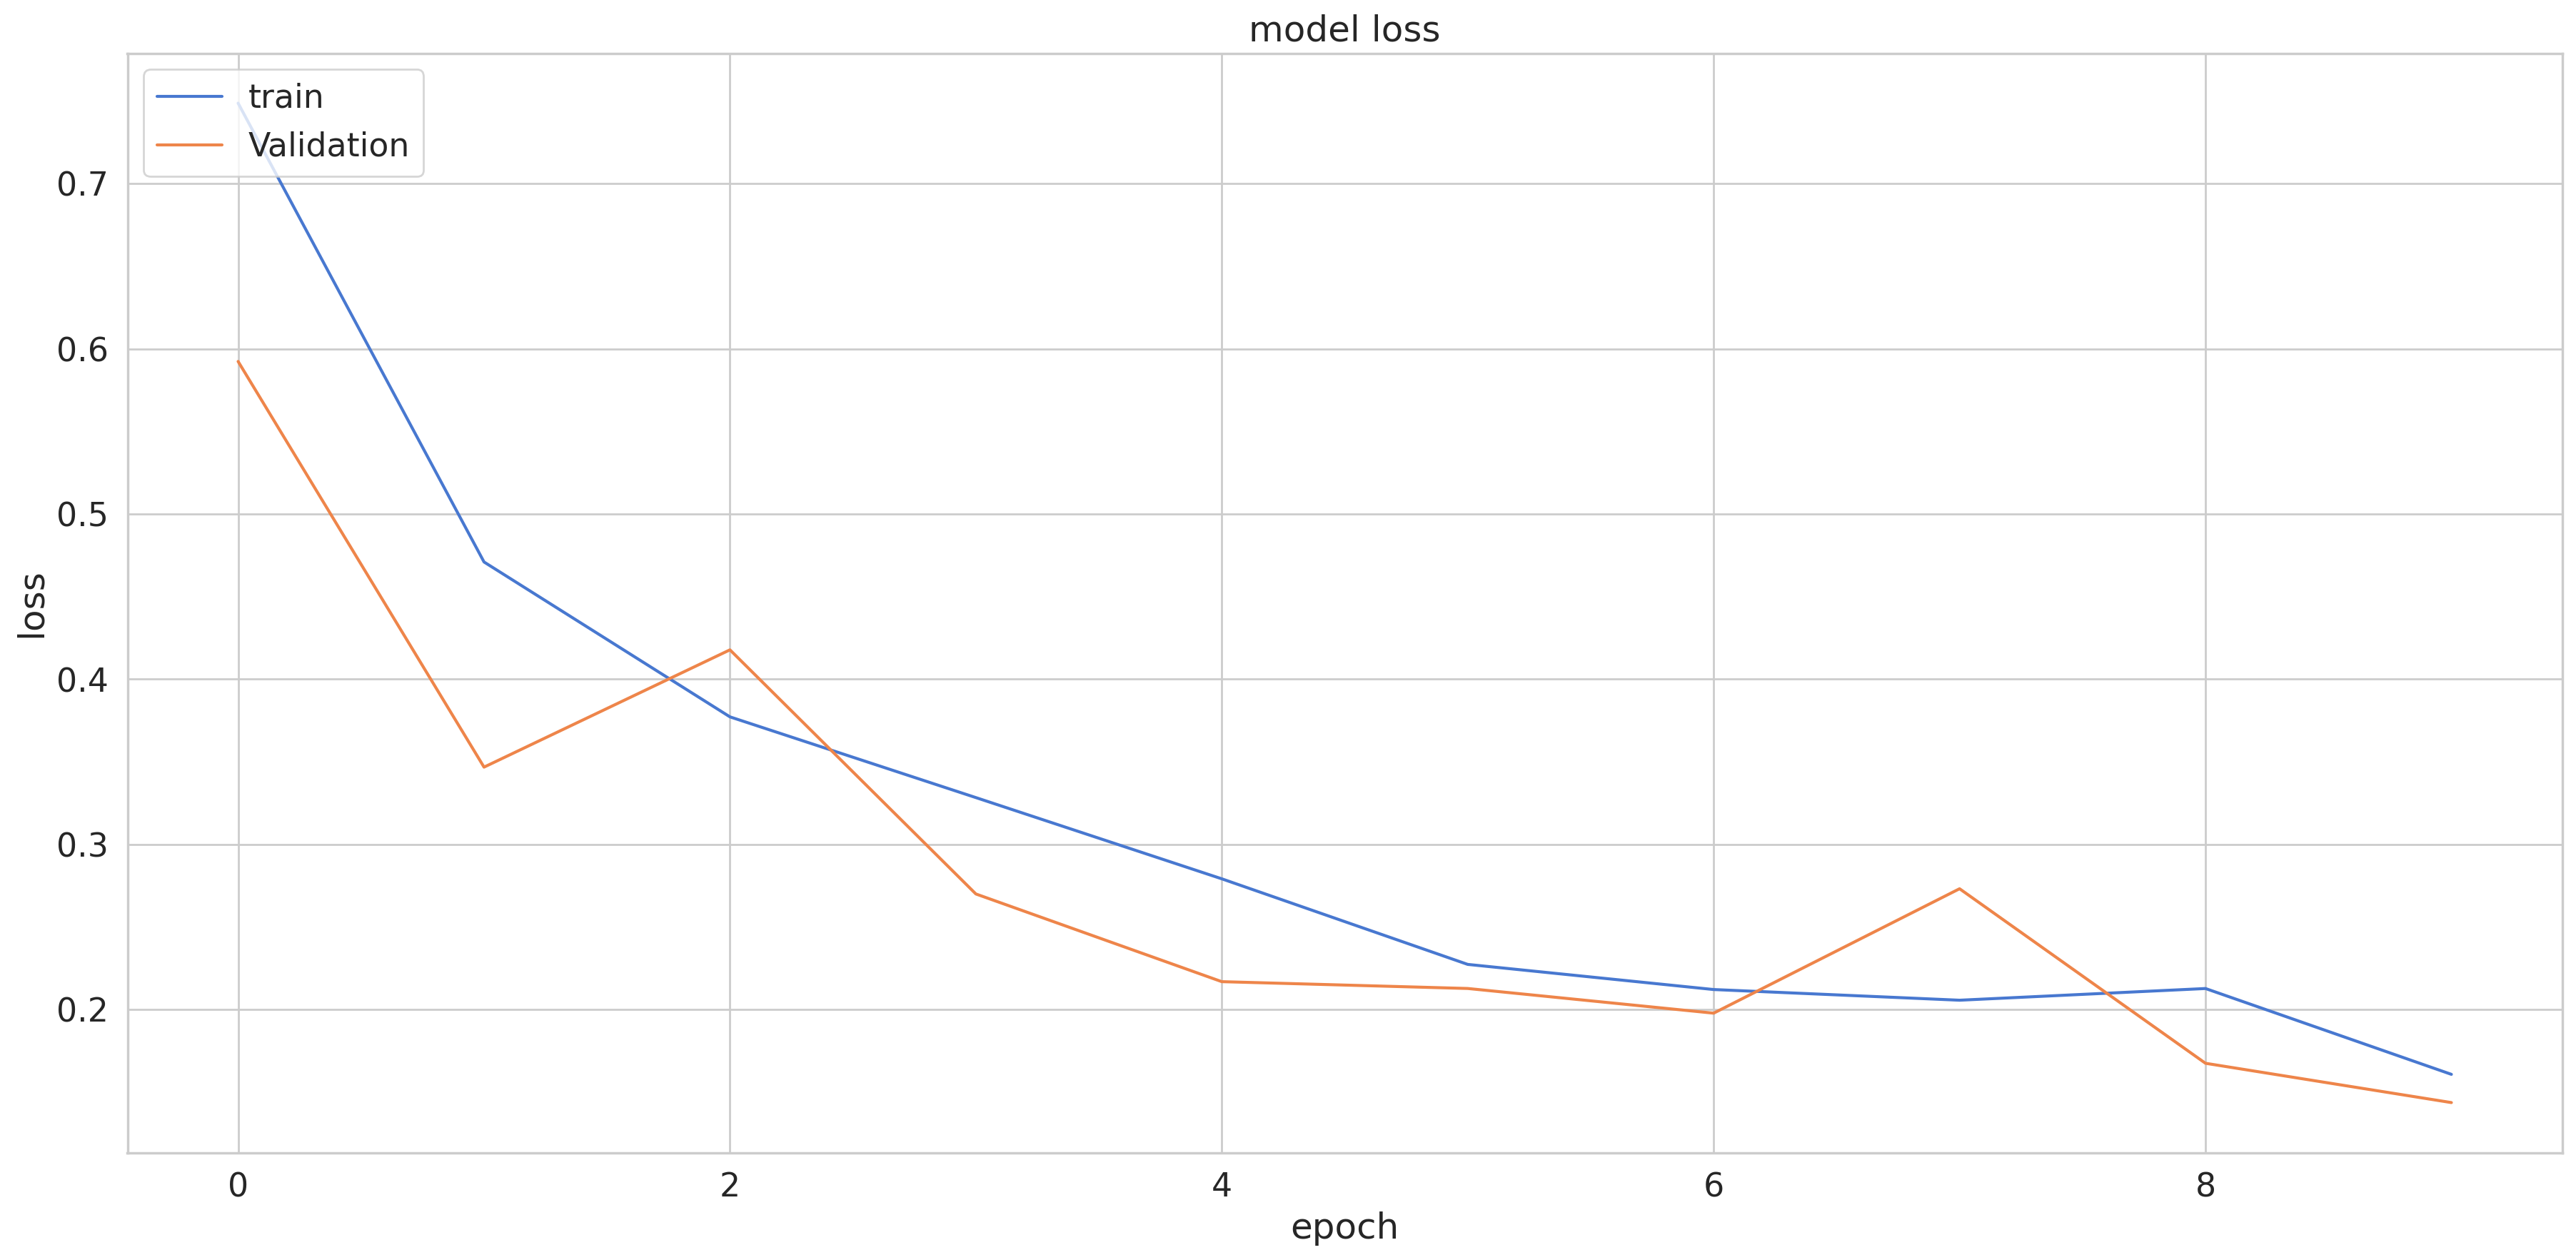

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 7s 41ms/step
f1_score =  0.935866310514164
0.9369569610022227
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.70      0.94      0.80       615
           3       0.90      0.58      0.71       501

    accuracy                           0.94      4949
   macro avg       0.90      0.87      0.87      4949
weighted avg       0.95      0.94      0.94      4949



<Axes: >

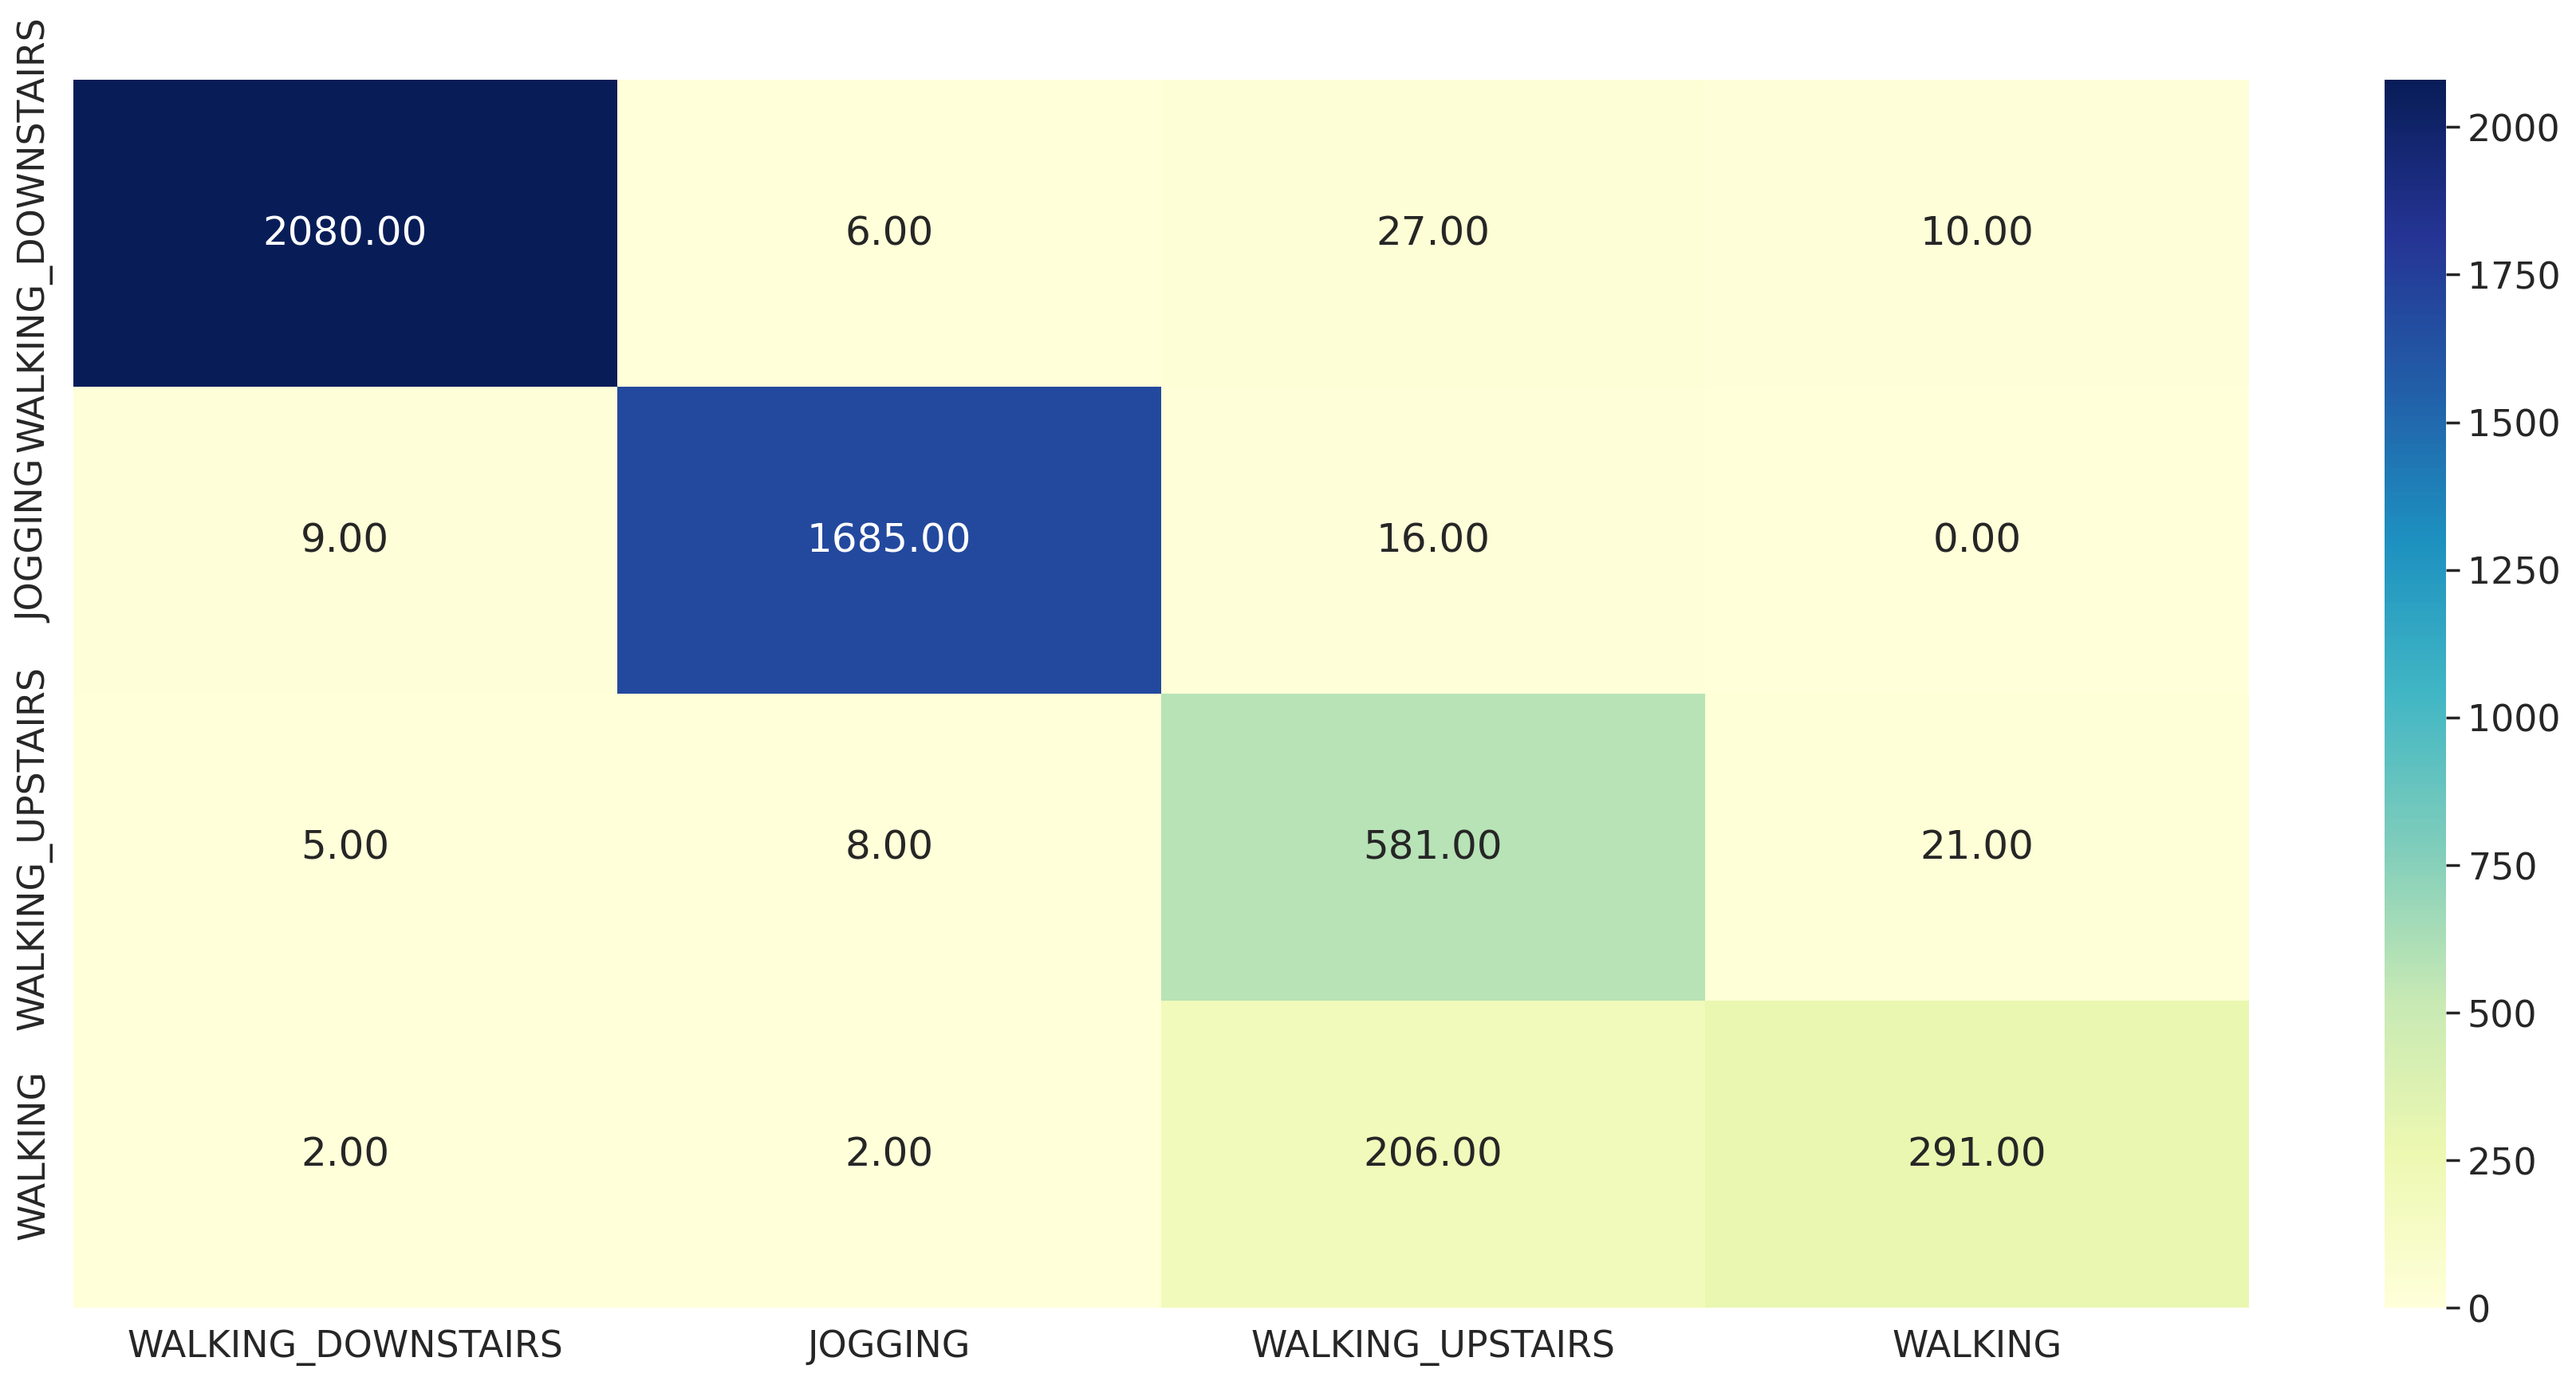

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# layer 4

# CNN1 - LSTM3

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 198, 64)           640       
                                                                 
 dropout_4 (Dropout)         (None, 198, 64)           0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 99, 64)            0         
 g1D)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 99, 100)           66000     
                                                                 
 lstm_4 (LSTM)               (None, 99, 100)           80400     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 132s 1s/step - loss: 0.7008 - accuracy: 0.7385 - val_loss: 0.5272 - val_accuracy: 0.7972
Epoch 2/10
124/124 [==============================] - 137s 1s/step - loss: 0.4805 - accuracy: 0.8221 - val_loss: 0.4400 - val_accuracy: 0.8328
Epoch 3/10
124/124 [==============================] - 125s 1s/step - loss: 0.4032 - accuracy: 0.8458 - val_loss: 0.3316 - val_accuracy: 0.8616
Epoch 4/10
124/124 [==============================] - 125s 1s/step - loss: 0.3588 - accuracy: 0.8585 - val_loss: 0.3159 - val_accuracy: 0.8669
Epoch 5/10
124/124 [==============================] - 126s 1s/step - loss: 0.3466 - accuracy: 0.8620 - val_loss: 0.2881 - val_accuracy: 0.8828
Epoch 6/10
124/124 [==============================] - 122s 981ms/step - loss: 0.3182 - accuracy: 0.8756 - val_loss: 0.3656 - val_accuracy: 0.8596
Epoch 7/10
124/124 [==============================] - 125s 1s/step - loss: 0.2744 - accuracy: 0.8926 - val_loss: 0.2622 - val_accuracy: 0.9

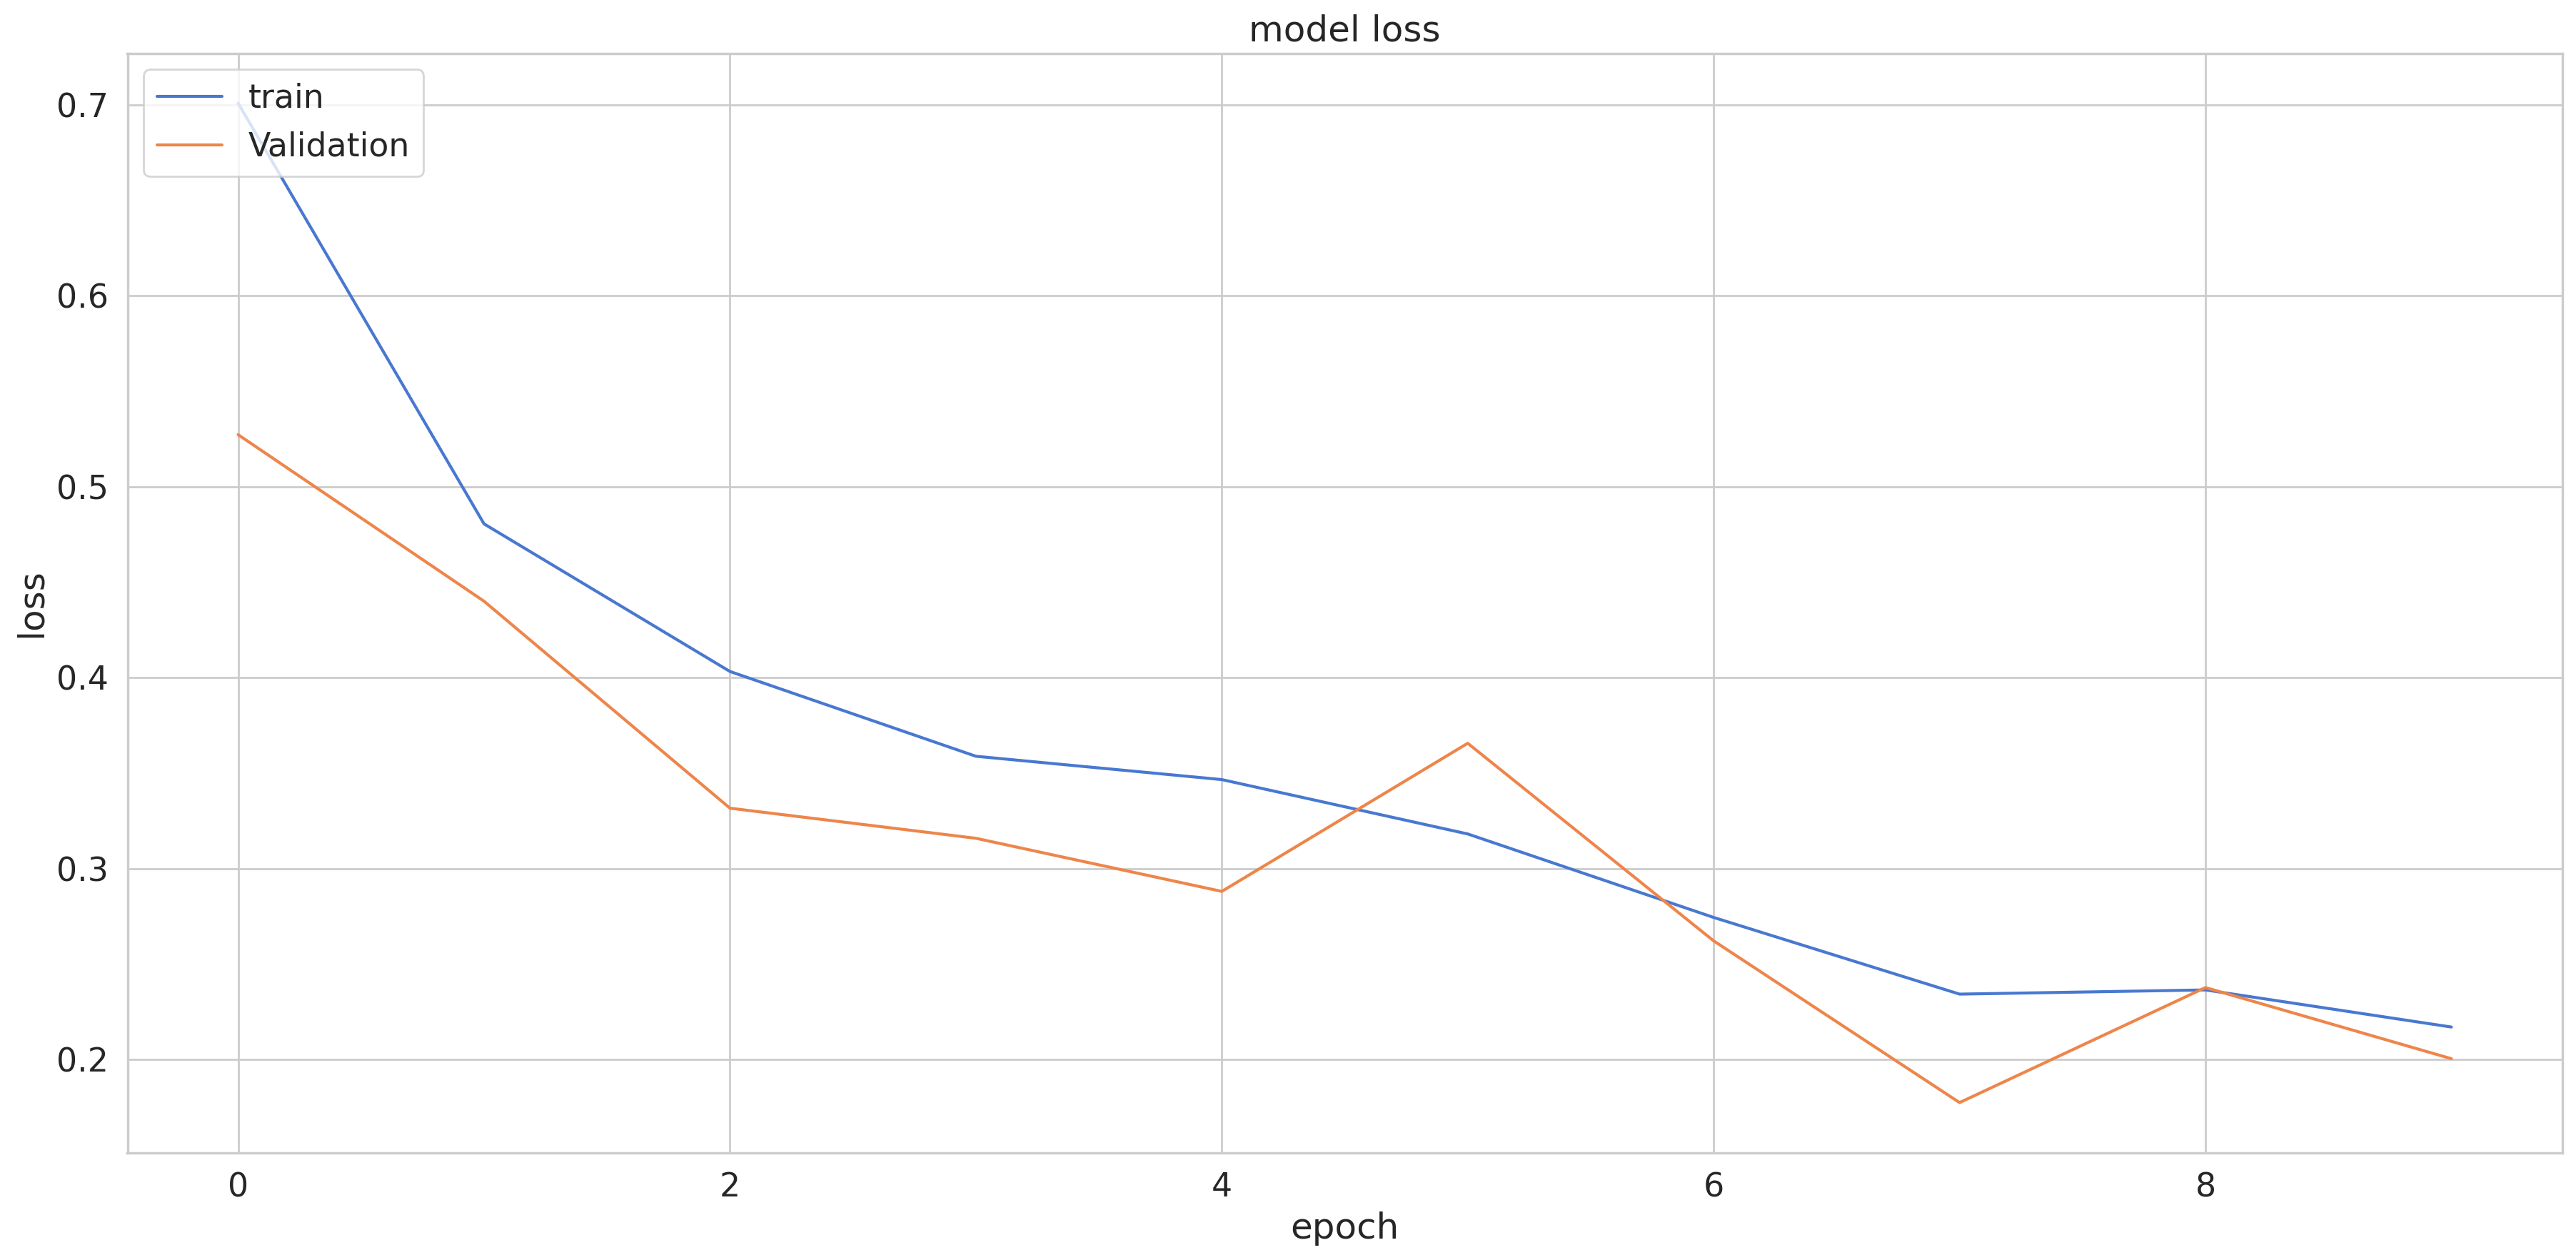

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

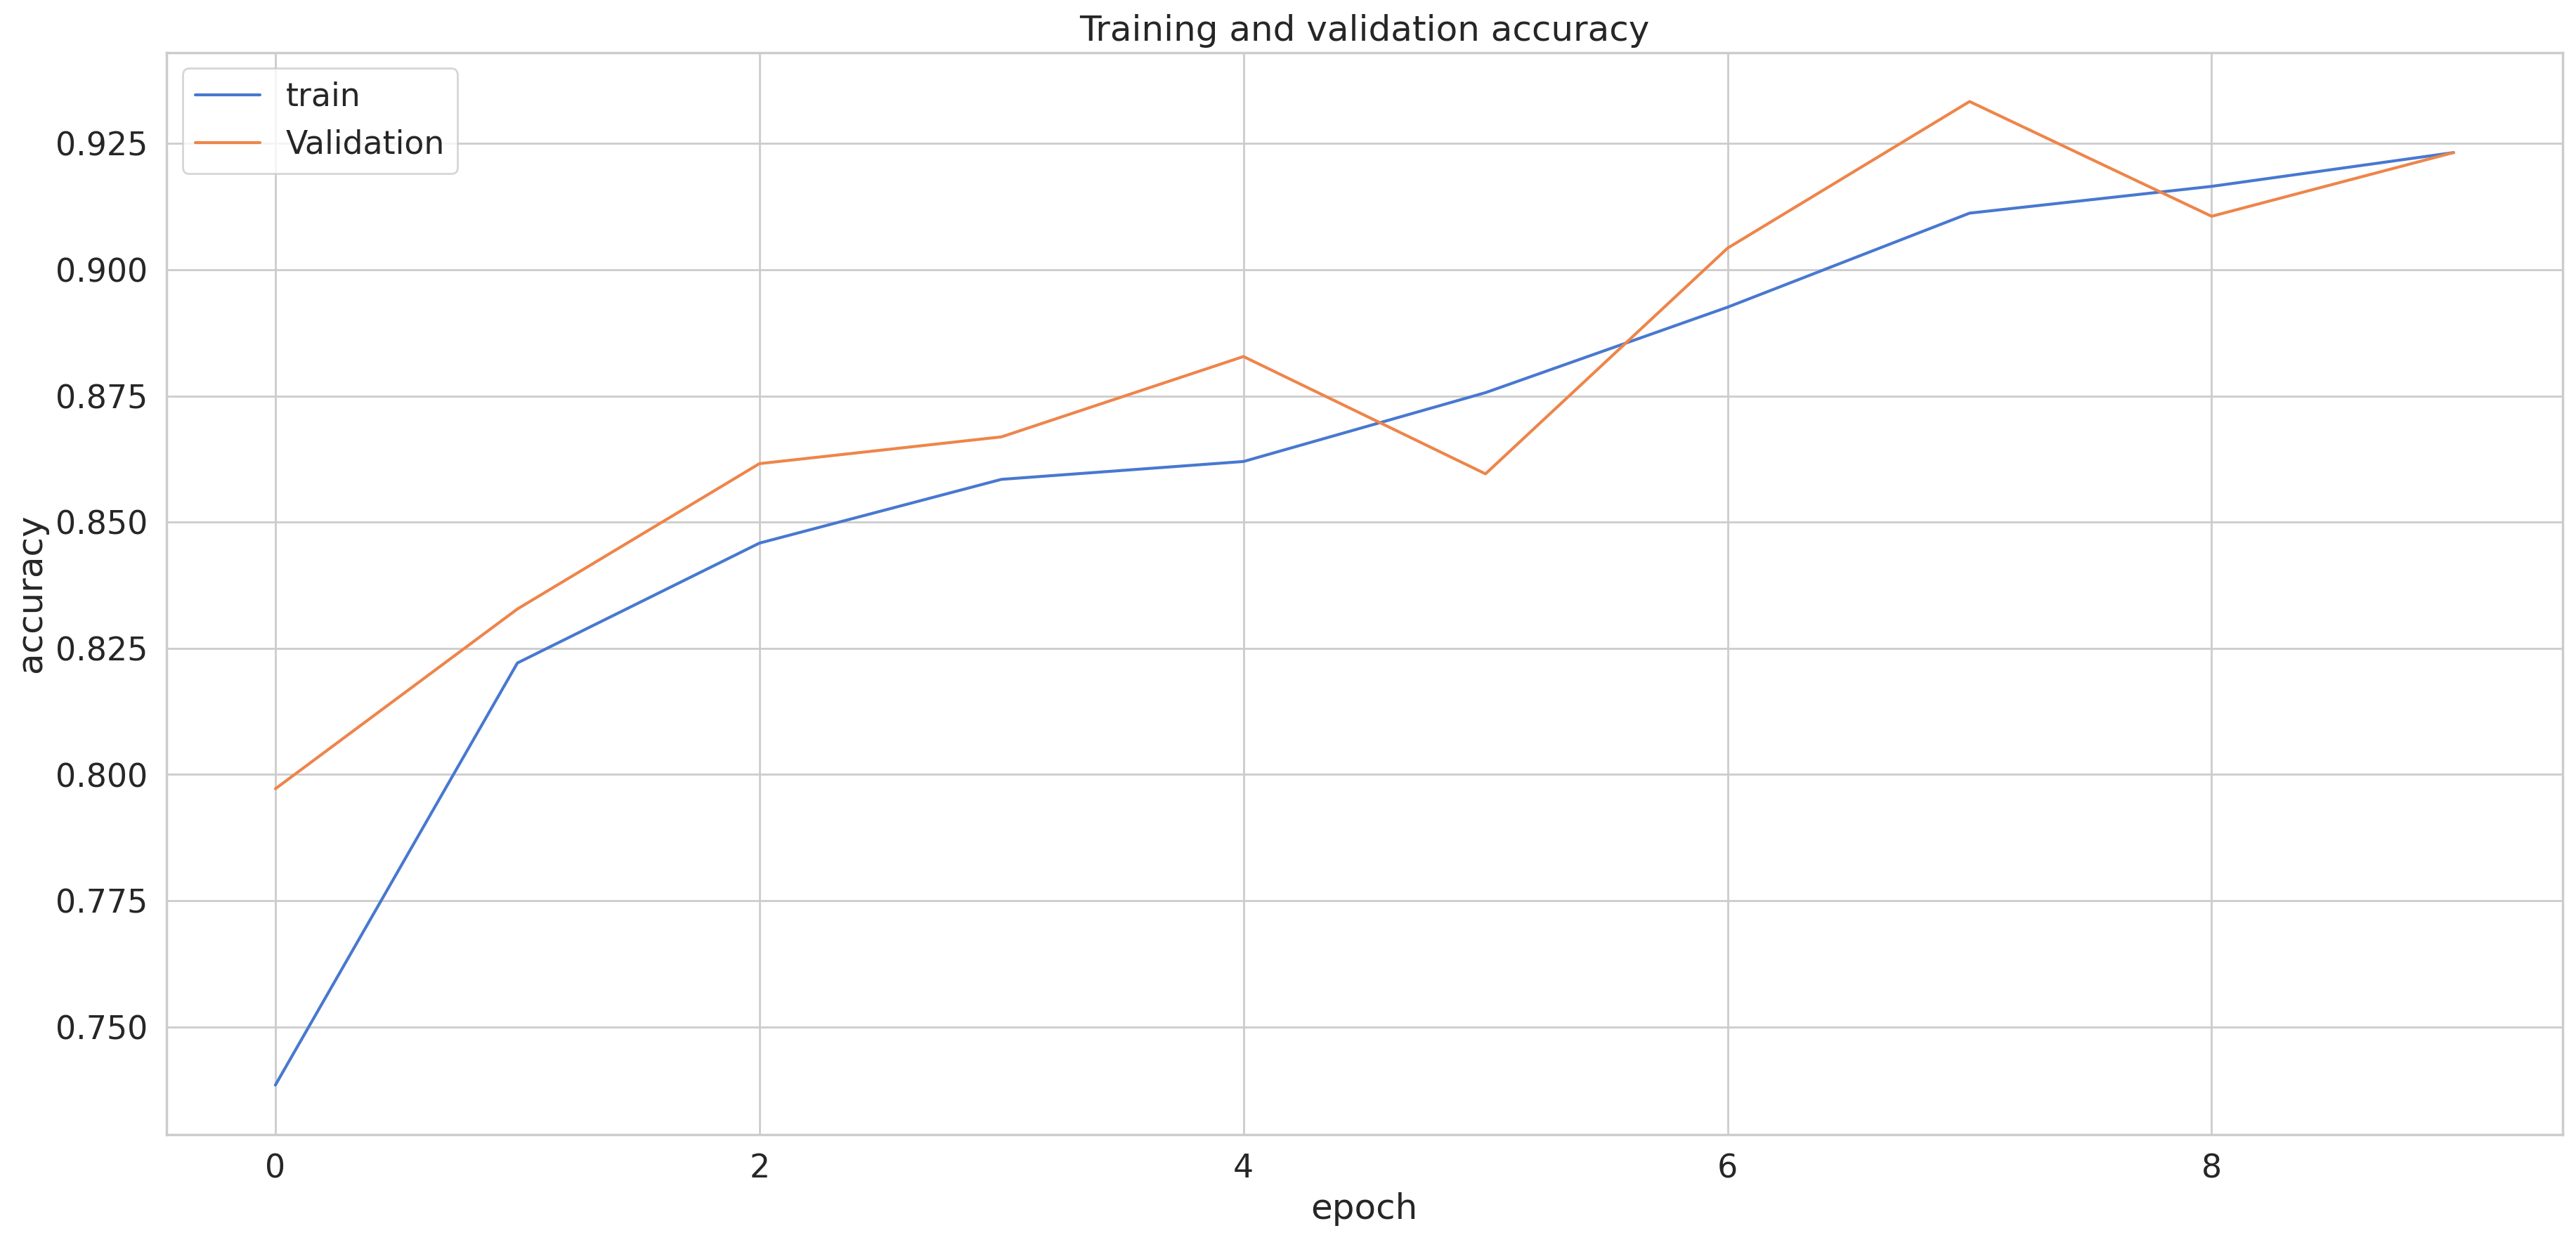

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 15s 91ms/step
f1_score =  0.9275779096346708
0.9272580319256415
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2123
           1       0.99      0.96      0.98      1710
           2       0.76      0.77      0.77       615
           3       0.78      0.79      0.78       501

    accuracy                           0.93      4949
   macro avg       0.87      0.87      0.87      4949
weighted avg       0.93      0.93      0.93      4949



<Axes: >

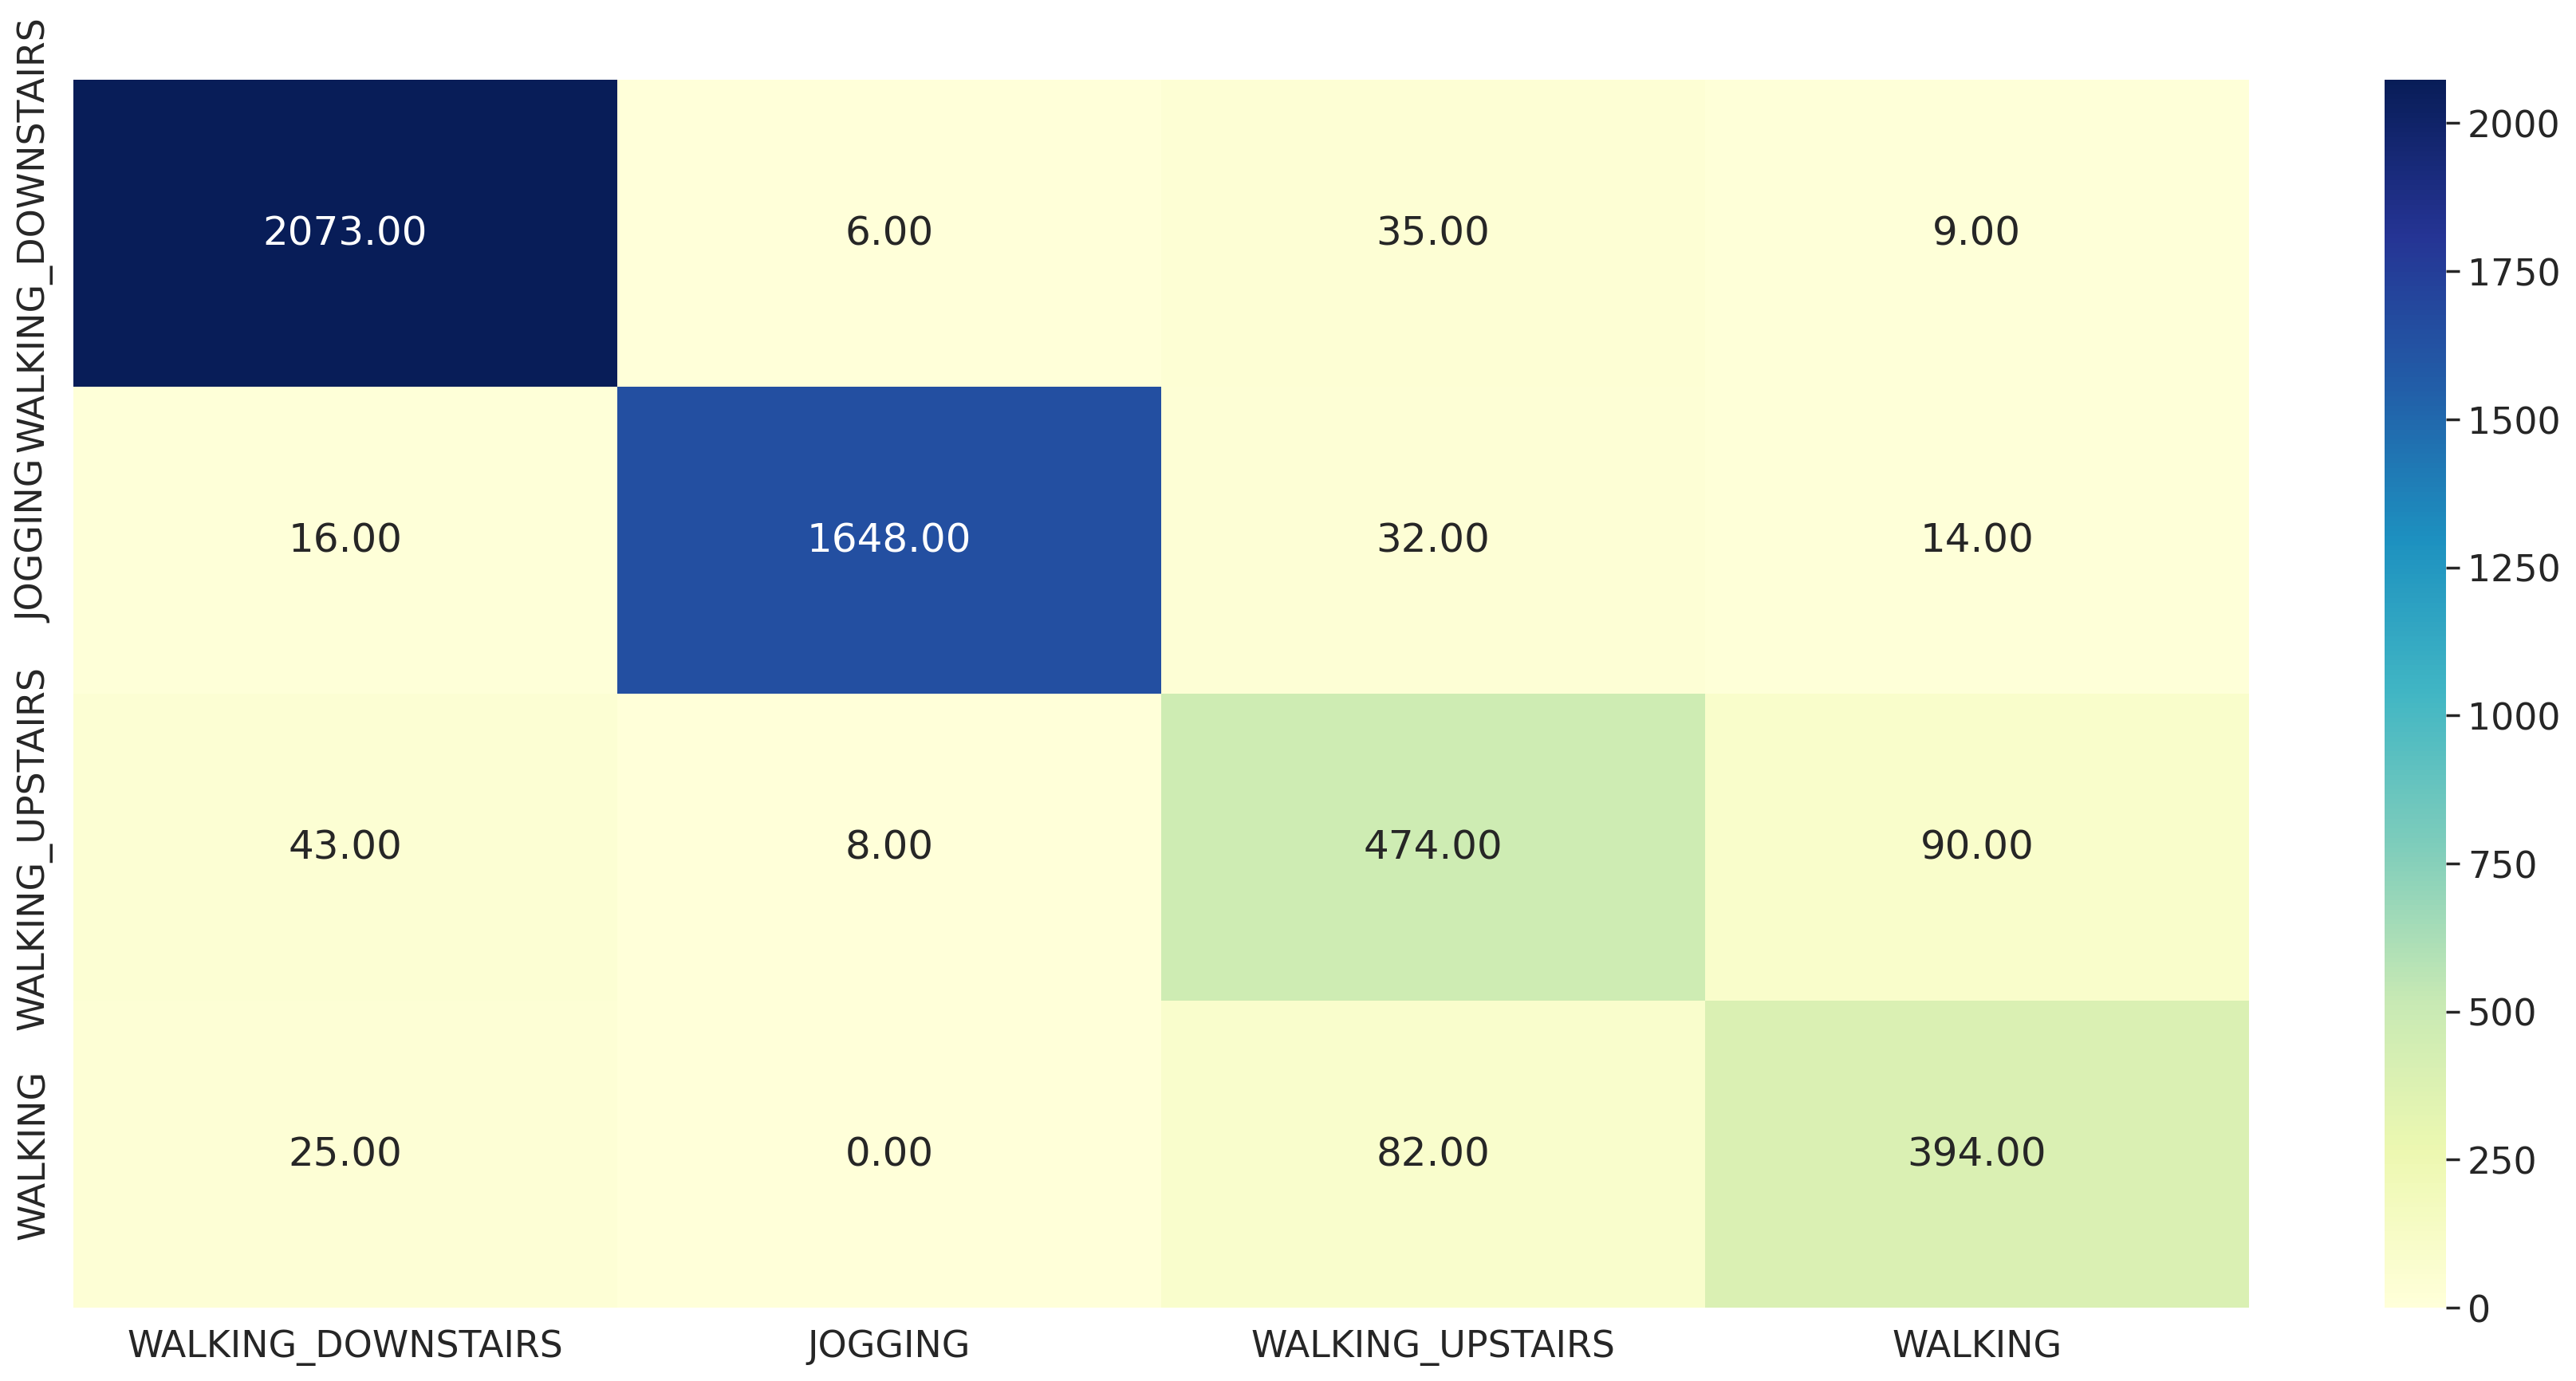

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 -LSTM2

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_5 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 dropout_6 (Dropout)         (None, 196, 64)           0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 98, 64)            0         
 g1D)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 98, 100)           66000     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 99s 741ms/step - loss: 0.7438 - accuracy: 0.7239 - val_loss: 0.5459 - val_accuracy: 0.7772
Epoch 2/10
124/124 [==============================] - 94s 756ms/step - loss: 0.5185 - accuracy: 0.8090 - val_loss: 0.4514 - val_accuracy: 0.8325
Epoch 3/10
124/124 [==============================] - 94s 756ms/step - loss: 0.3973 - accuracy: 0.8431 - val_loss: 0.6097 - val_accuracy: 0.7939
Epoch 4/10
124/124 [==============================] - 95s 769ms/step - loss: 0.3726 - accuracy: 0.8511 - val_loss: 0.2981 - val_accuracy: 0.8767
Epoch 5/10
124/124 [==============================] - 94s 757ms/step - loss: 0.2787 - accuracy: 0.8807 - val_loss: 0.2320 - val_accuracy: 0.9048
Epoch 6/10
124/124 [==============================] - 92s 743ms/step - loss: 0.2815 - accuracy: 0.8832 - val_loss: 0.2789 - val_accuracy: 0.8873
Epoch 7/10
124/124 [==============================] - 91s 734ms/step - loss: 0.2313 - accuracy: 0.9058 - val_loss: 0.2018 - val_ac

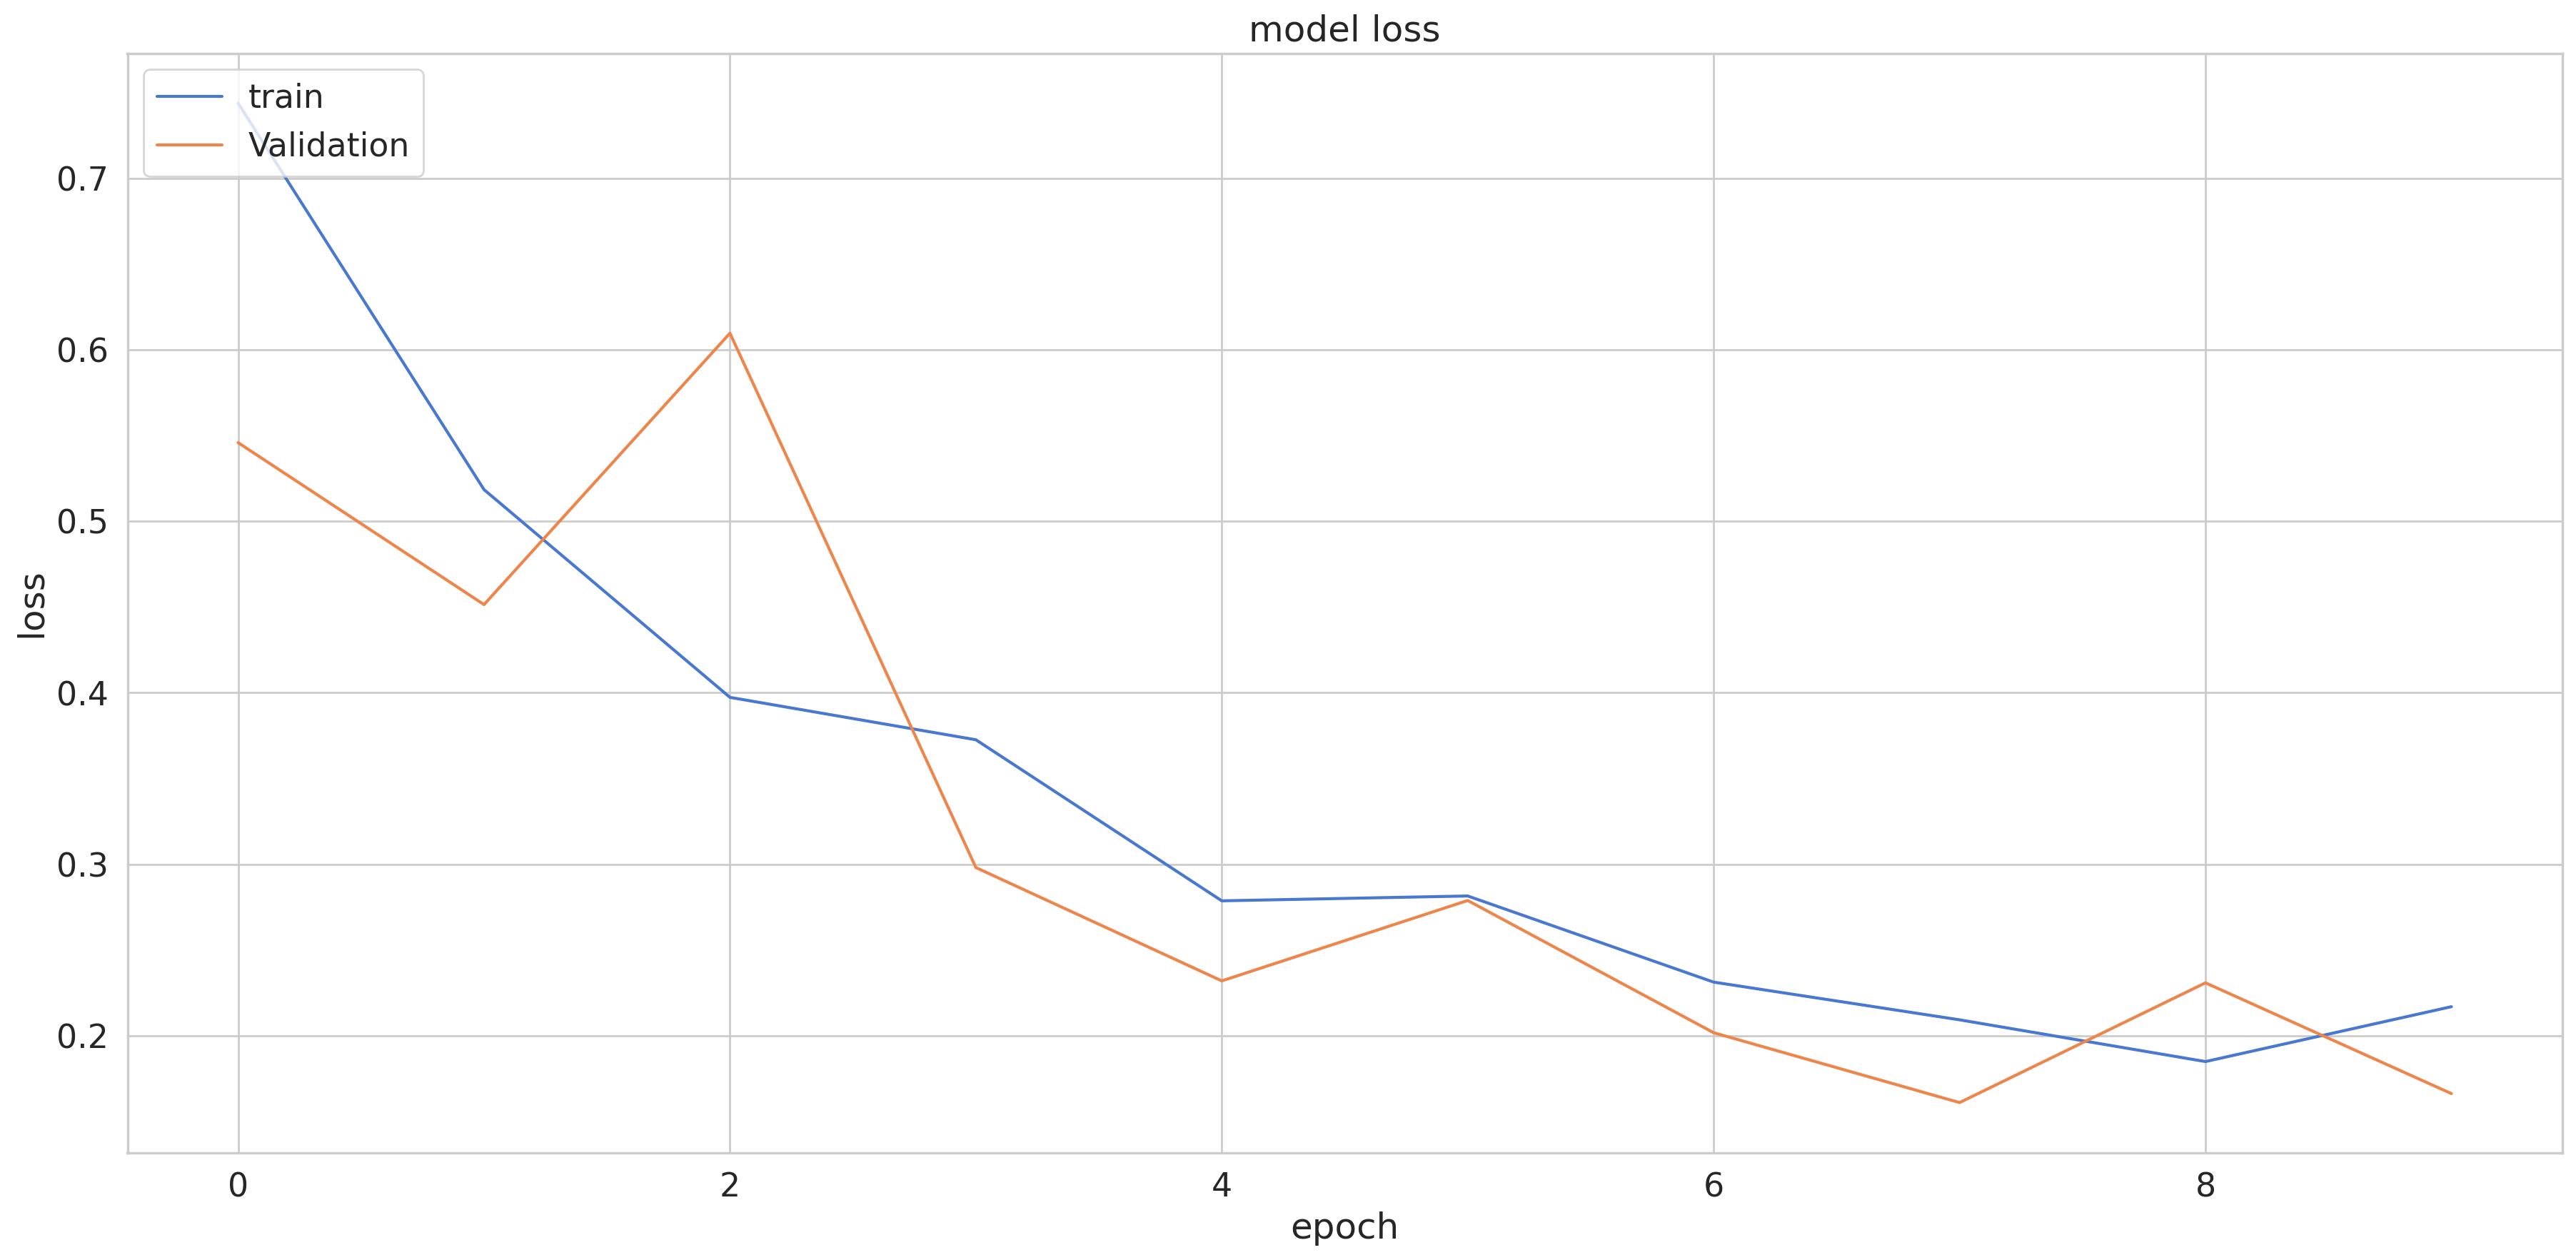

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

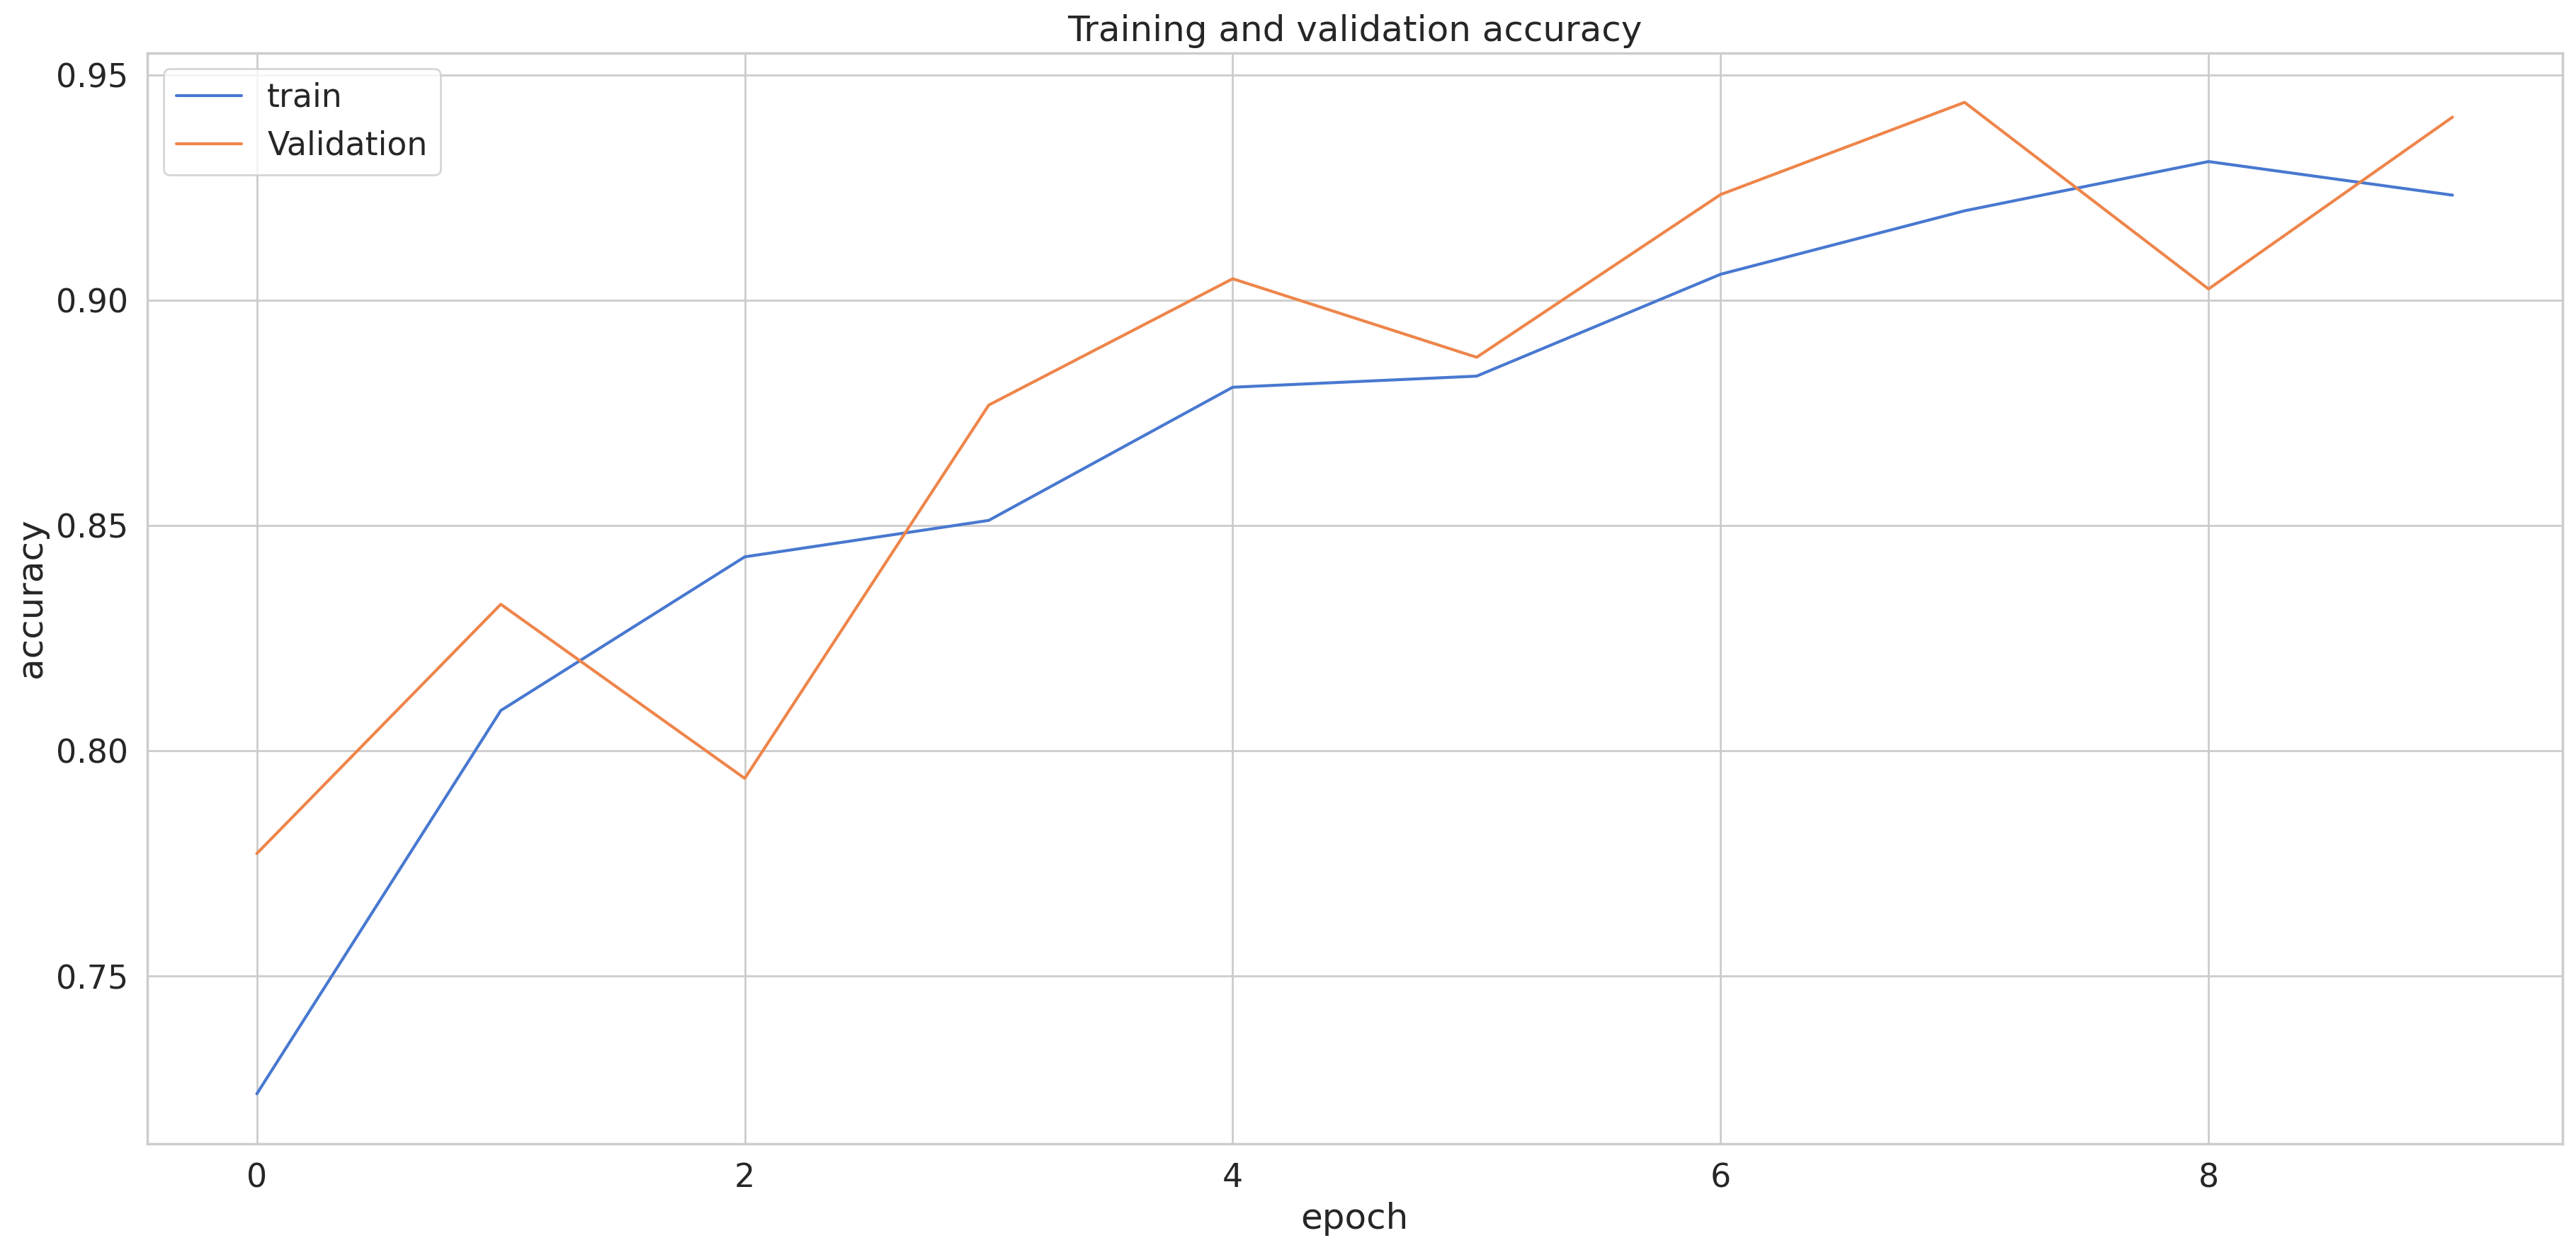

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 10s 60ms/step
f1_score =  0.9404040646712655
0.9391796322489392
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2123
           1       0.98      0.99      0.98      1710
           2       0.73      0.88      0.80       615
           3       0.86      0.76      0.81       501

    accuracy                           0.94      4949
   macro avg       0.89      0.90      0.89      4949
weighted avg       0.94      0.94      0.94      4949



<Axes: >

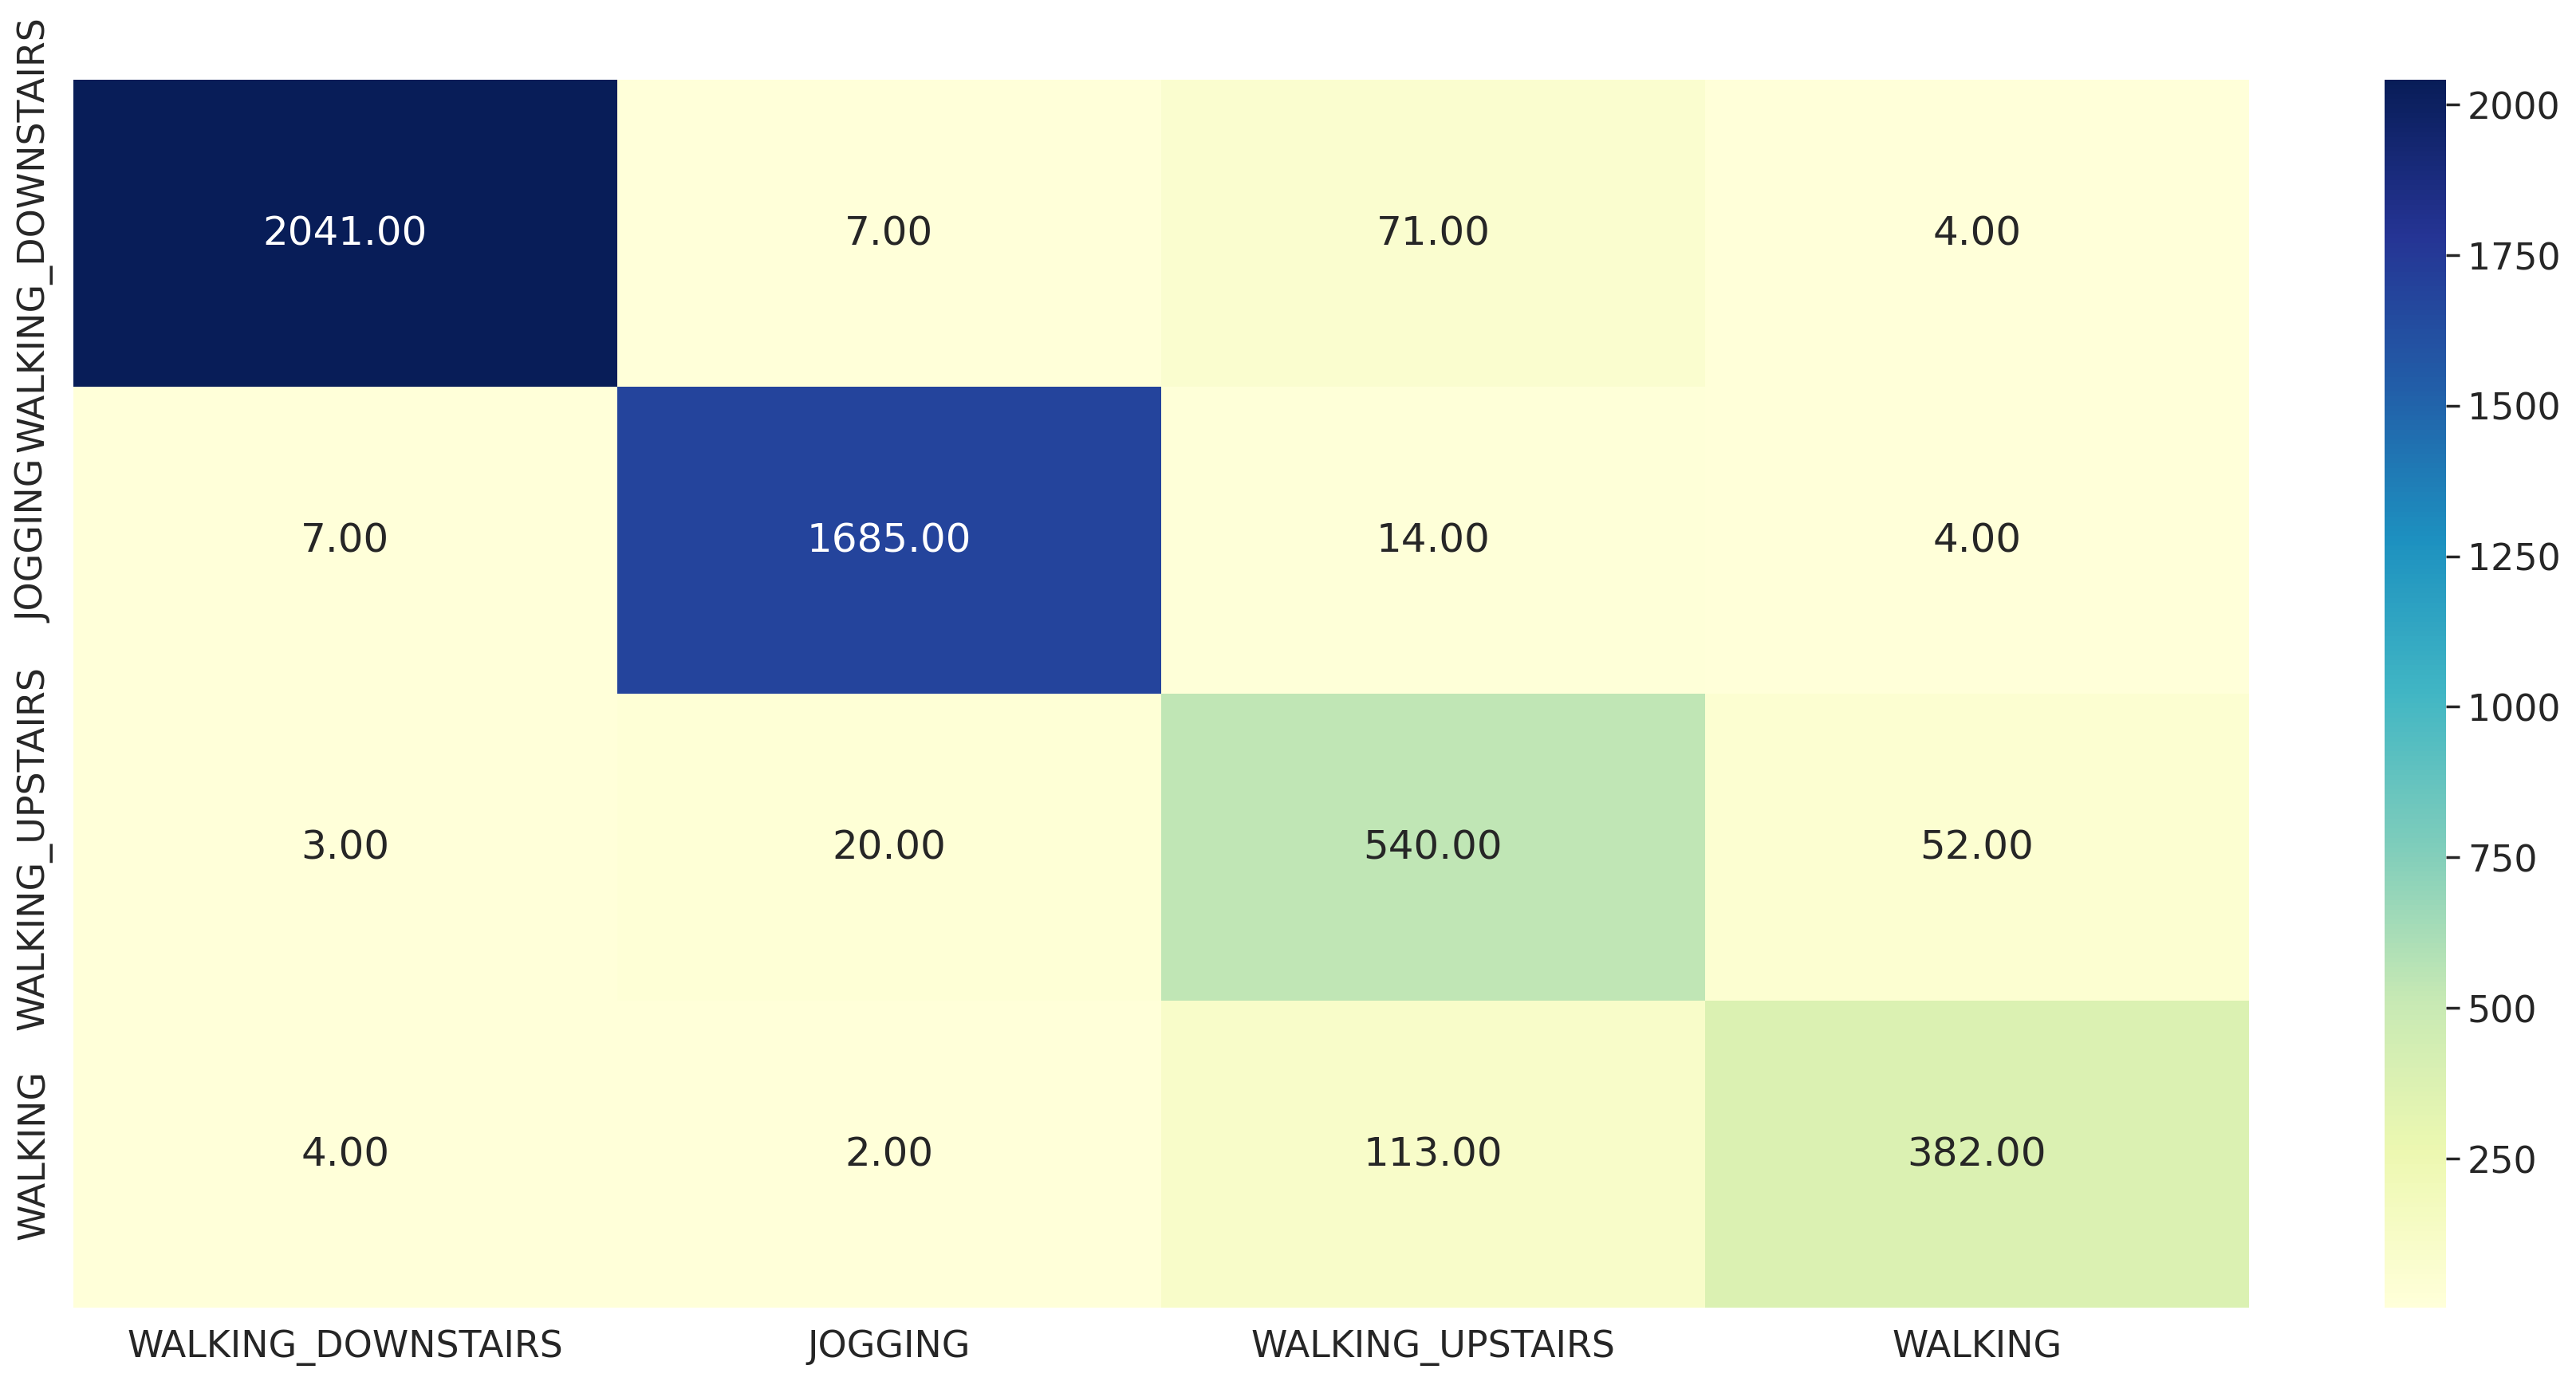

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN3 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_7 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 dropout_8 (Dropout)         (None, 196, 64)           0         
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 98, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 96, 64)            12352     
                                                                 
 dropout_9 (Dropout)         (None, 96, 64)            0         
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 63s 463ms/step - loss: 0.6861 - accuracy: 0.7378 - val_loss: 1.0014 - val_accuracy: 0.5835
Epoch 2/10
124/124 [==============================] - 62s 497ms/step - loss: 0.3840 - accuracy: 0.8509 - val_loss: 0.7311 - val_accuracy: 0.7224
Epoch 3/10
124/124 [==============================] - 63s 508ms/step - loss: 0.2904 - accuracy: 0.8835 - val_loss: 0.9144 - val_accuracy: 0.7371
Epoch 4/10
124/124 [==============================] - 58s 469ms/step - loss: 0.2112 - accuracy: 0.9235 - val_loss: 1.2706 - val_accuracy: 0.6433
Epoch 5/10
124/124 [==============================] - 64s 518ms/step - loss: 0.1609 - accuracy: 0.9449 - val_loss: 0.6600 - val_accuracy: 0.7373
Epoch 6/10
124/124 [==============================] - 58s 471ms/step - loss: 0.1388 - accuracy: 0.9525 - val_loss: 0.2507 - val_accuracy: 0.8798
Epoch 7/10
124/124 [==============================] - 63s 511ms/step - loss: 0.1224 - accuracy: 0.9600 - val_loss: 1.2989 - val_ac

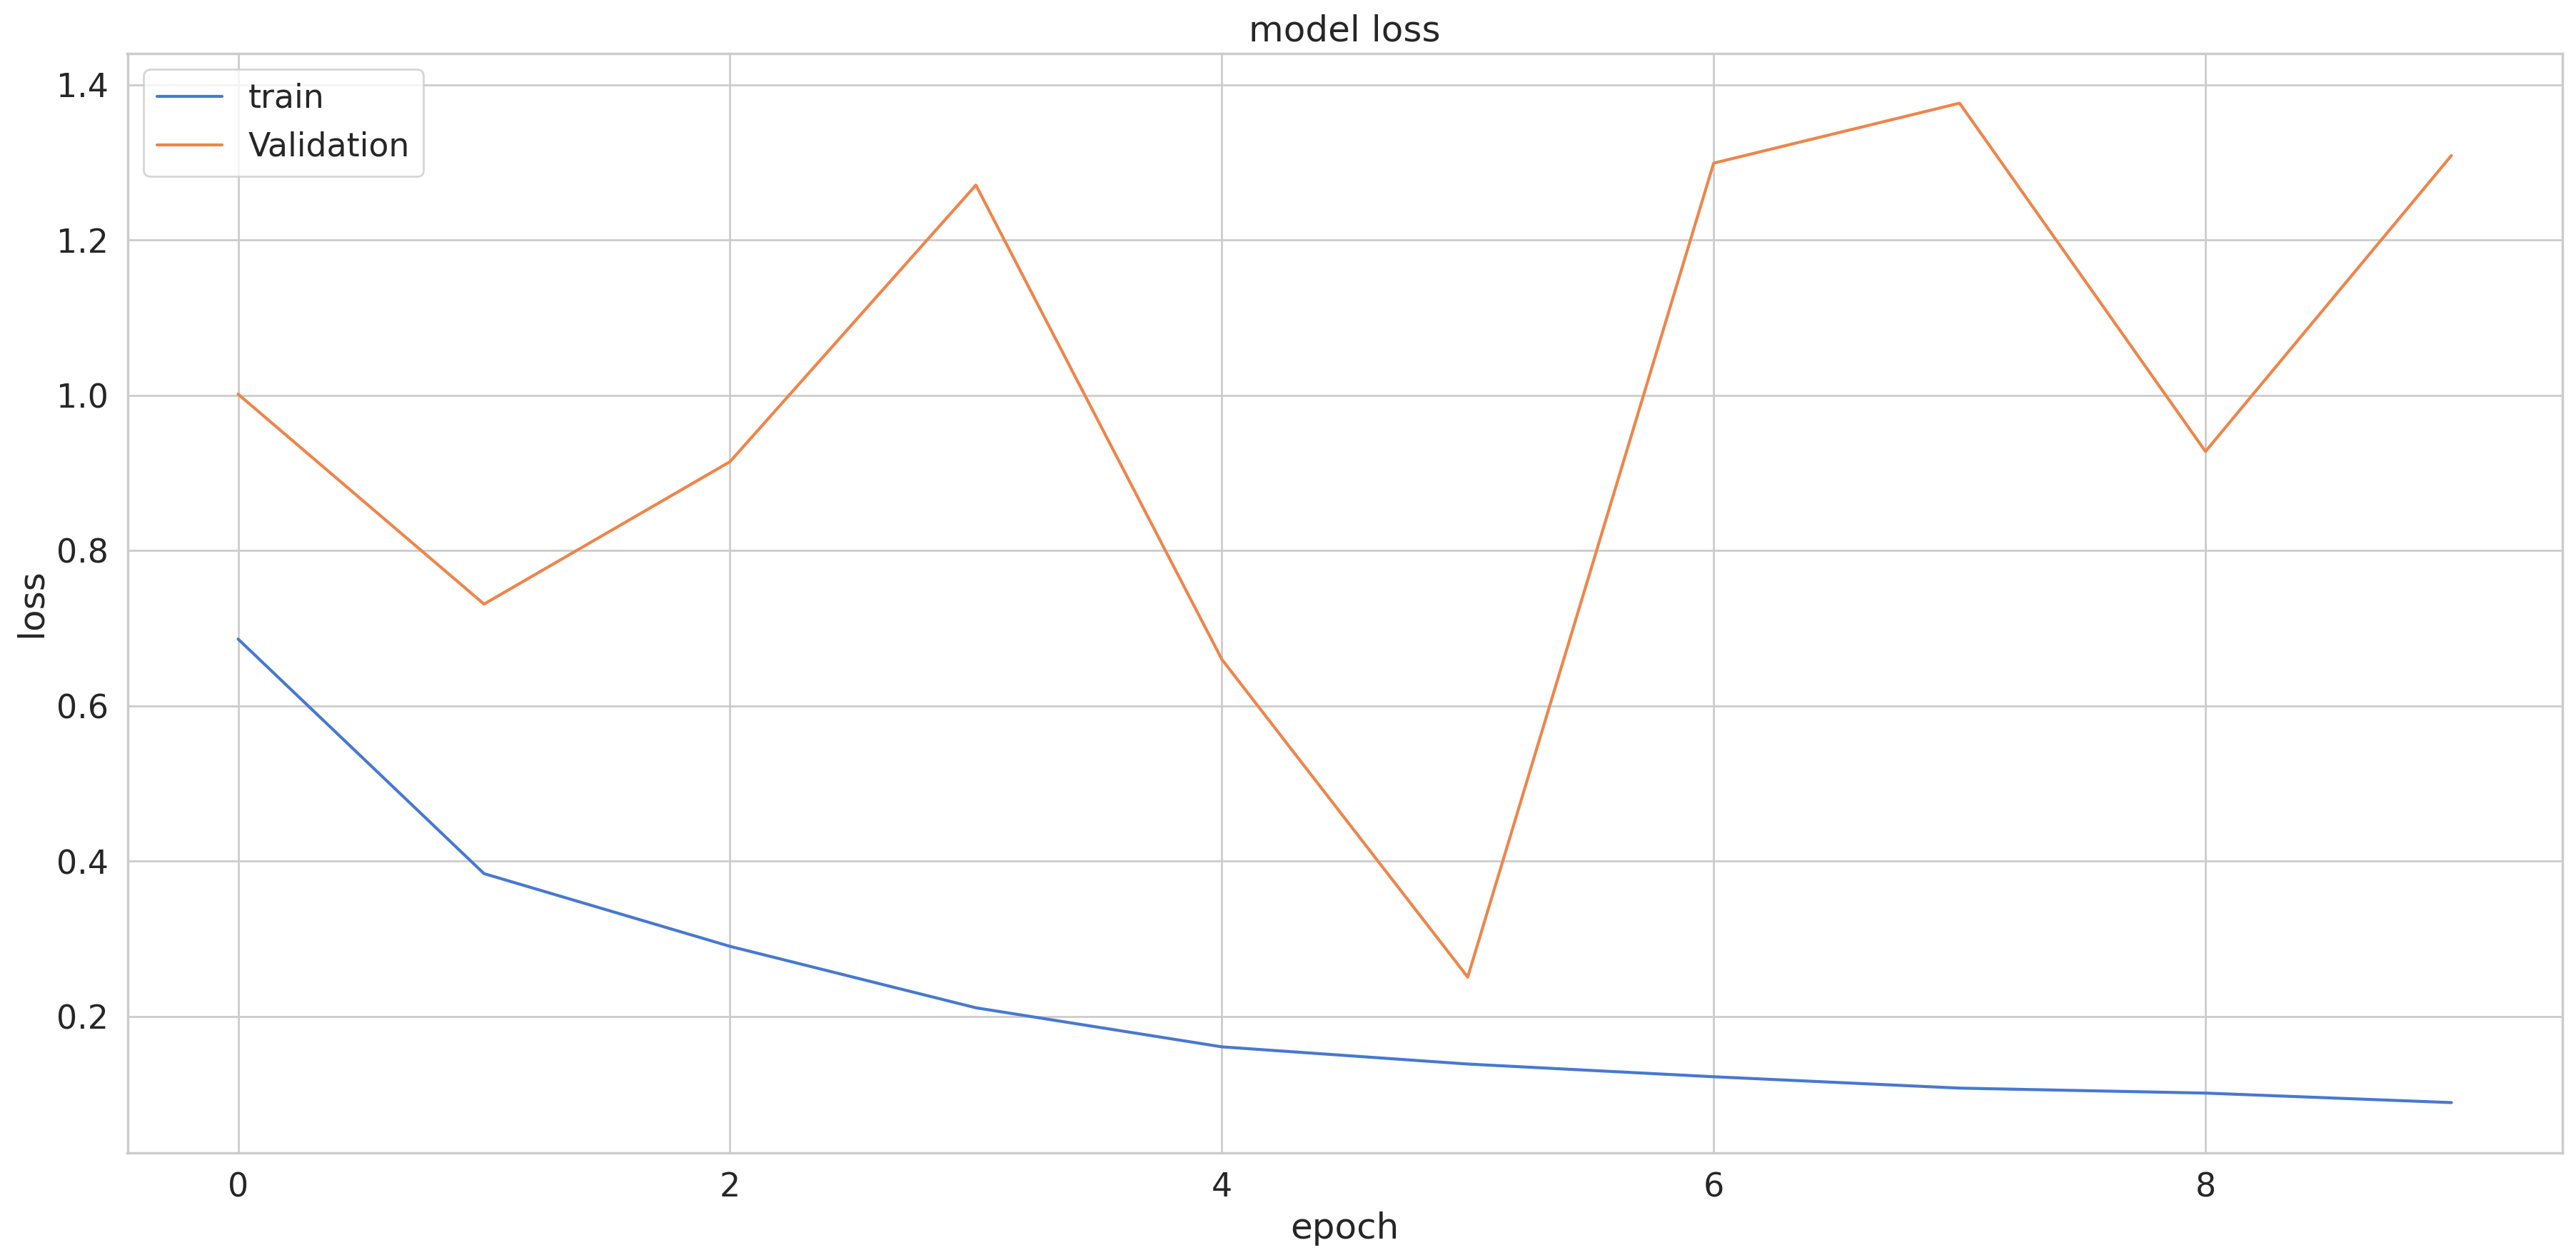

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

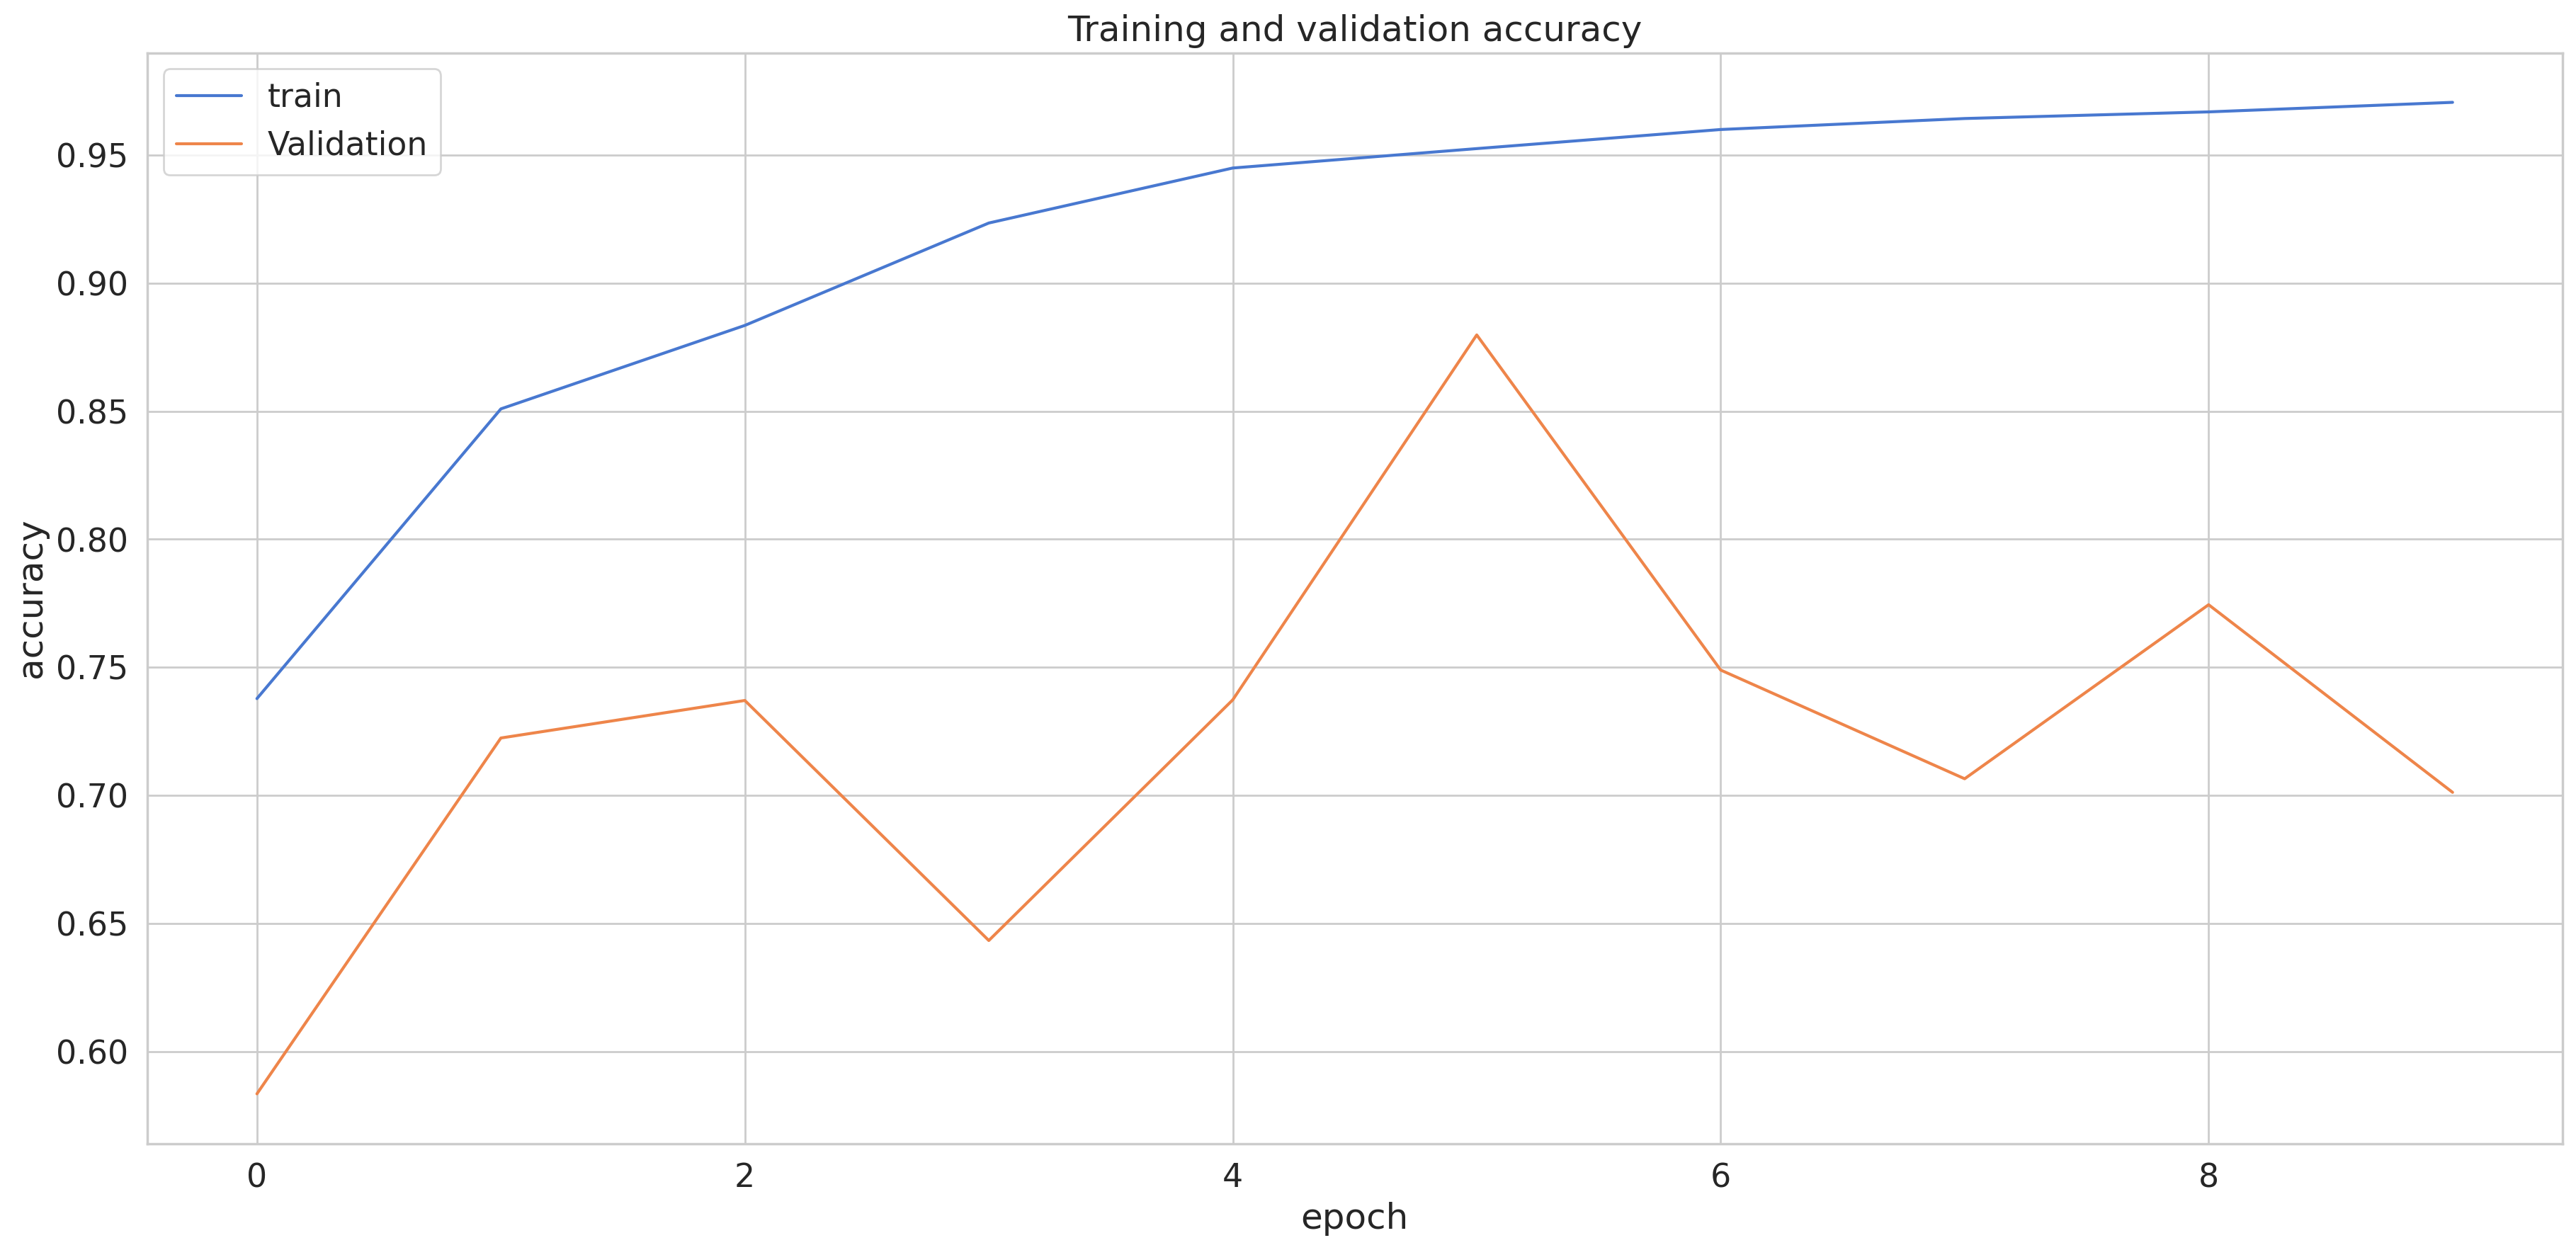

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 7s 36ms/step
f1_score =  0.7106026304078306
0.7045867852091332
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      2123
           1       0.99      0.36      0.52      1710
           2       0.35      0.65      0.46       615
           3       0.41      0.98      0.57       501

    accuracy                           0.70      4949
   macro avg       0.69      0.73      0.63      4949
weighted avg       0.86      0.70      0.71      4949



<Axes: >

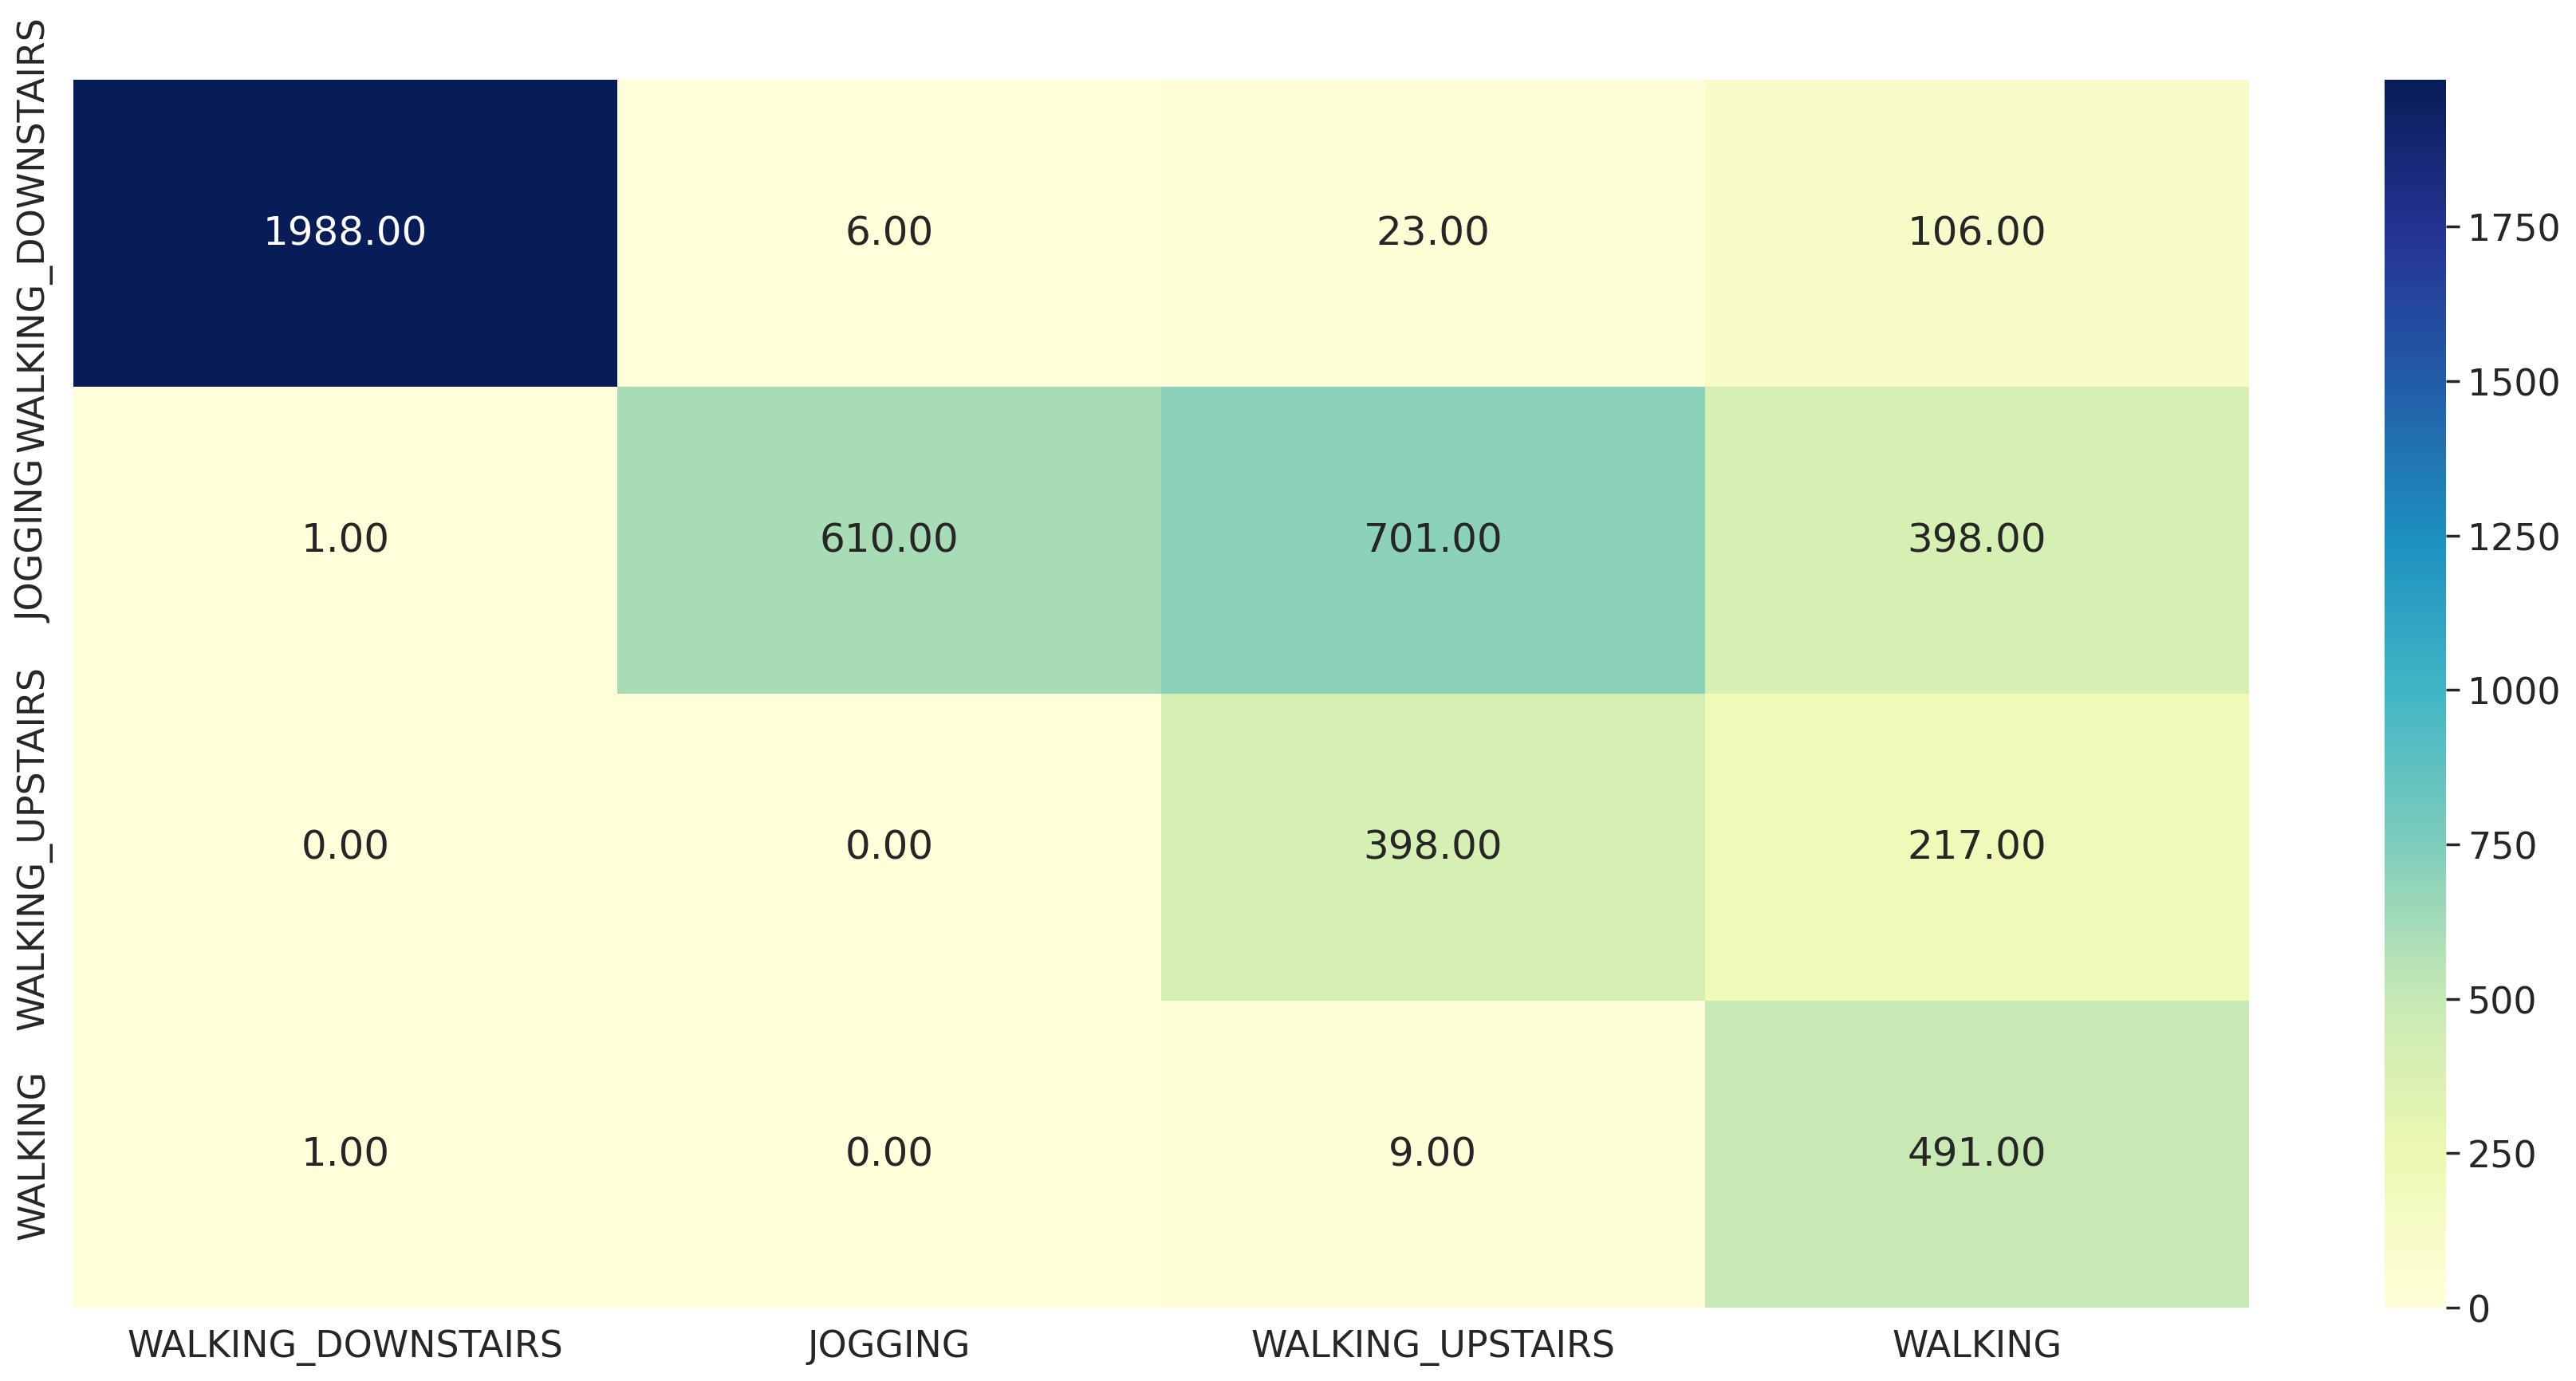

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# layer5

# CNN4 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 198, 64)           640       
                                                                 
 conv1d_10 (Conv1D)          (None, 196, 64)           12352     
                                                                 
 dropout_11 (Dropout)        (None, 196, 64)           0         
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 98, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 96, 64)            12352     
                                                                 
 conv1d_12 (Conv1D)          (None, 94, 64)            12352     
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 73s 531ms/step - loss: 0.7005 - accuracy: 0.7366 - val_loss: 0.8264 - val_accuracy: 0.6701
Epoch 2/10
124/124 [==============================] - 64s 511ms/step - loss: 0.3745 - accuracy: 0.8501 - val_loss: 0.6690 - val_accuracy: 0.7340
Epoch 3/10
124/124 [==============================] - 66s 532ms/step - loss: 0.2748 - accuracy: 0.8845 - val_loss: 1.2356 - val_accuracy: 0.6343
Epoch 4/10
124/124 [==============================] - 72s 578ms/step - loss: 0.2463 - accuracy: 0.9066 - val_loss: 0.4365 - val_accuracy: 0.8260
Epoch 5/10
124/124 [==============================] - 68s 550ms/step - loss: 0.1636 - accuracy: 0.9417 - val_loss: 1.0105 - val_accuracy: 0.7062
Epoch 6/10
124/124 [==============================] - 63s 508ms/step - loss: 0.1418 - accuracy: 0.9521 - val_loss: 1.6062 - val_accuracy: 0.6360
Epoch 7/10
124/124 [==============================] - 64s 515ms/step - loss: 0.1192 - accuracy: 0.9605 - val_loss: 0.7377 - val_ac

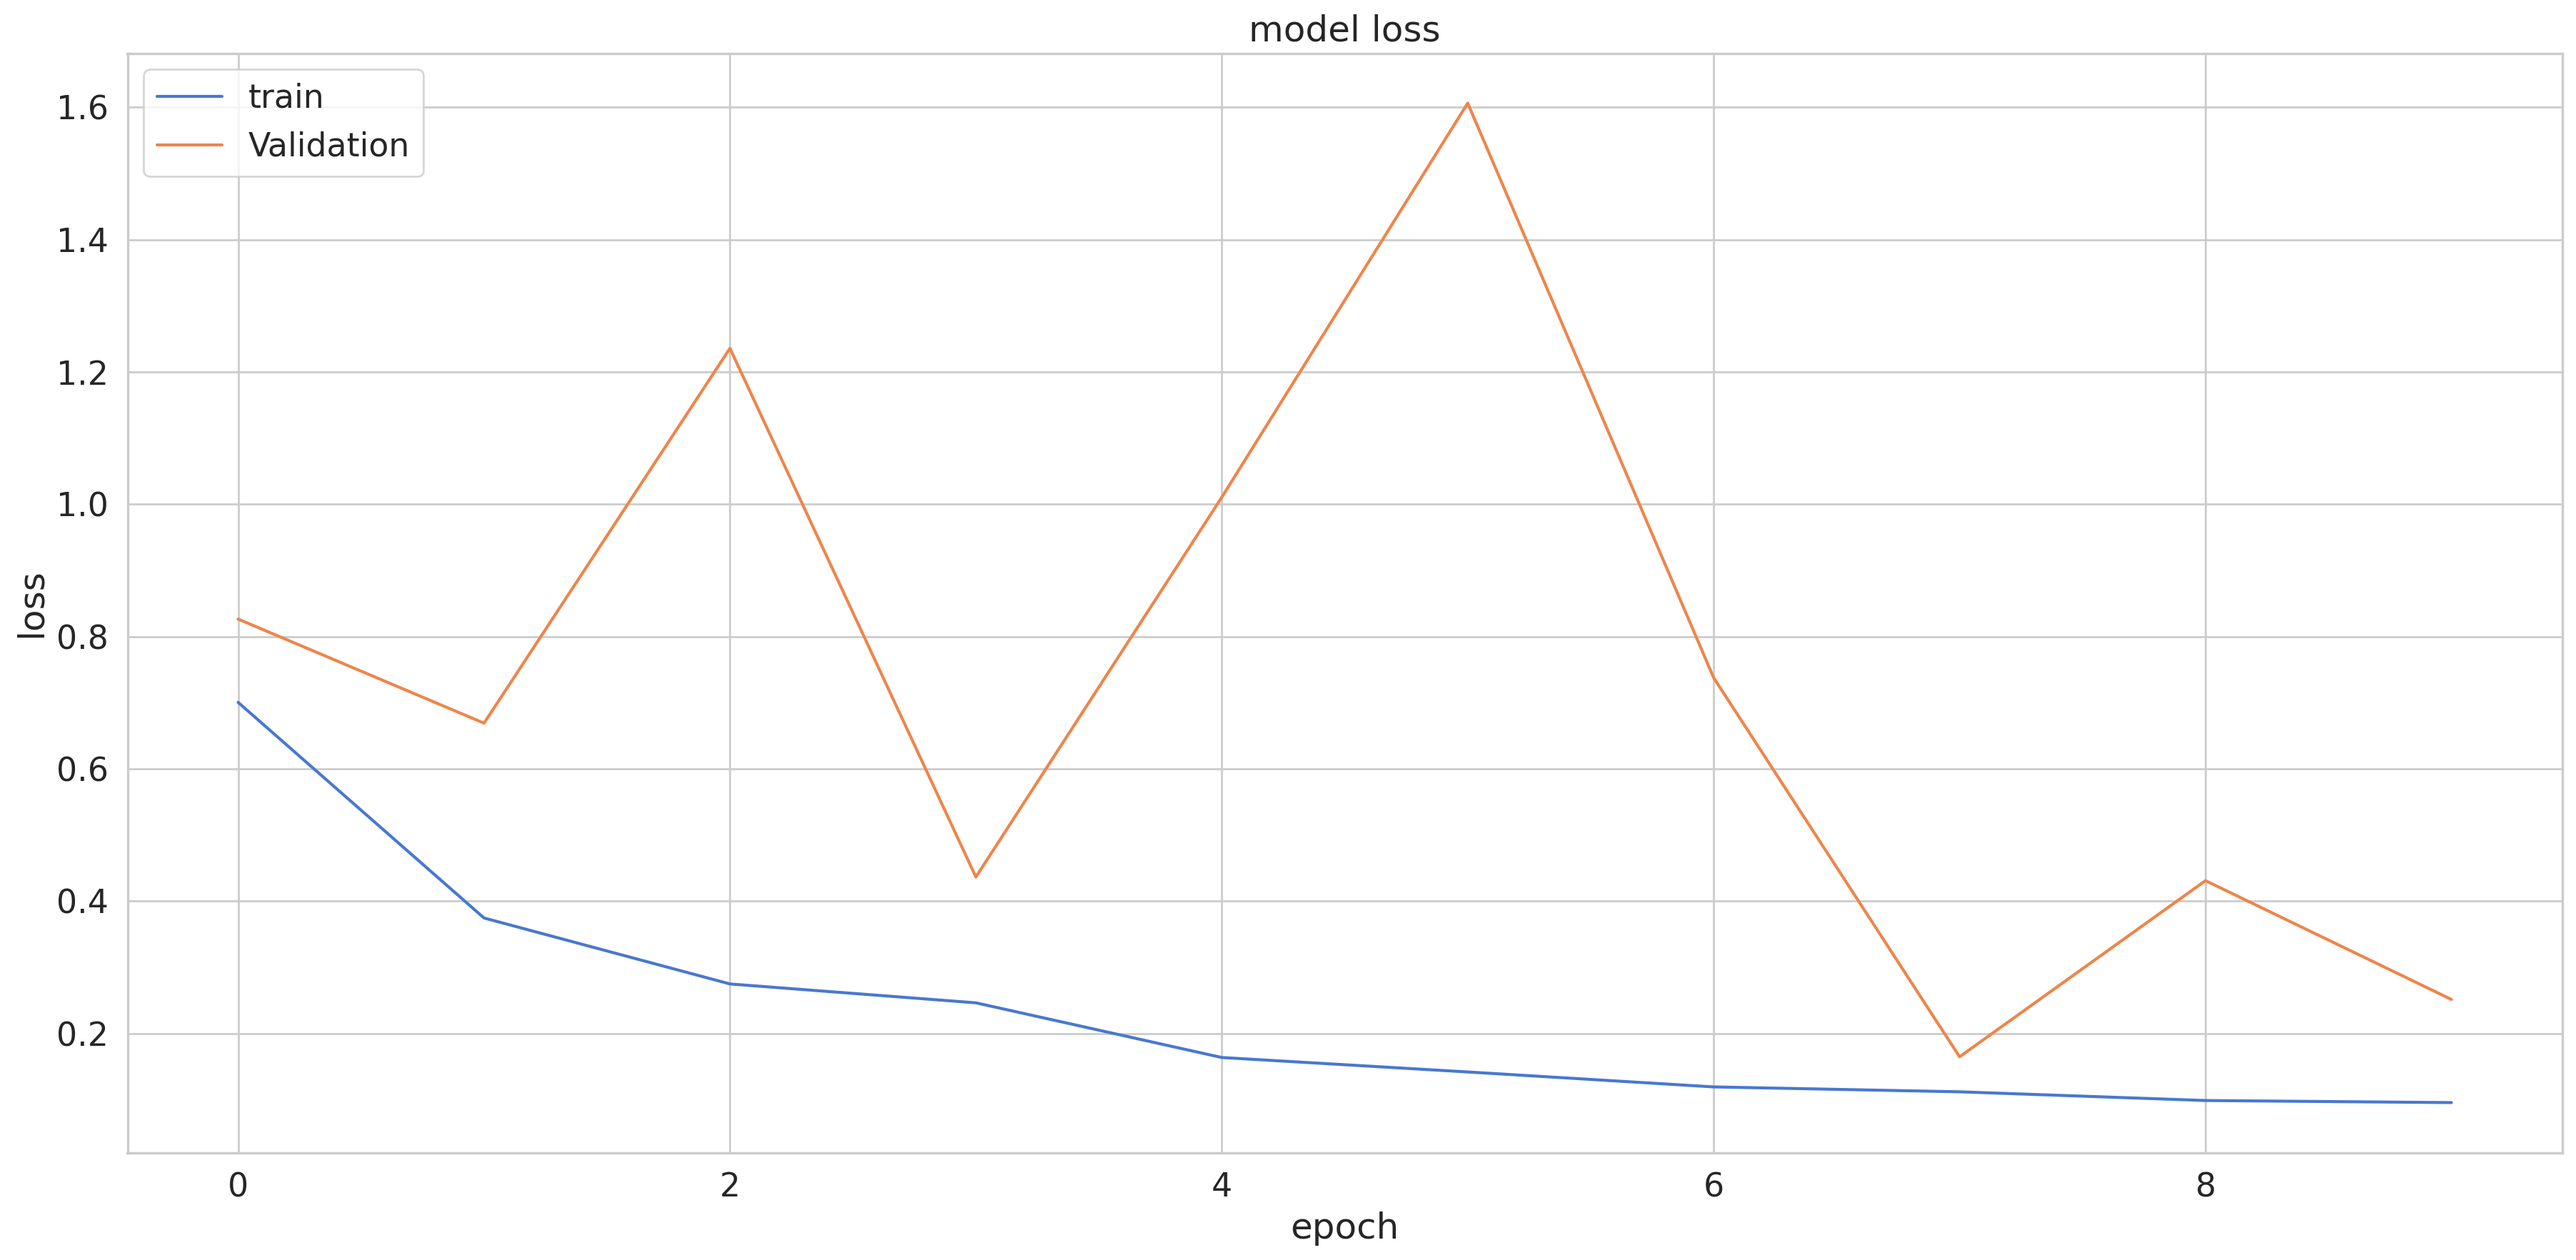

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

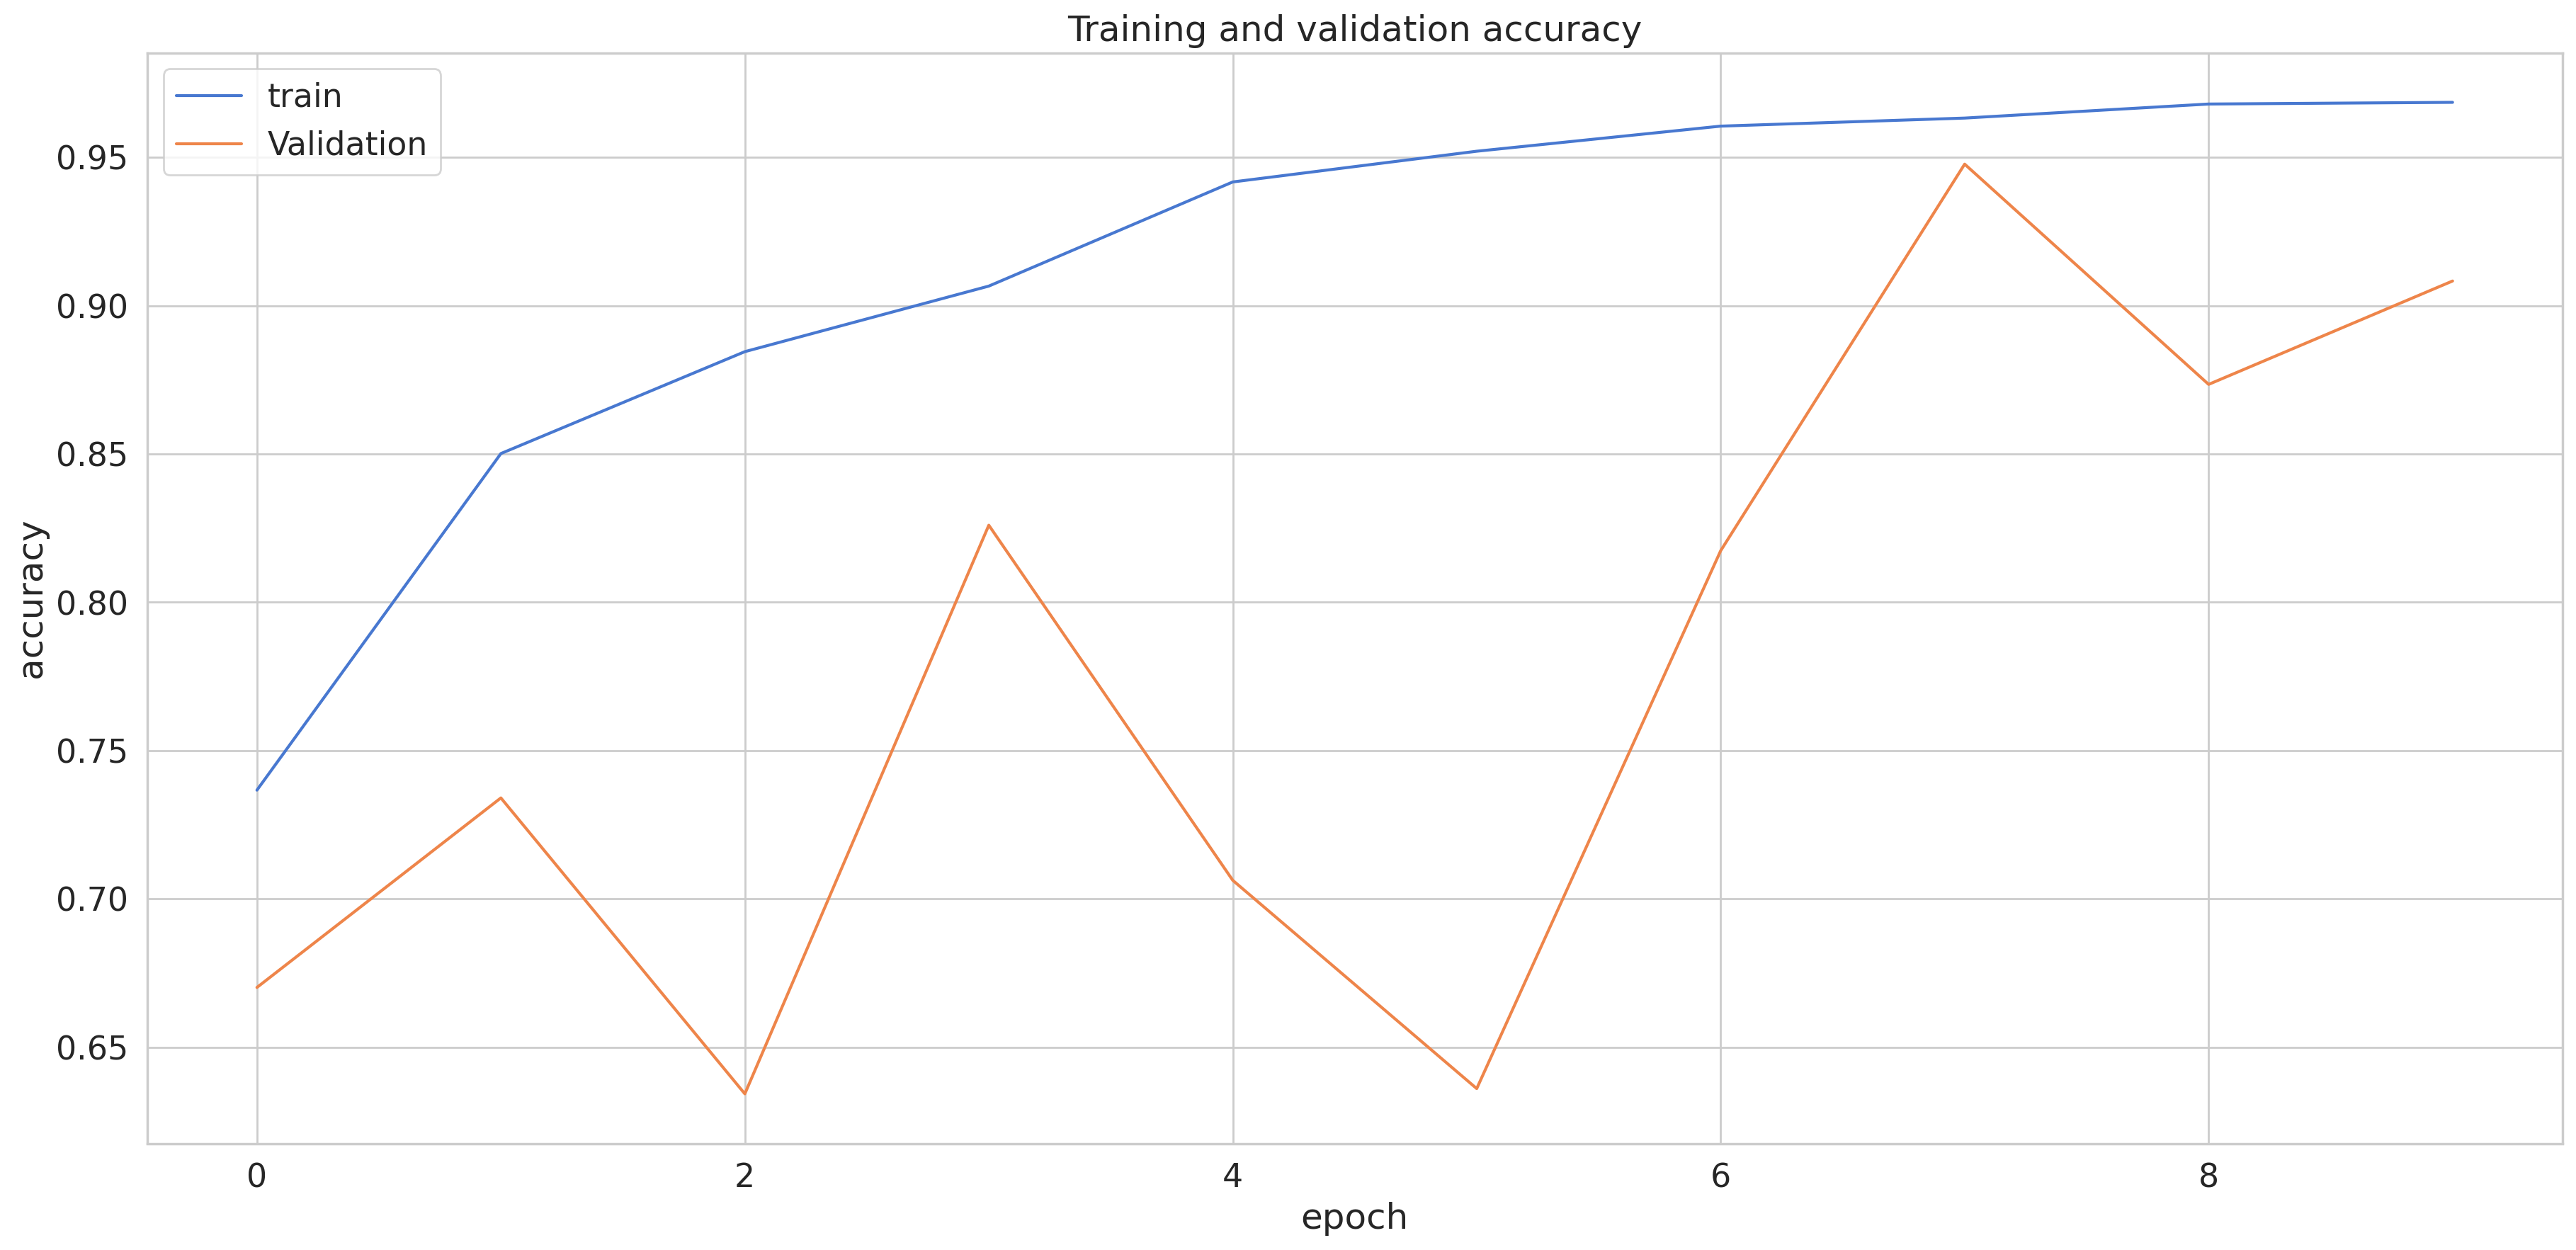

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 8s 46ms/step
f1_score =  0.9101897052859428
0.9068498686603355
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2123
           1       1.00      0.83      0.91      1710
           2       0.65      0.78      0.71       615
           3       0.75      0.96      0.84       501

    accuracy                           0.91      4949
   macro avg       0.84      0.89      0.86      4949
weighted avg       0.92      0.91      0.91      4949



<Axes: >

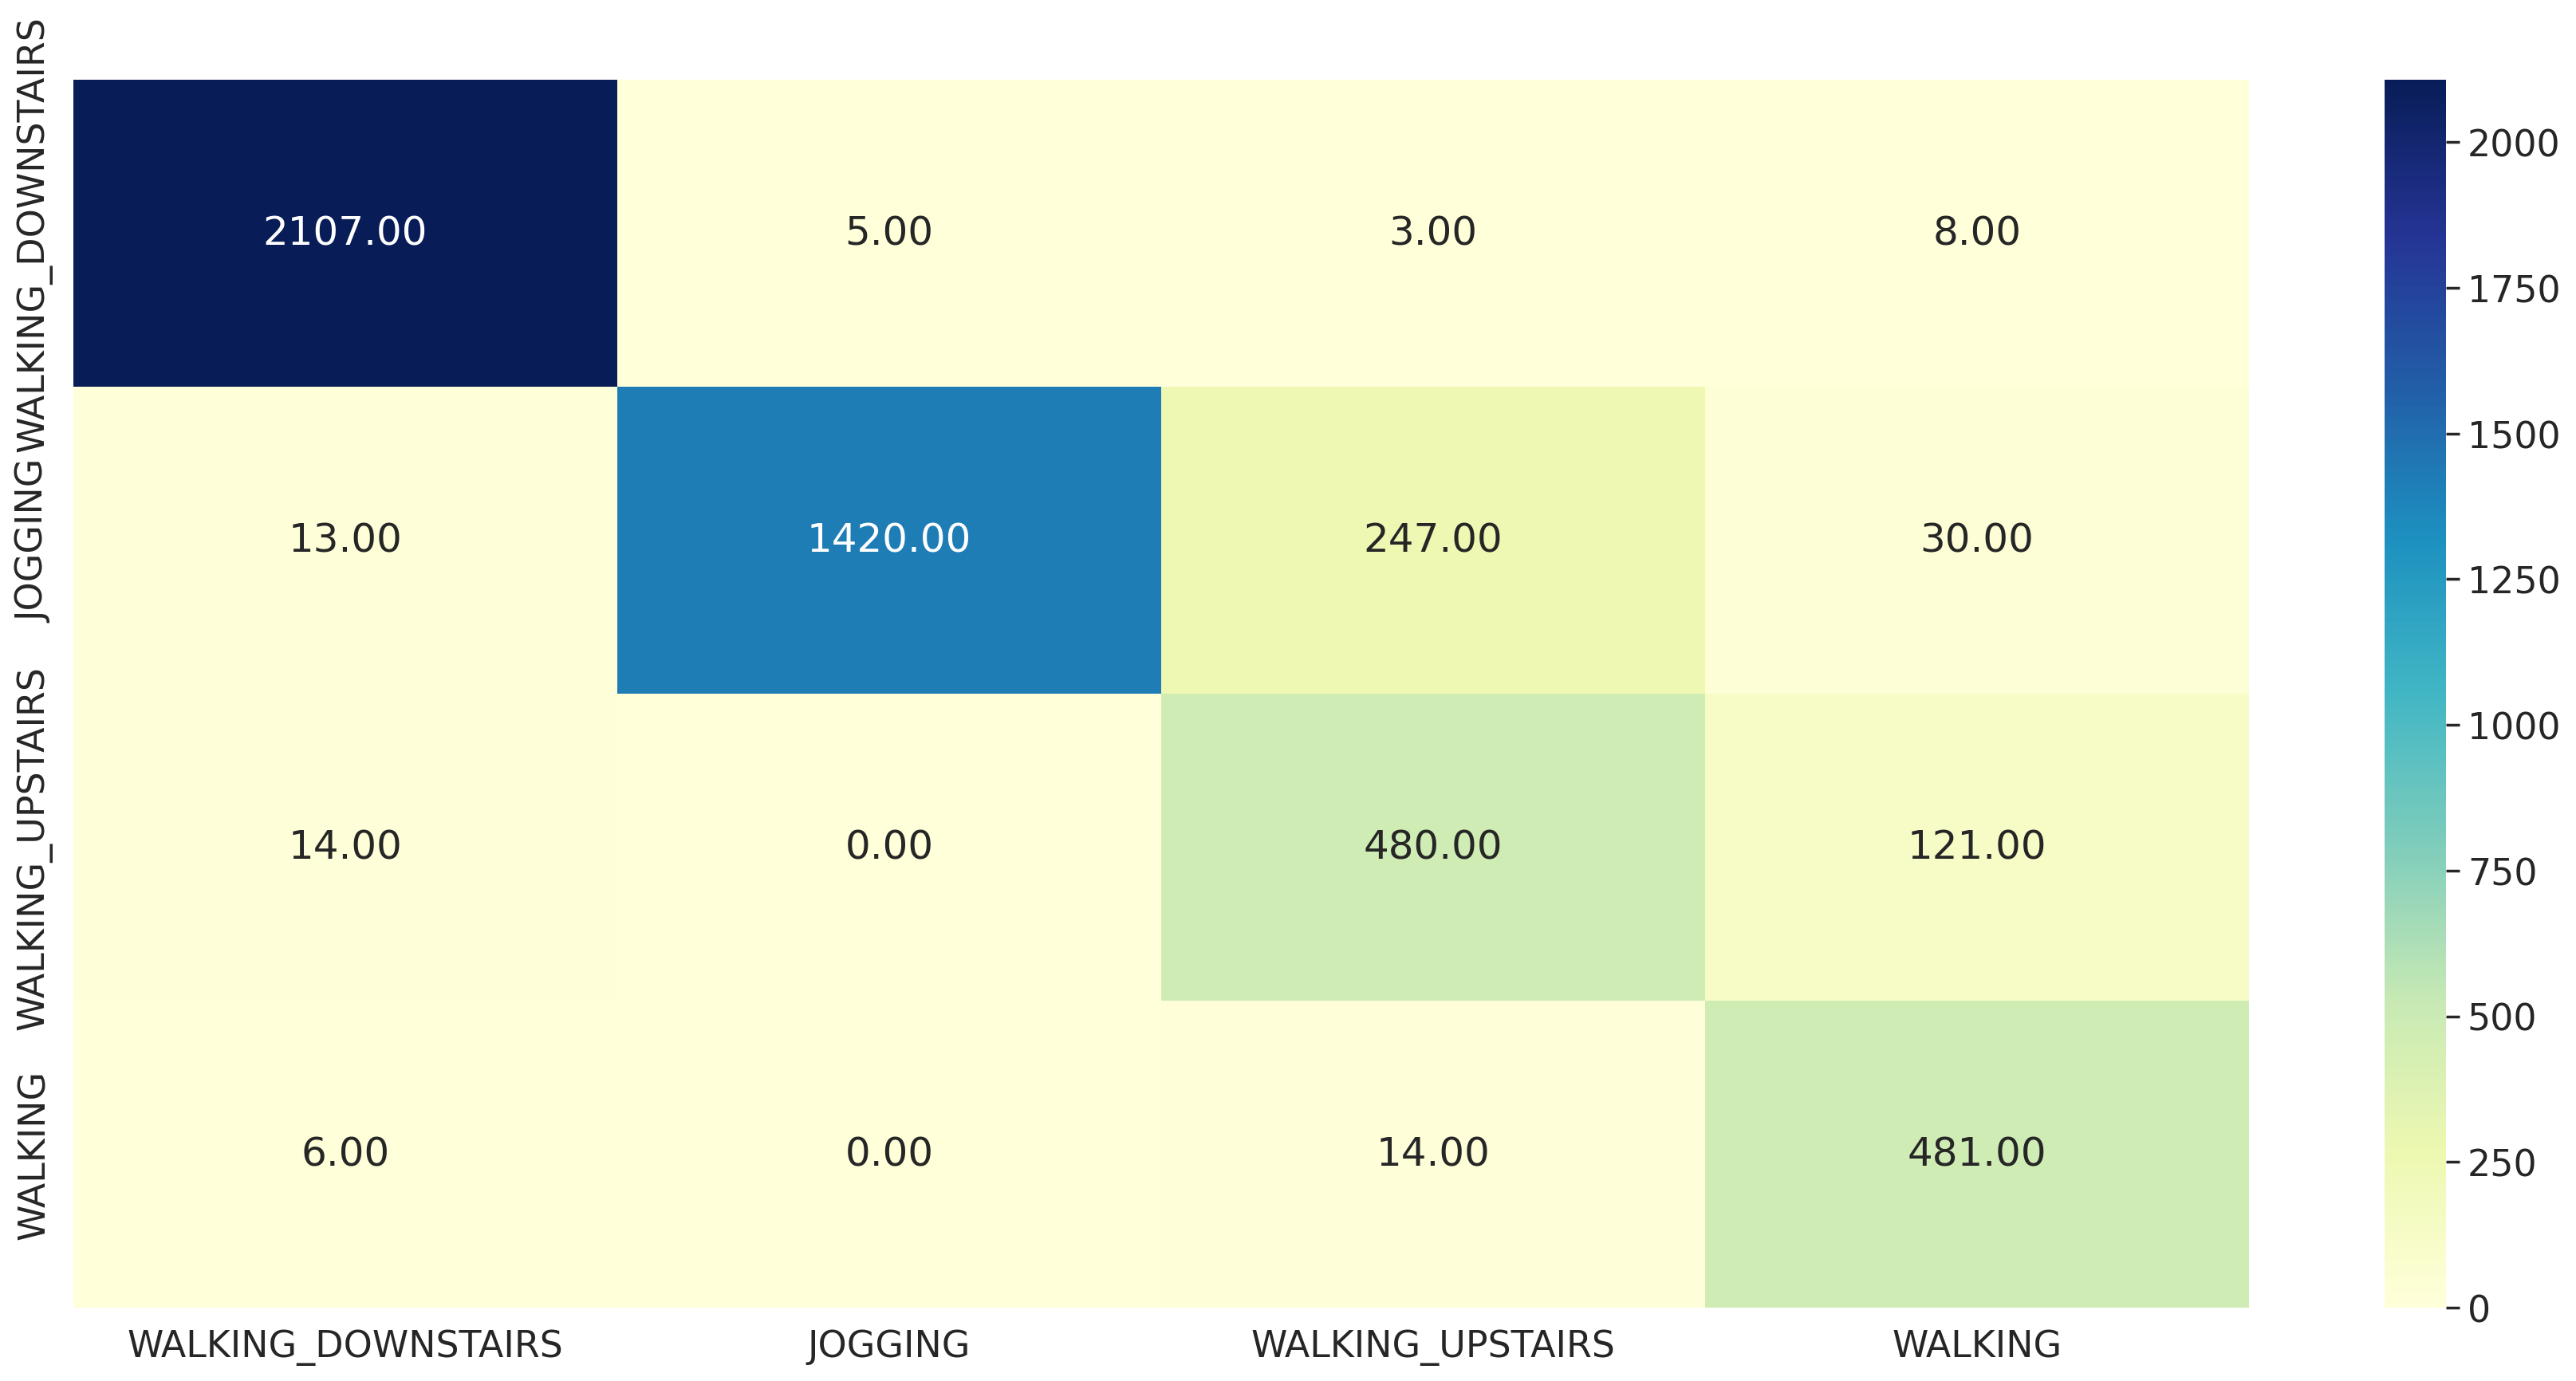

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# timedistributed

In [ ]:
n_steps = 4
n_features = X_train.shape[2]
n_length = 50

X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))

In [ ]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps, n_features, n_outputs = n_steps * n_length, X_train.shape[3], y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 4)

# CNN1 - LSTM1

In [ ]:
# Model 1
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 48, 64)      640       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 48, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 24, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 1536)        0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)              

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 15s 92ms/step - loss: 0.6500 - accuracy: 0.7557 - val_loss: 0.4207 - val_accuracy: 0.8343
Epoch 2/10
124/124 [==============================] - 11s 86ms/step - loss: 0.3720 - accuracy: 0.8546 - val_loss: 0.3747 - val_accuracy: 0.8333
Epoch 3/10
124/124 [==============================] - 12s 93ms/step - loss: 0.2943 - accuracy: 0.8784 - val_loss: 0.2541 - val_accuracy: 0.8906
Epoch 4/10
124/124 [==============================] - 12s 94ms/step - loss: 0.2368 - accuracy: 0.9058 - val_loss: 0.2207 - val_accuracy: 0.9156
Epoch 5/10
124/124 [==============================] - 12s 93ms/step - loss: 0.1970 - accuracy: 0.9248 - val_loss: 0.2112 - val_accuracy: 0.9232
Epoch 6/10
124/124 [==============================] - 12s 101ms/step - loss: 0.1556 - accuracy: 0.9411 - val_loss: 0.1565 - val_accuracy: 0.9424
Epoch 7/10
124/124 [==============================] - 12s 96ms/step - loss: 0.1308 - accuracy: 0.9512 - val_loss: 0.1726 - val_accuracy

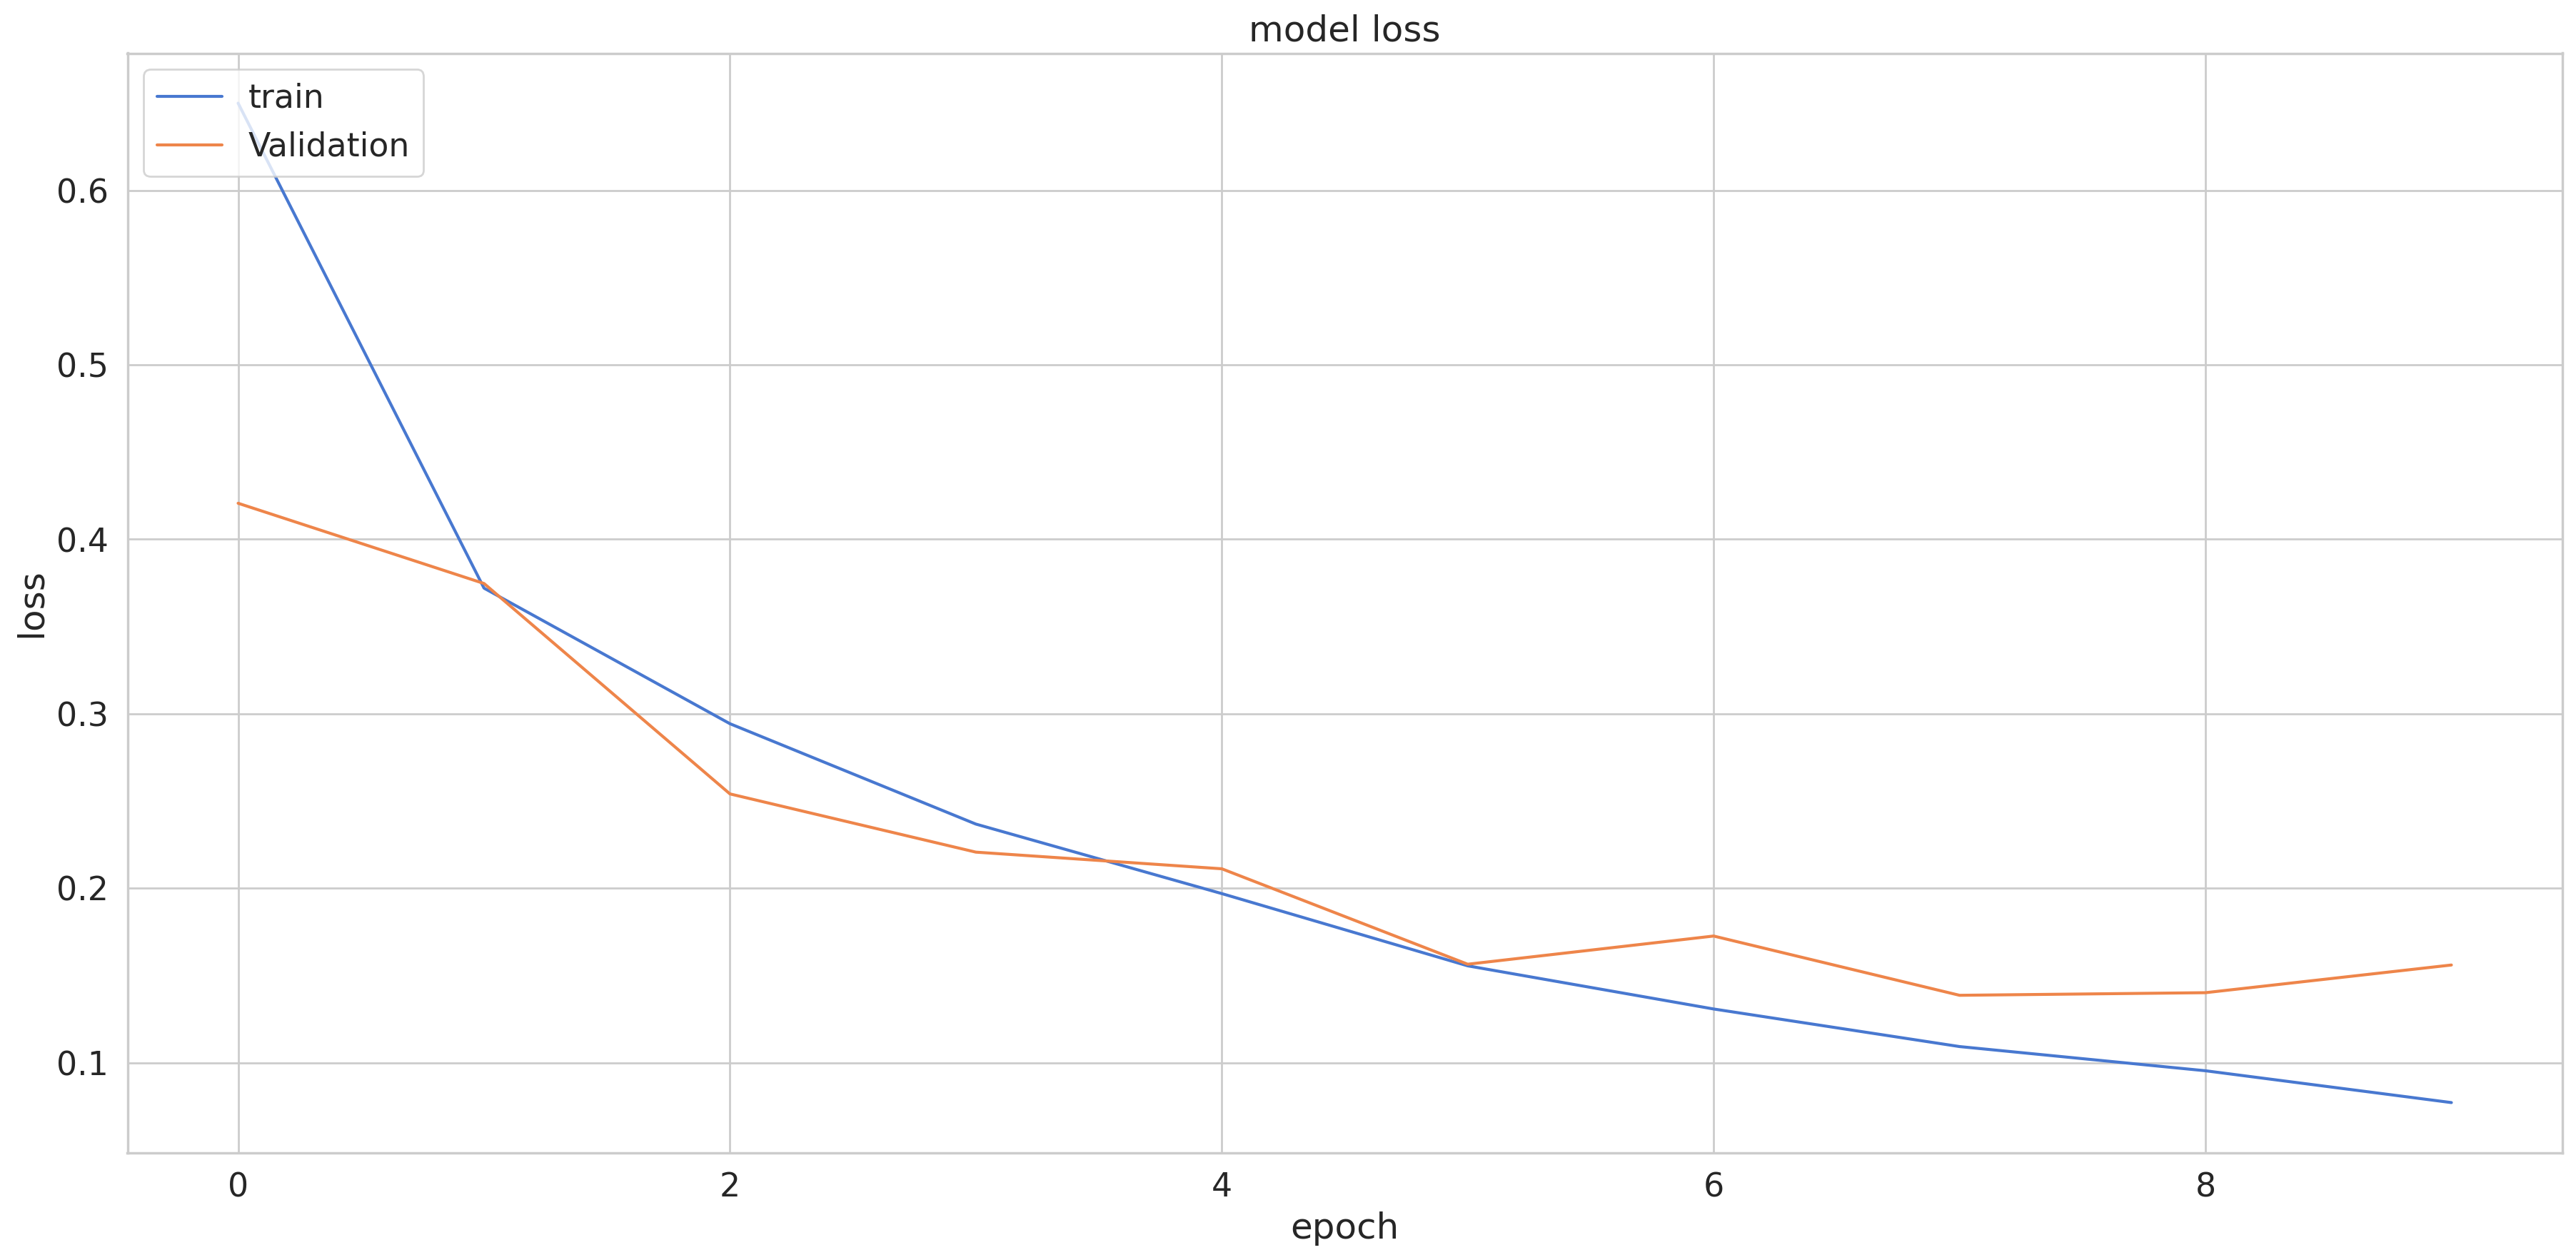

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

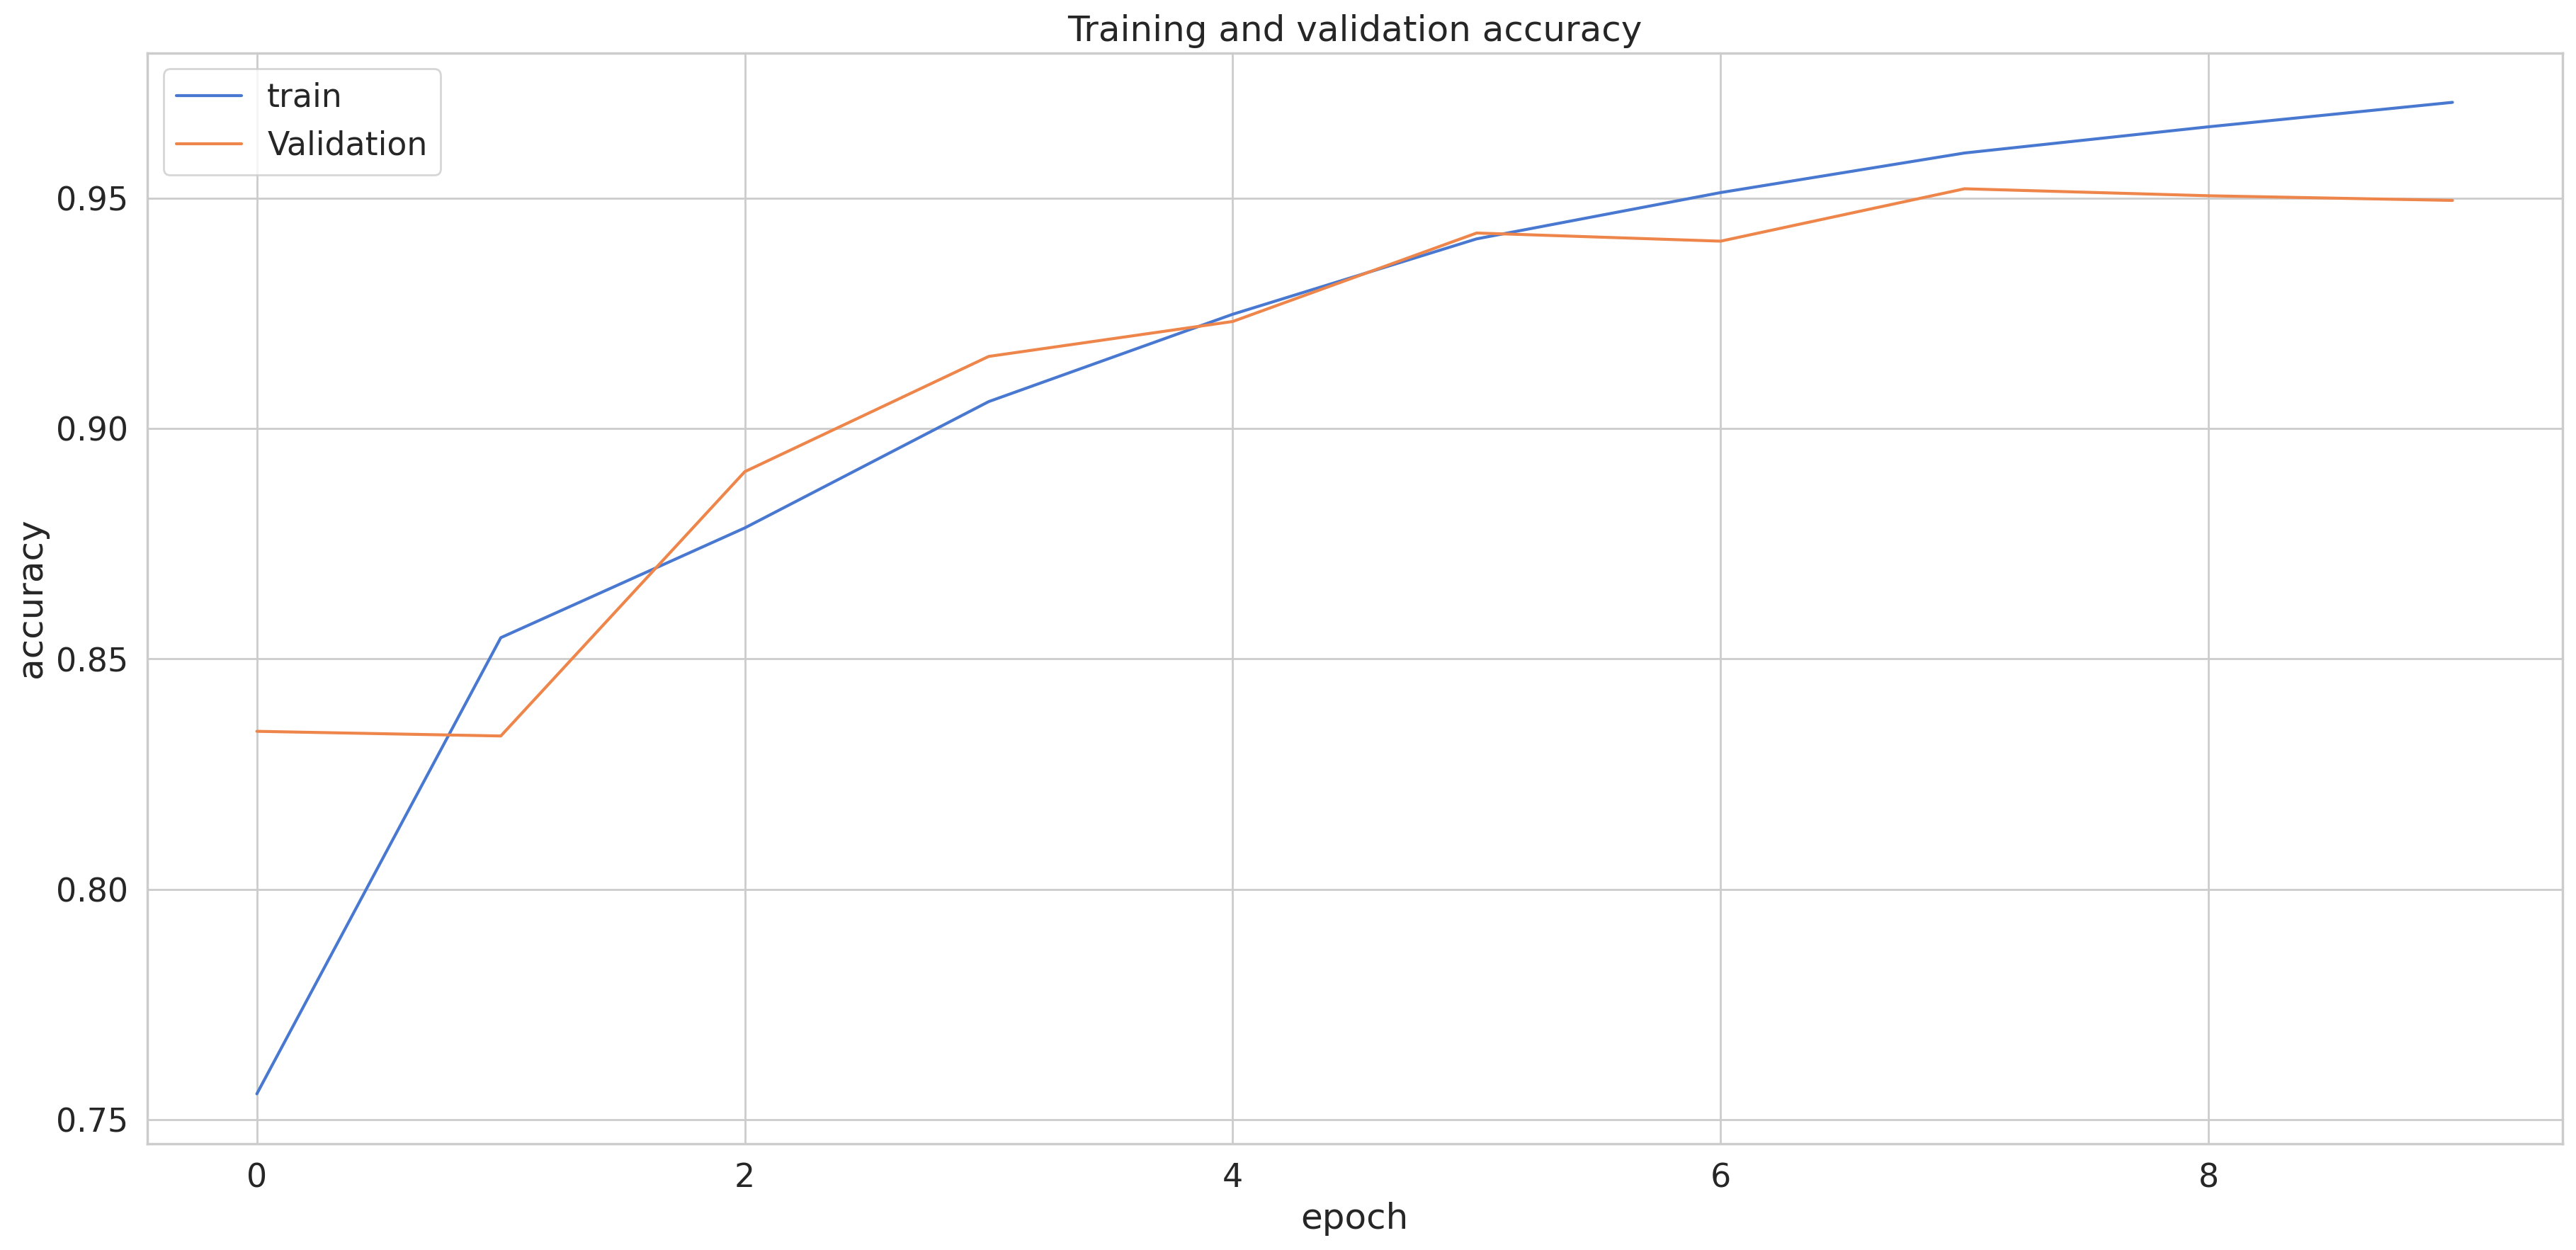

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 2s 8ms/step
f1_score =  0.9591519396445803
0.959789856536674
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.97      1.00      0.98      1710
           2       0.91      0.80      0.85       615
           3       0.86      0.91      0.89       501

    accuracy                           0.96      4949
   macro avg       0.93      0.92      0.93      4949
weighted avg       0.96      0.96      0.96      4949



<Axes: >

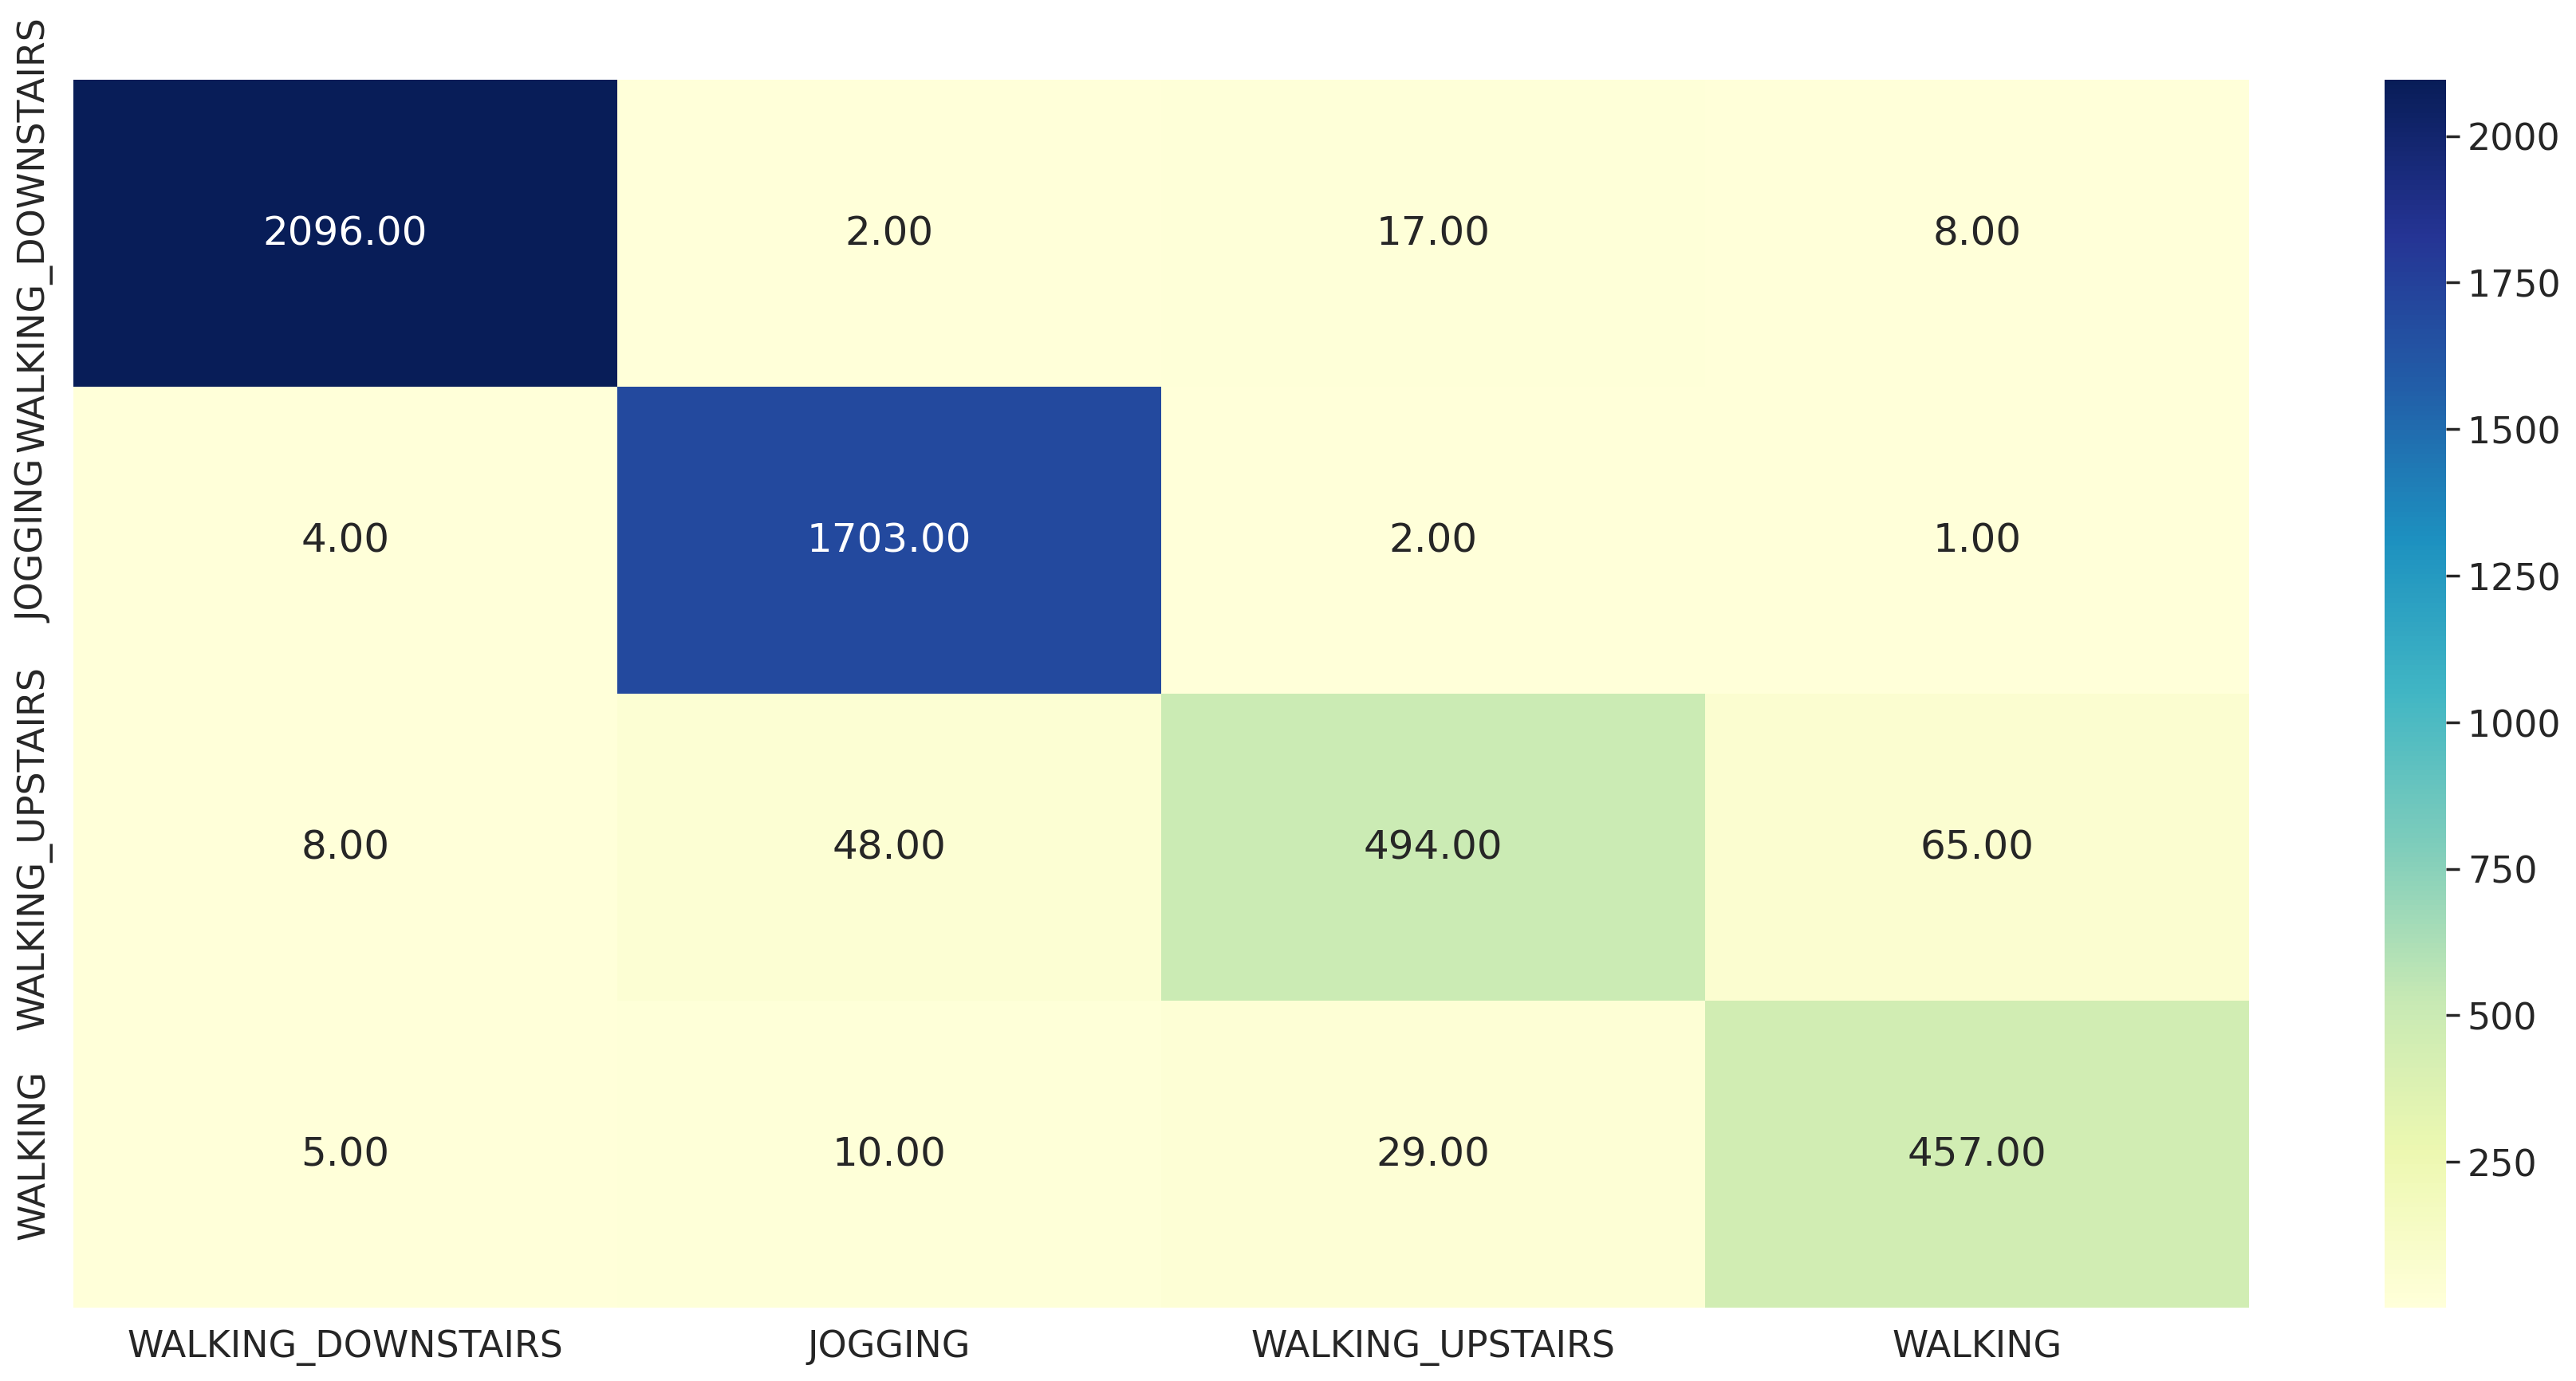

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN1 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 48, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 24, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 1536)        0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, None, 100)        

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 19s 112ms/step - loss: 0.6883 - accuracy: 0.7455 - val_loss: 0.4503 - val_accuracy: 0.8368
Epoch 2/10
124/124 [==============================] - 13s 102ms/step - loss: 0.3752 - accuracy: 0.8465 - val_loss: 0.3087 - val_accuracy: 0.8628
Epoch 3/10
124/124 [==============================] - 13s 106ms/step - loss: 0.2965 - accuracy: 0.8762 - val_loss: 0.2822 - val_accuracy: 0.8942
Epoch 4/10
124/124 [==============================] - 13s 104ms/step - loss: 0.2211 - accuracy: 0.9163 - val_loss: 0.1937 - val_accuracy: 0.9298
Epoch 5/10
124/124 [==============================] - 16s 126ms/step - loss: 0.1759 - accuracy: 0.9350 - val_loss: 0.1746 - val_accuracy: 0.9414
Epoch 6/10
124/124 [==============================] - 13s 105ms/step - loss: 0.1460 - accuracy: 0.9471 - val_loss: 0.1514 - val_accuracy: 0.9500
Epoch 7/10
124/124 [==============================] - 15s 120ms/step - loss: 0.1171 - accuracy: 0.9591 - val_loss: 0.1384 - val_ac

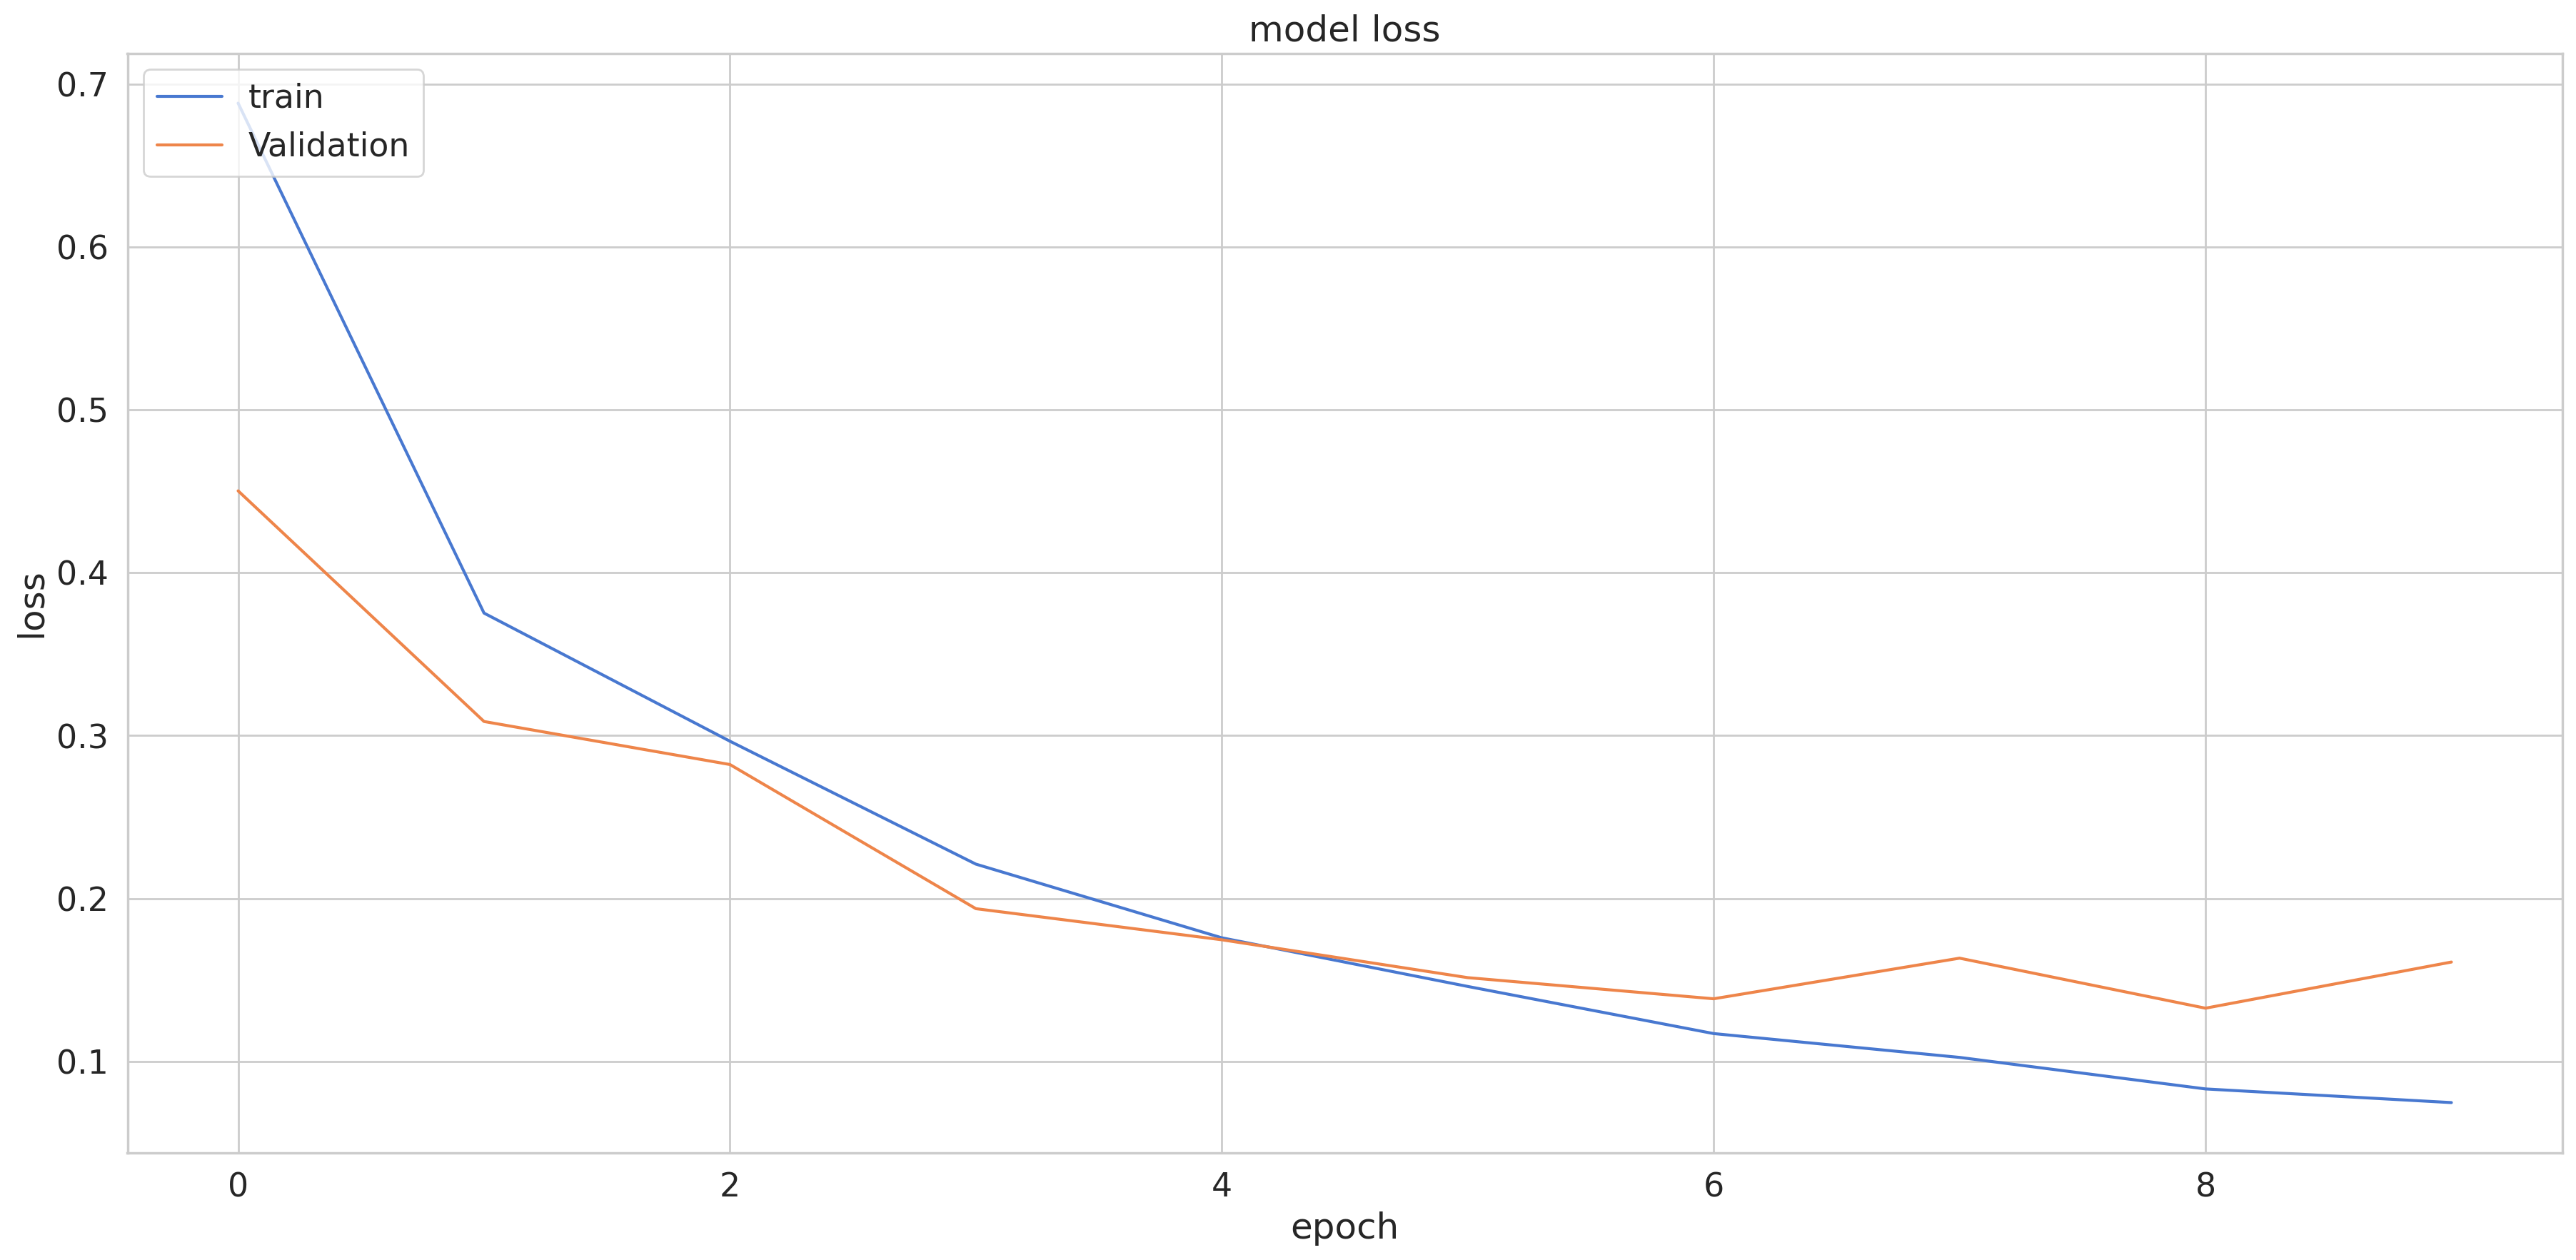

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

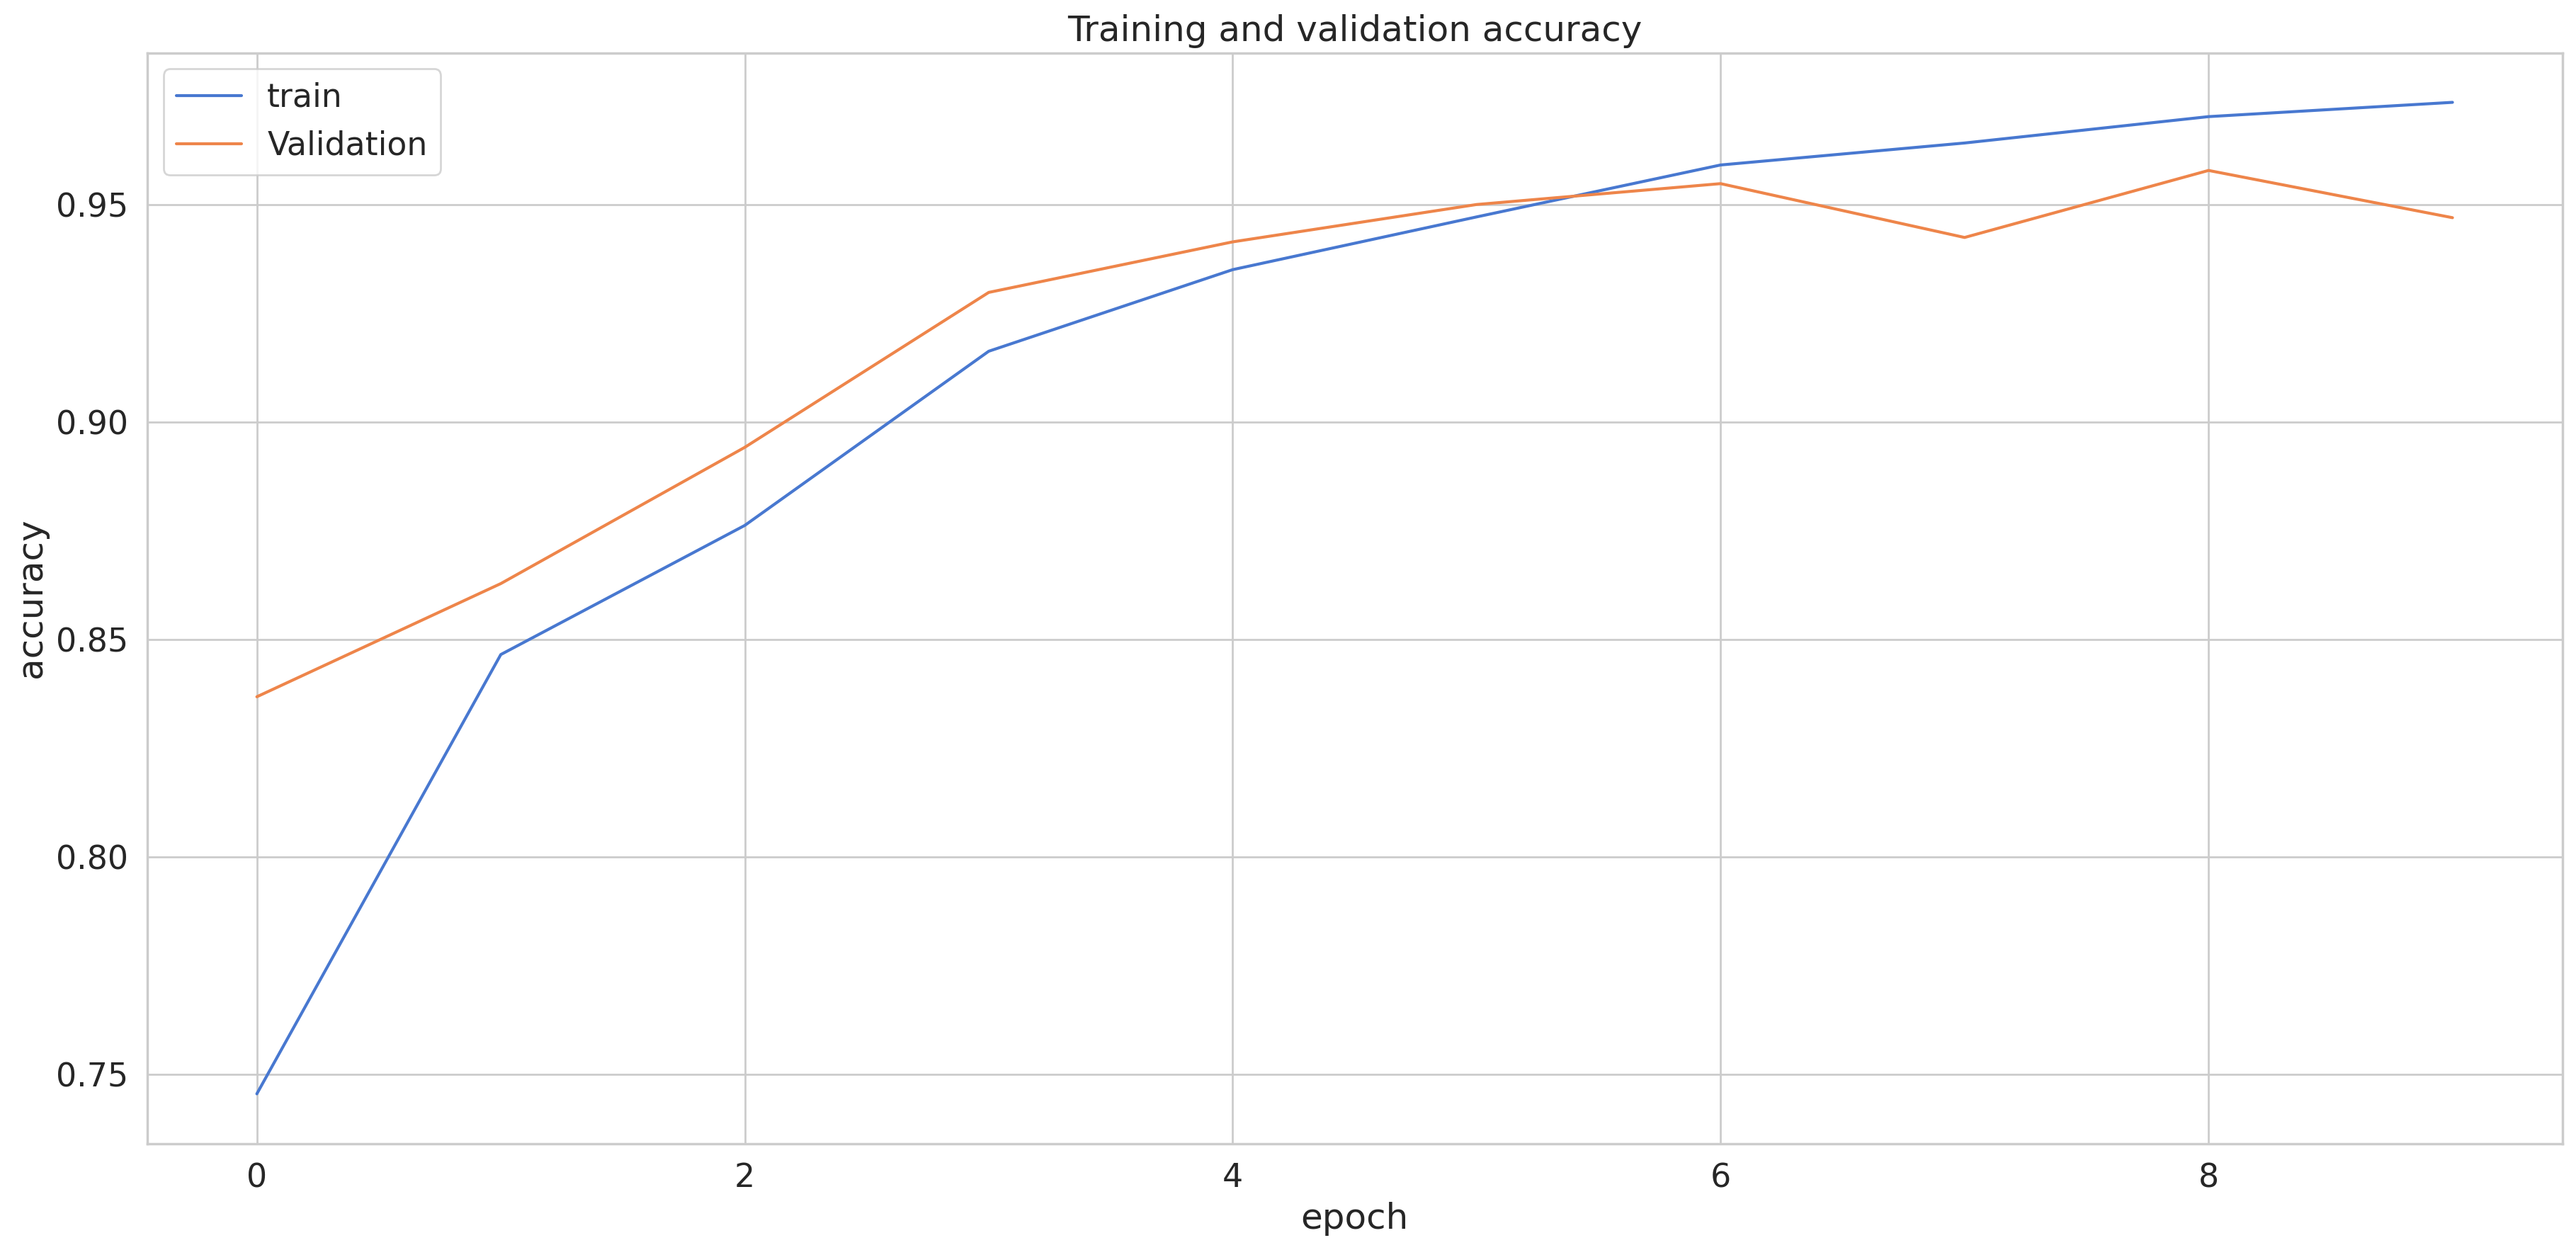

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 2s 8ms/step
f1_score =  0.9550852377348167
0.9559506971105274
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.98      0.99      0.99      1710
           2       0.96      0.72      0.82       615
           3       0.77      0.97      0.86       501

    accuracy                           0.96      4949
   macro avg       0.92      0.92      0.91      4949
weighted avg       0.96      0.96      0.96      4949



<Axes: >

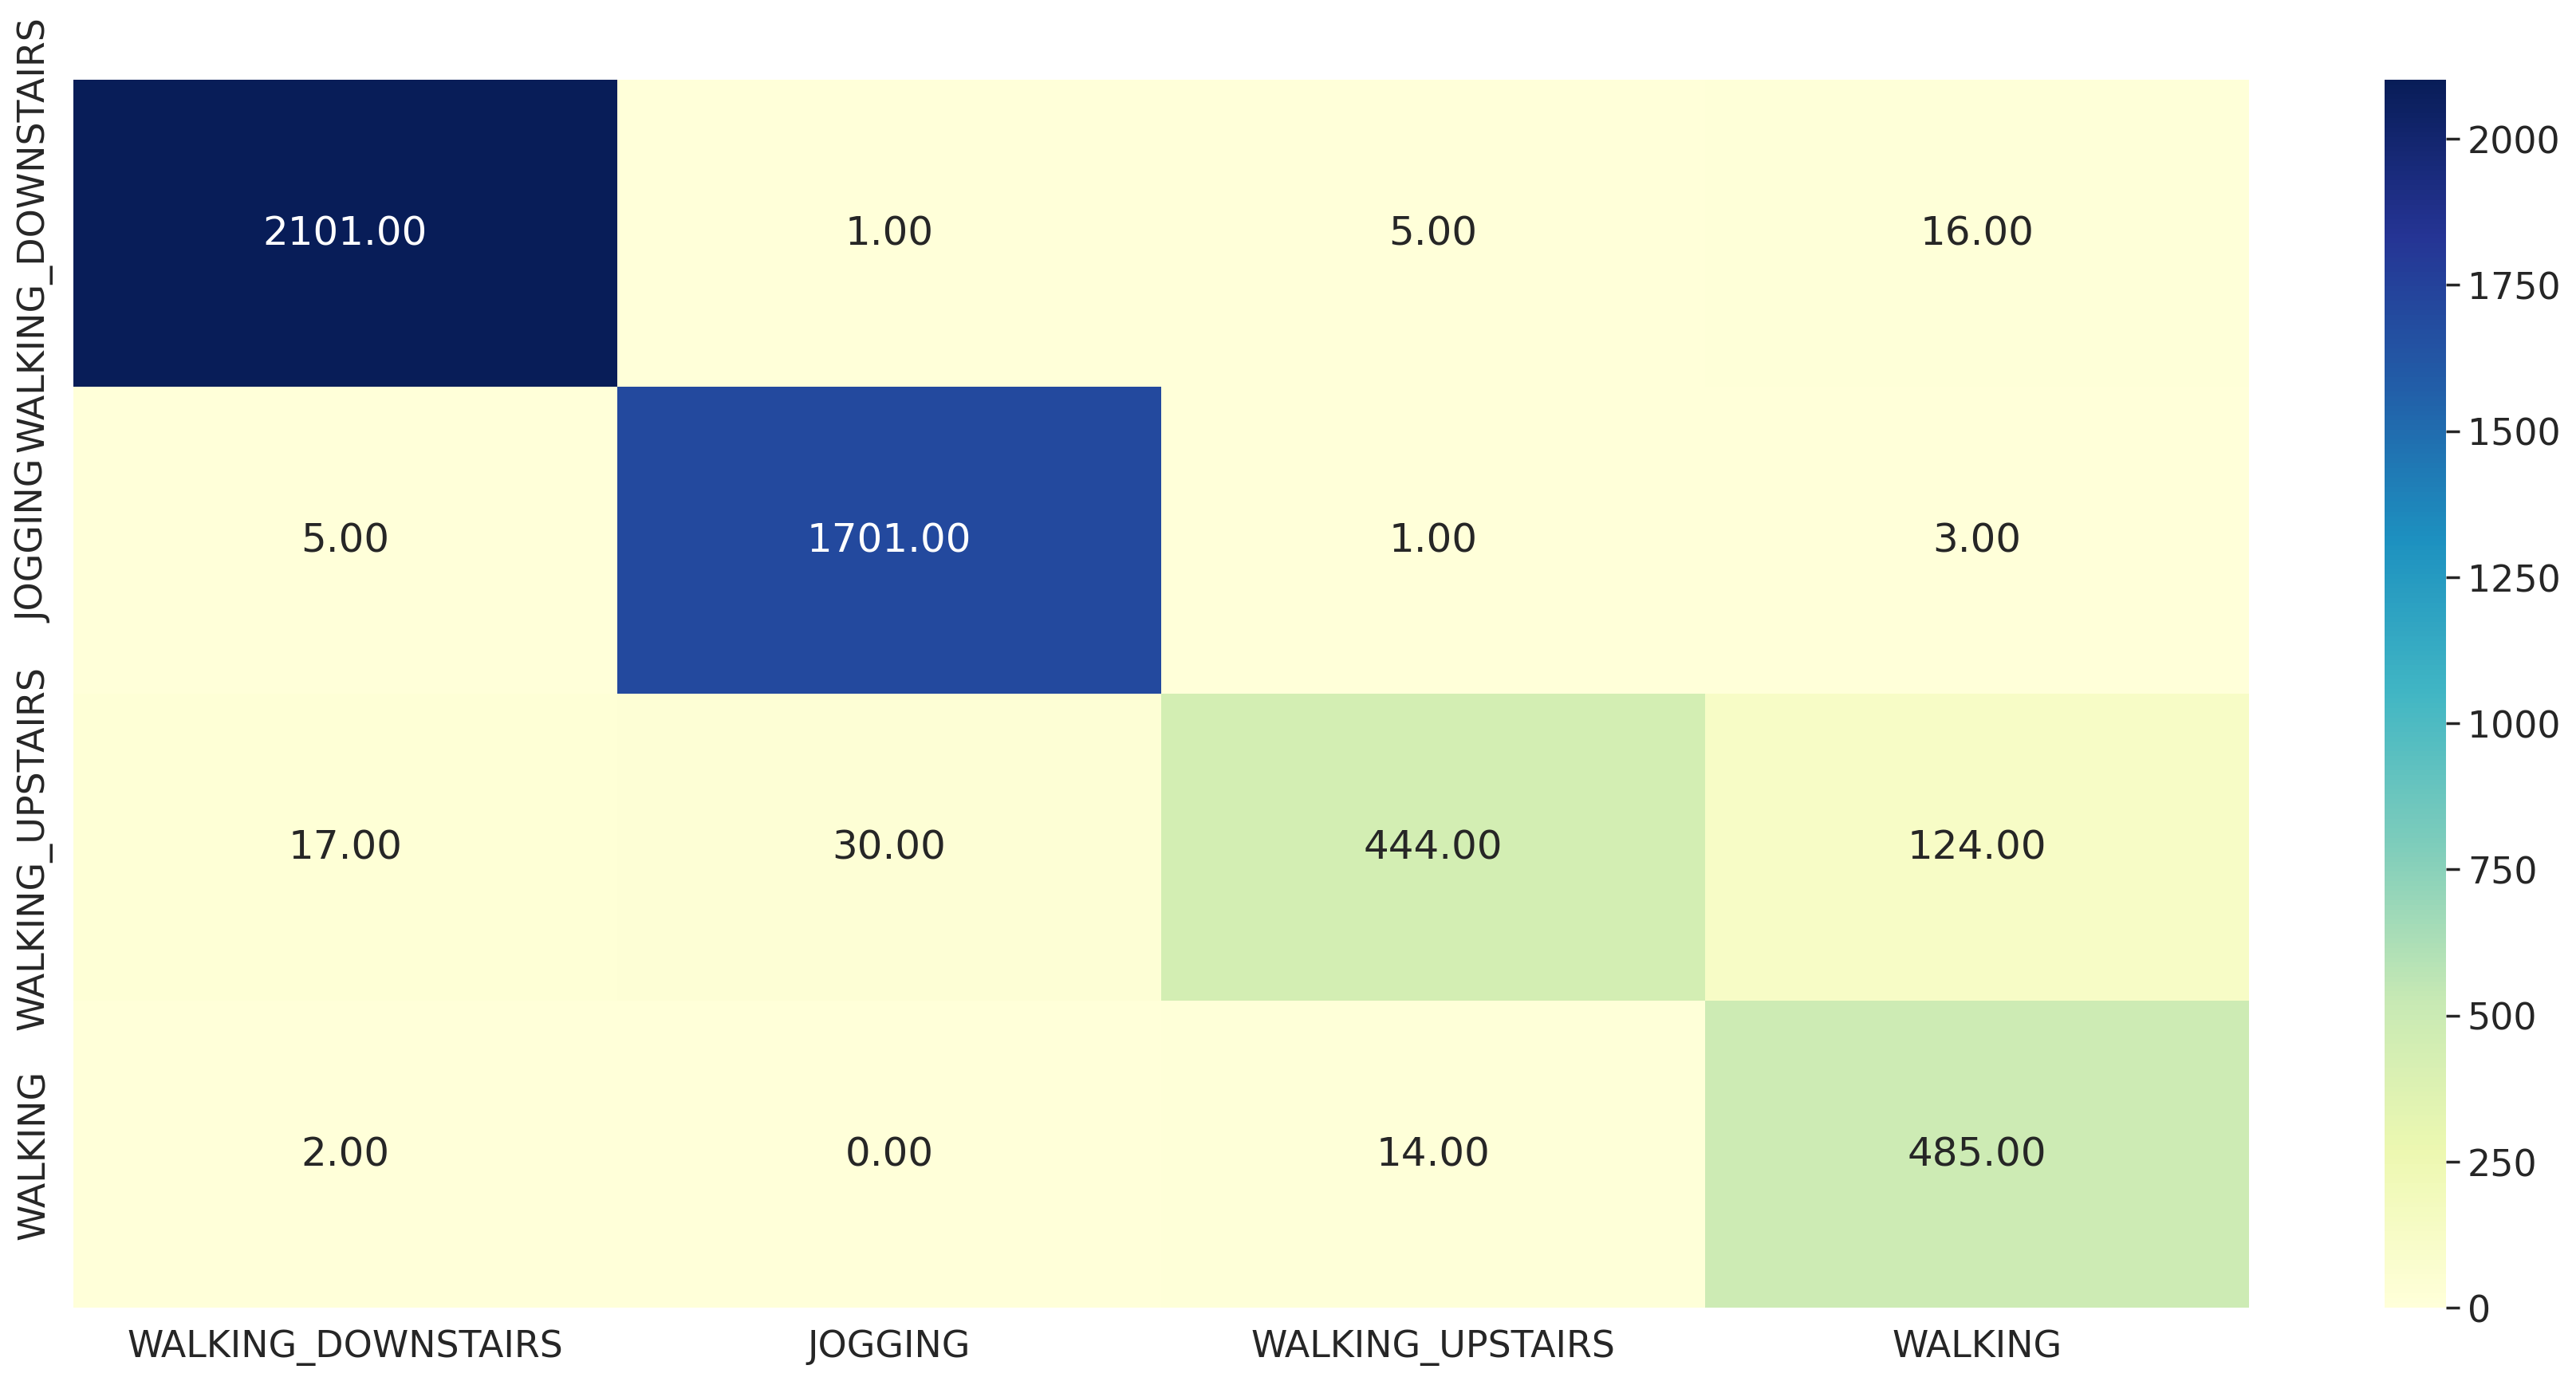

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 46, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 1472)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 24s 149ms/step - loss: 0.5834 - accuracy: 0.7733 - val_loss: 0.3174 - val_accuracy: 0.8740
Epoch 2/10
124/124 [==============================] - 16s 131ms/step - loss: 0.2864 - accuracy: 0.8844 - val_loss: 0.2421 - val_accuracy: 0.8977
Epoch 3/10
124/124 [==============================] - 17s 134ms/step - loss: 0.2012 - accuracy: 0.9228 - val_loss: 0.2071 - val_accuracy: 0.9207
Epoch 4/10
124/124 [==============================] - 17s 134ms/step - loss: 0.1494 - accuracy: 0.9479 - val_loss: 0.1627 - val_accuracy: 0.9465
Epoch 5/10
124/124 [==============================] - 16s 130ms/step - loss: 0.1122 - accuracy: 0.9611 - val_loss: 0.1453 - val_accuracy: 0.9518
Epoch 6/10
124/124 [==============================] - 17s 134ms/step - loss: 0.1032 - accuracy: 0.9644 - val_loss: 0.1387 - val_accuracy: 0.9475
Epoch 7/10
124/124 [==============================] - 19s 149ms/step - loss: 0.0865 - accuracy: 0.9697 - val_loss: 0.1182 - val_ac

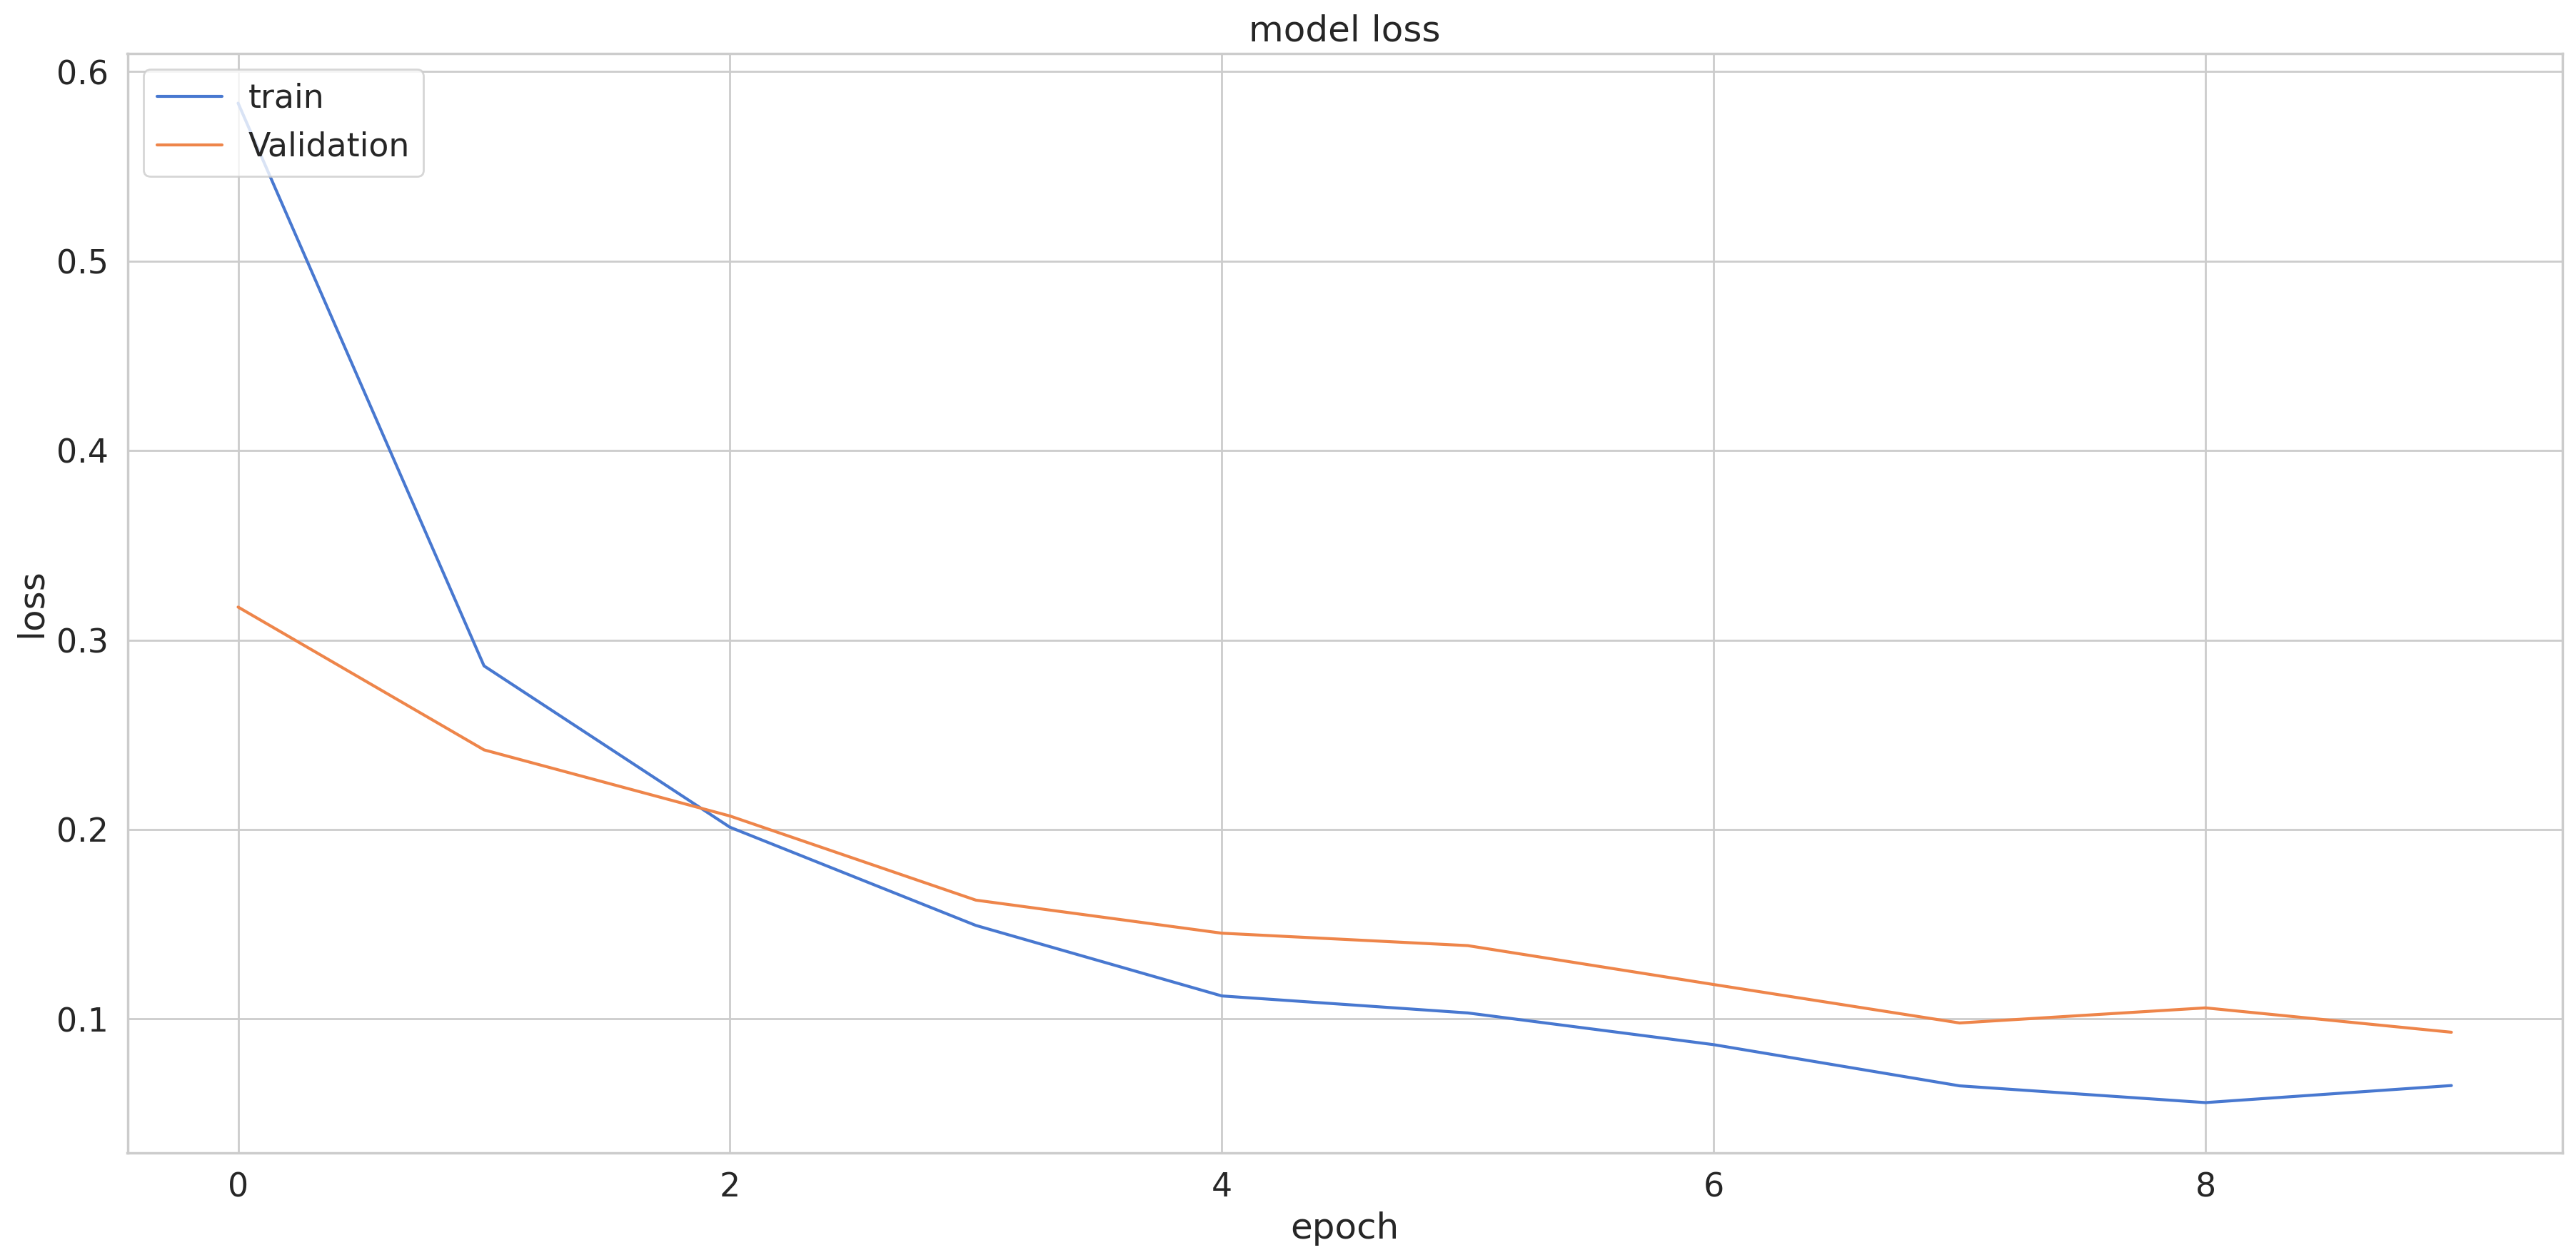

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

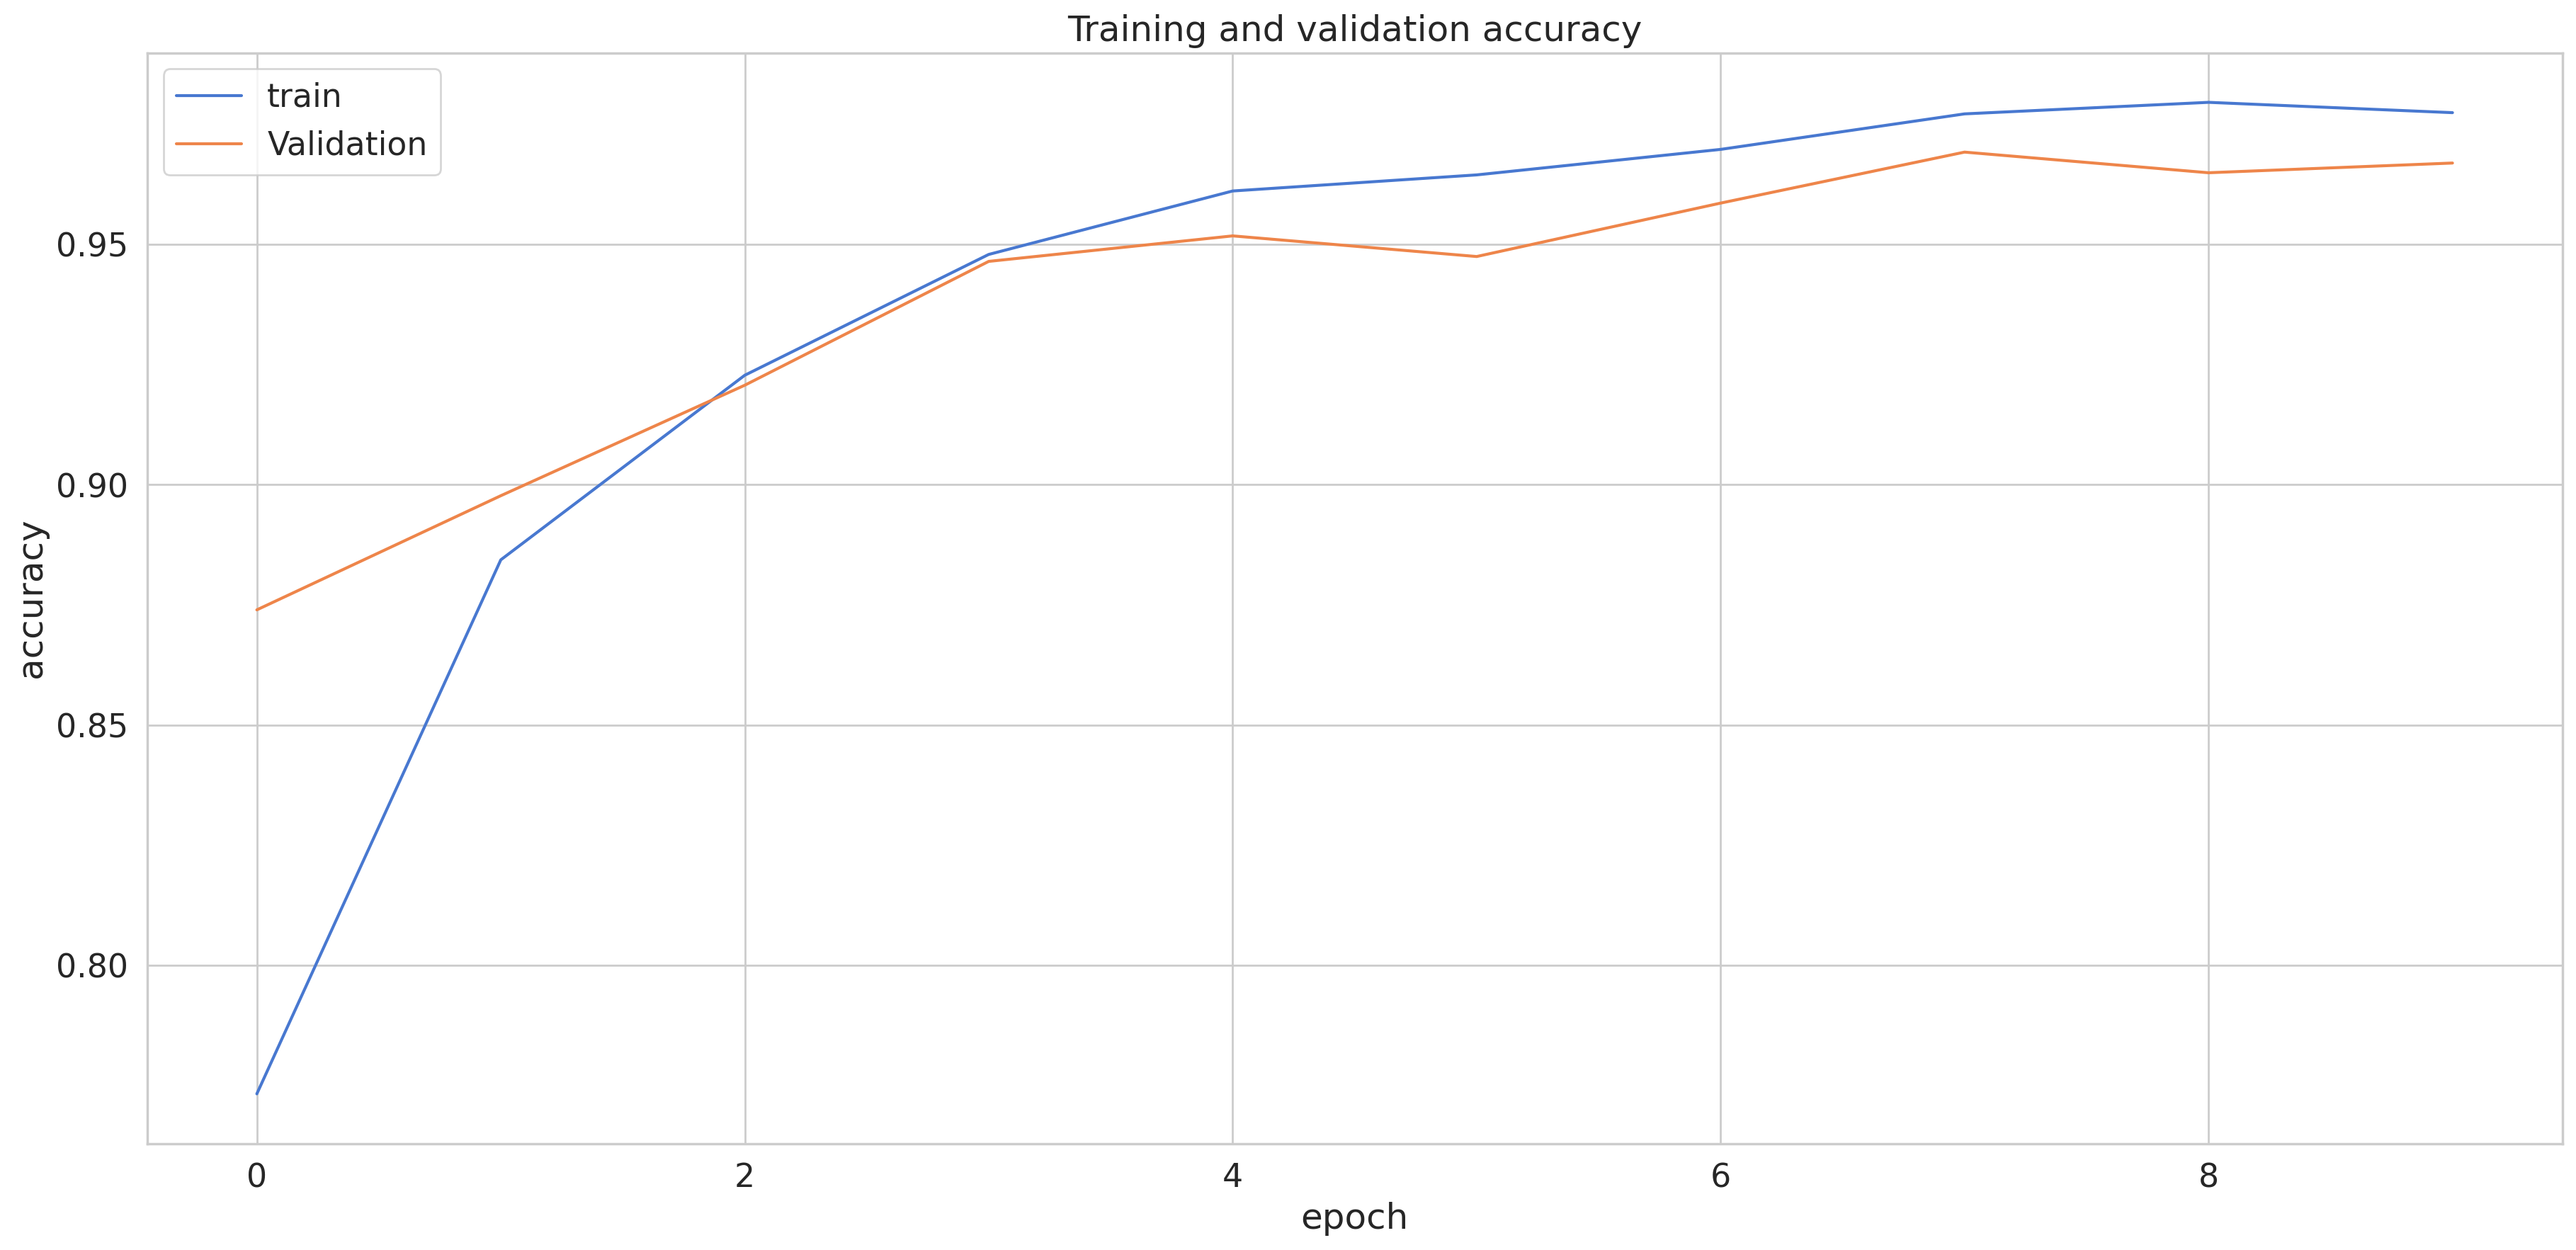

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 2s 10ms/step
f1_score =  0.9752019669690679
0.9751464942412609
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.88      0.95      0.91       615
           3       0.95      0.88      0.91       501

    accuracy                           0.98      4949
   macro avg       0.96      0.95      0.95      4949
weighted avg       0.98      0.98      0.98      4949



<Axes: >

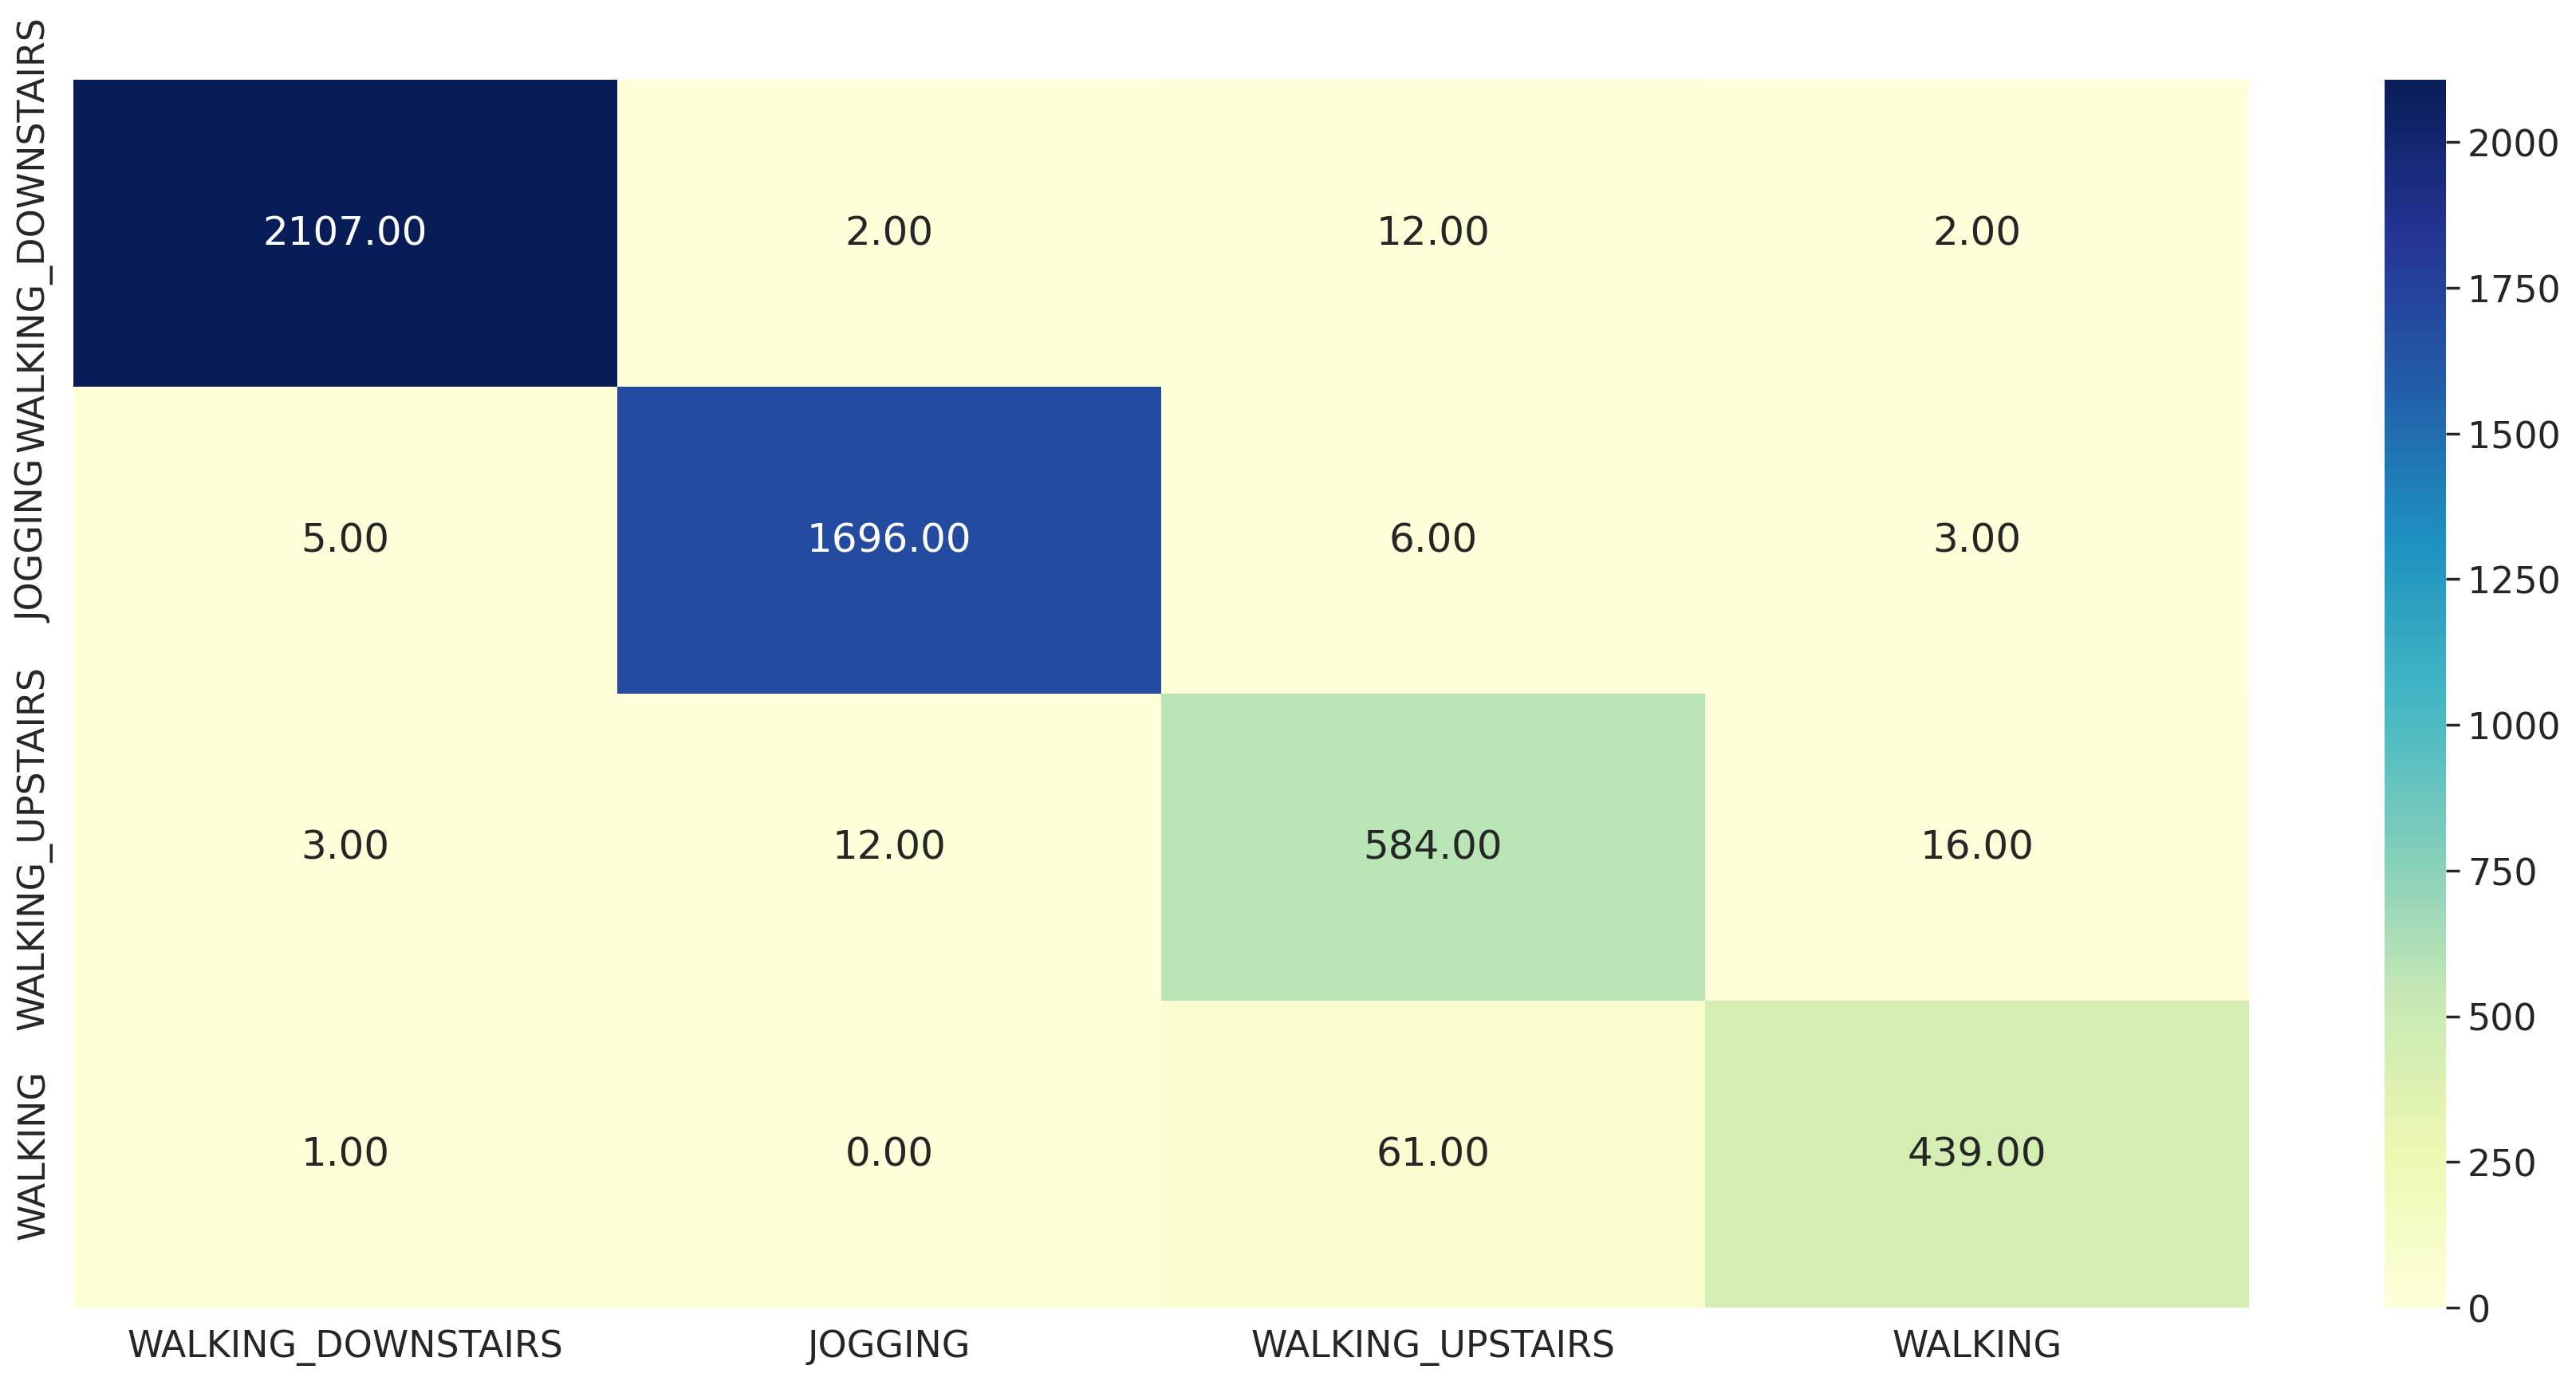

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM2

In [ ]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, None, 48, 64)      640       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 46, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, None, 1472)       

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 28s 155ms/step - loss: 0.6288 - accuracy: 0.7550 - val_loss: 0.3338 - val_accuracy: 0.8631
Epoch 2/10
124/124 [==============================] - 20s 160ms/step - loss: 0.2976 - accuracy: 0.8729 - val_loss: 0.2371 - val_accuracy: 0.8969
Epoch 3/10
124/124 [==============================] - 18s 144ms/step - loss: 0.2142 - accuracy: 0.9142 - val_loss: 0.1731 - val_accuracy: 0.9358
Epoch 4/10
124/124 [==============================] - 18s 145ms/step - loss: 0.1494 - accuracy: 0.9460 - val_loss: 0.1461 - val_accuracy: 0.9475
Epoch 5/10
124/124 [==============================] - 20s 164ms/step - loss: 0.1262 - accuracy: 0.9568 - val_loss: 0.1176 - val_accuracy: 0.9578
Epoch 6/10
124/124 [==============================] - 18s 144ms/step - loss: 0.0994 - accuracy: 0.9649 - val_loss: 0.1399 - val_accuracy: 0.9530
Epoch 7/10
124/124 [==============================] - 19s 154ms/step - loss: 0.0823 - accuracy: 0.9725 - val_loss: 0.1129 - val_ac

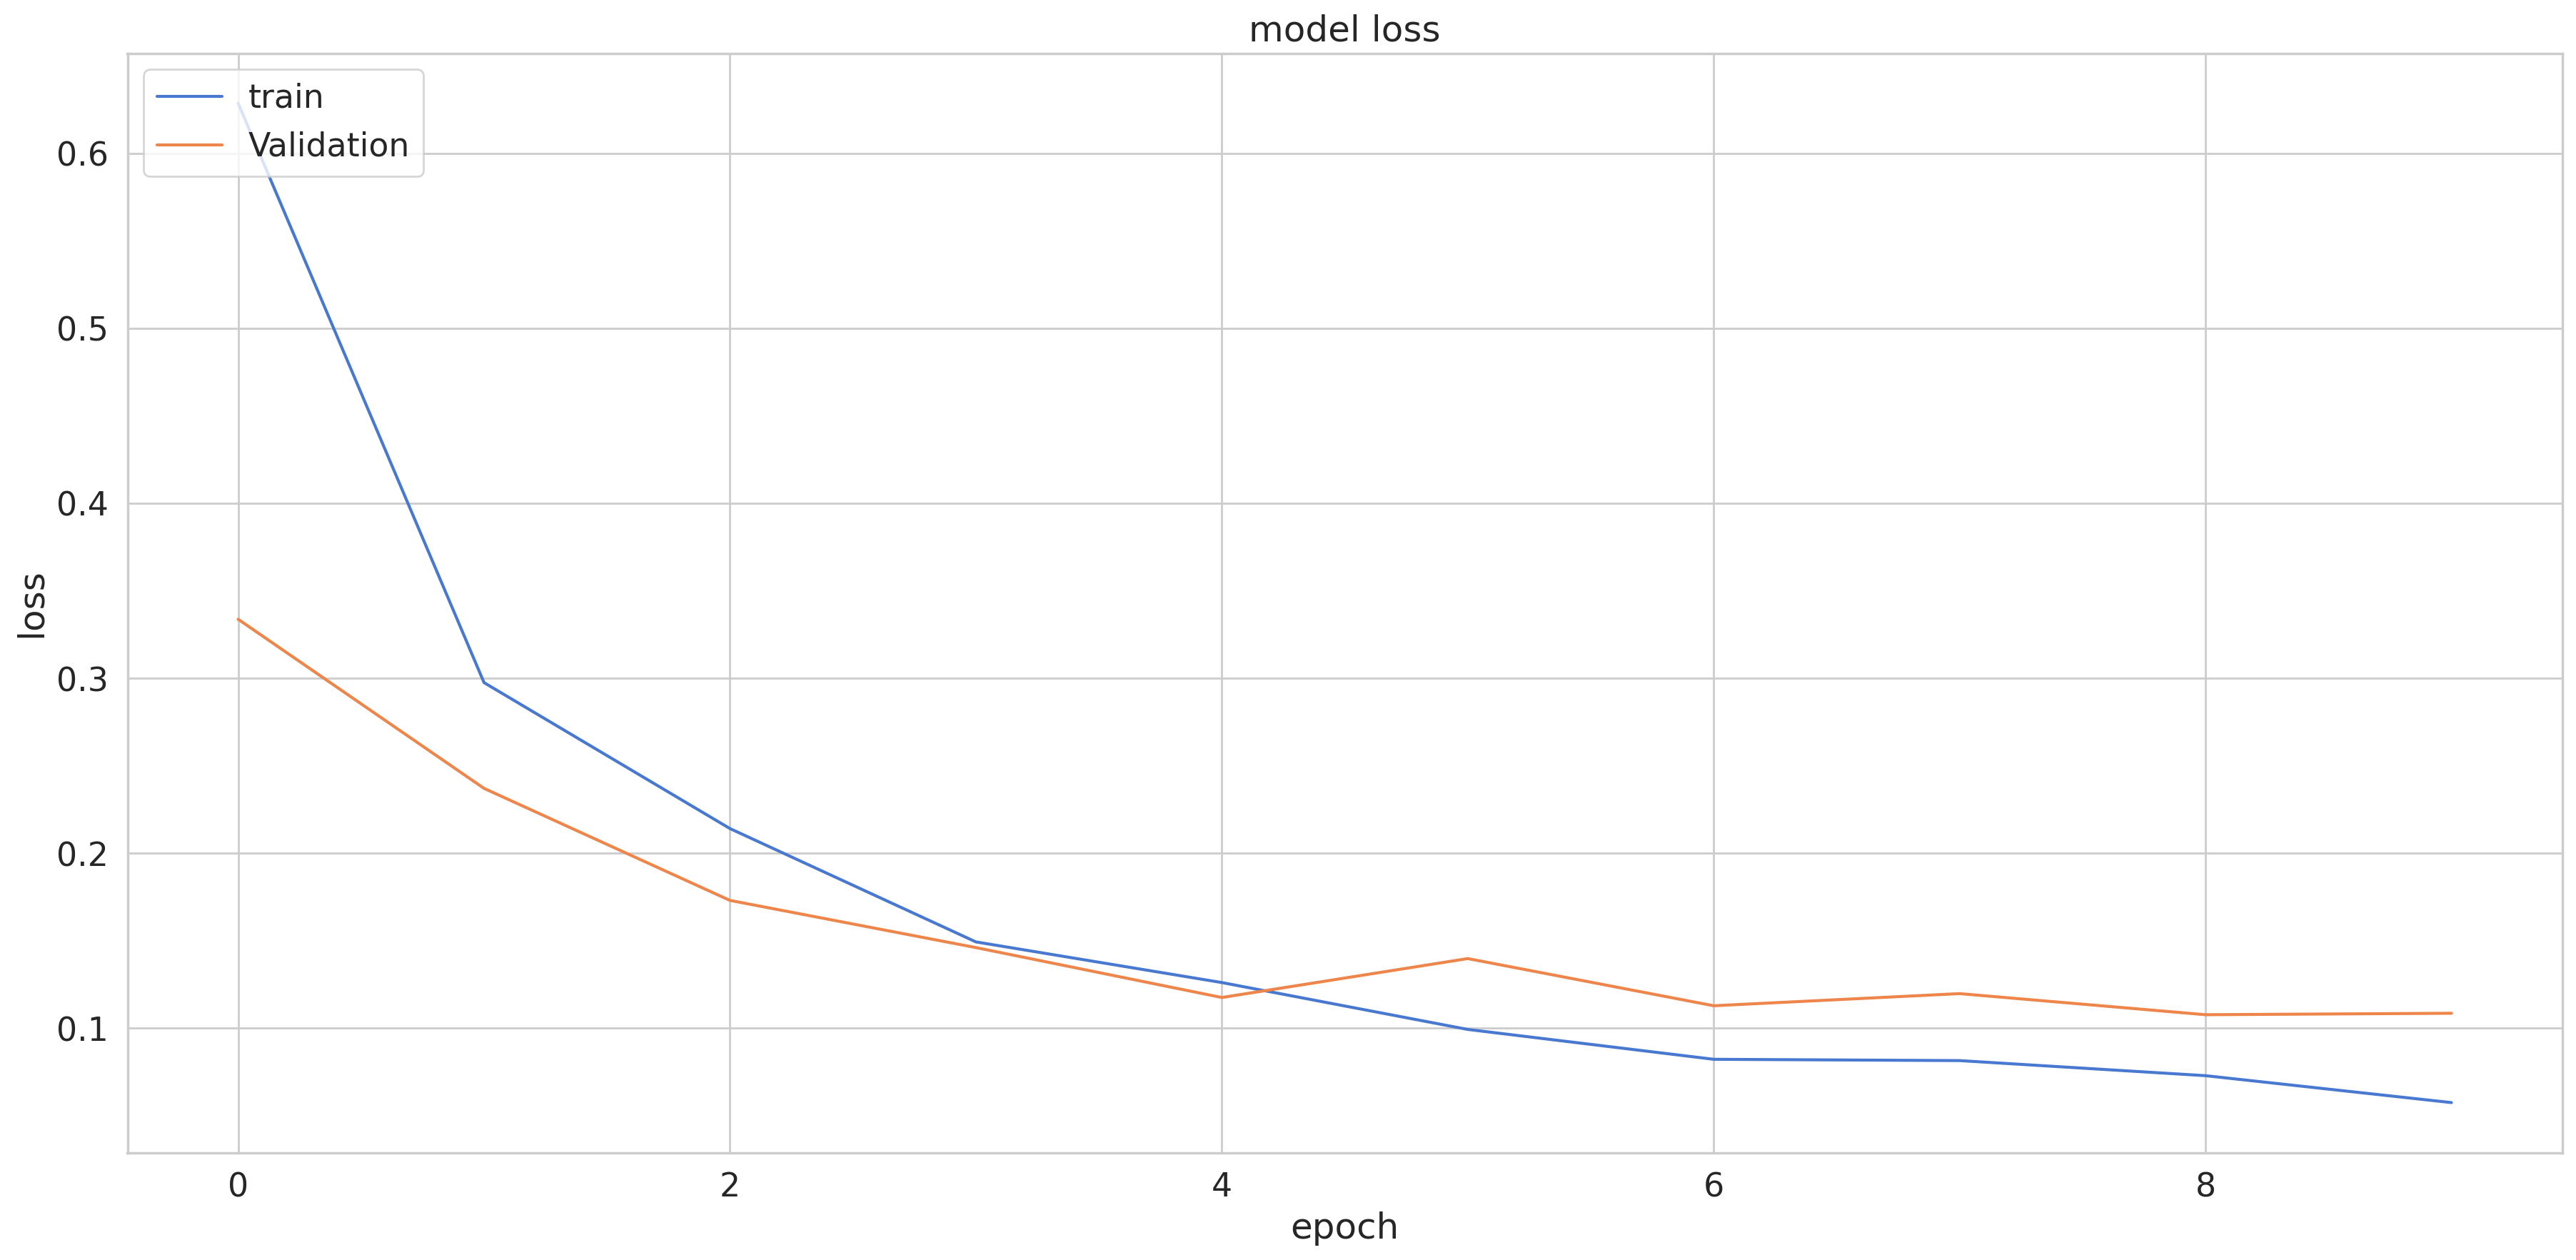

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

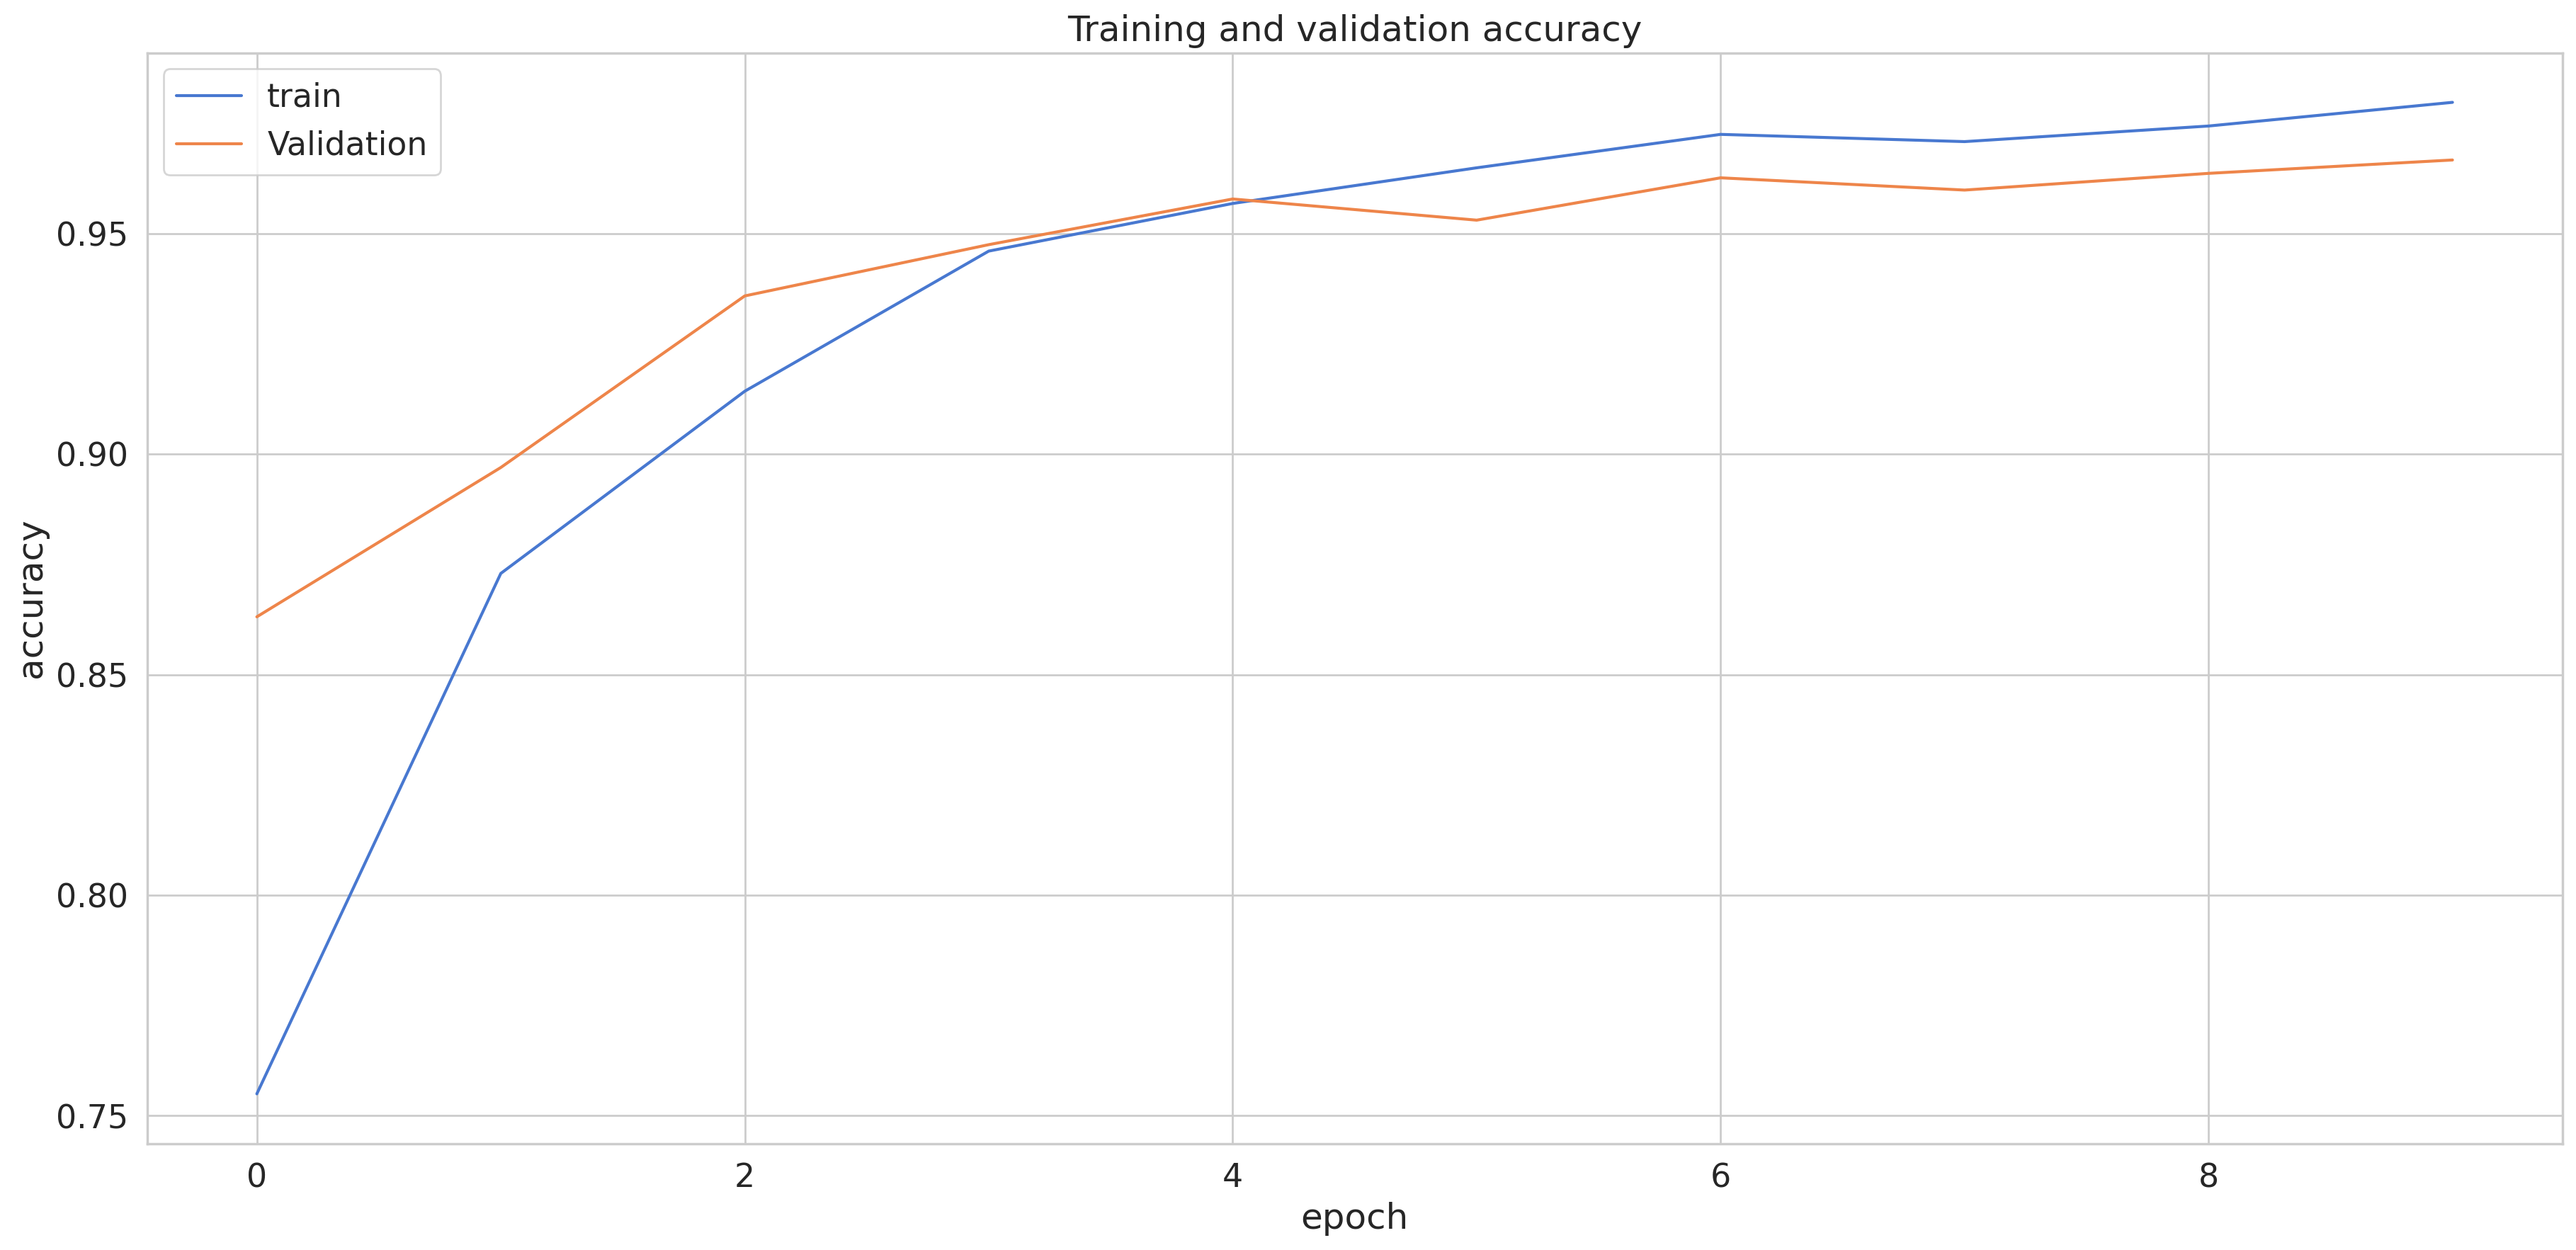

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 4s 18ms/step
f1_score =  0.9739753233825611
0.9739341281066882
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2123
           1       0.99      1.00      0.99      1710
           2       0.93      0.89      0.91       615
           3       0.88      0.94      0.91       501

    accuracy                           0.97      4949
   macro avg       0.95      0.95      0.95      4949
weighted avg       0.97      0.97      0.97      4949



<Axes: >

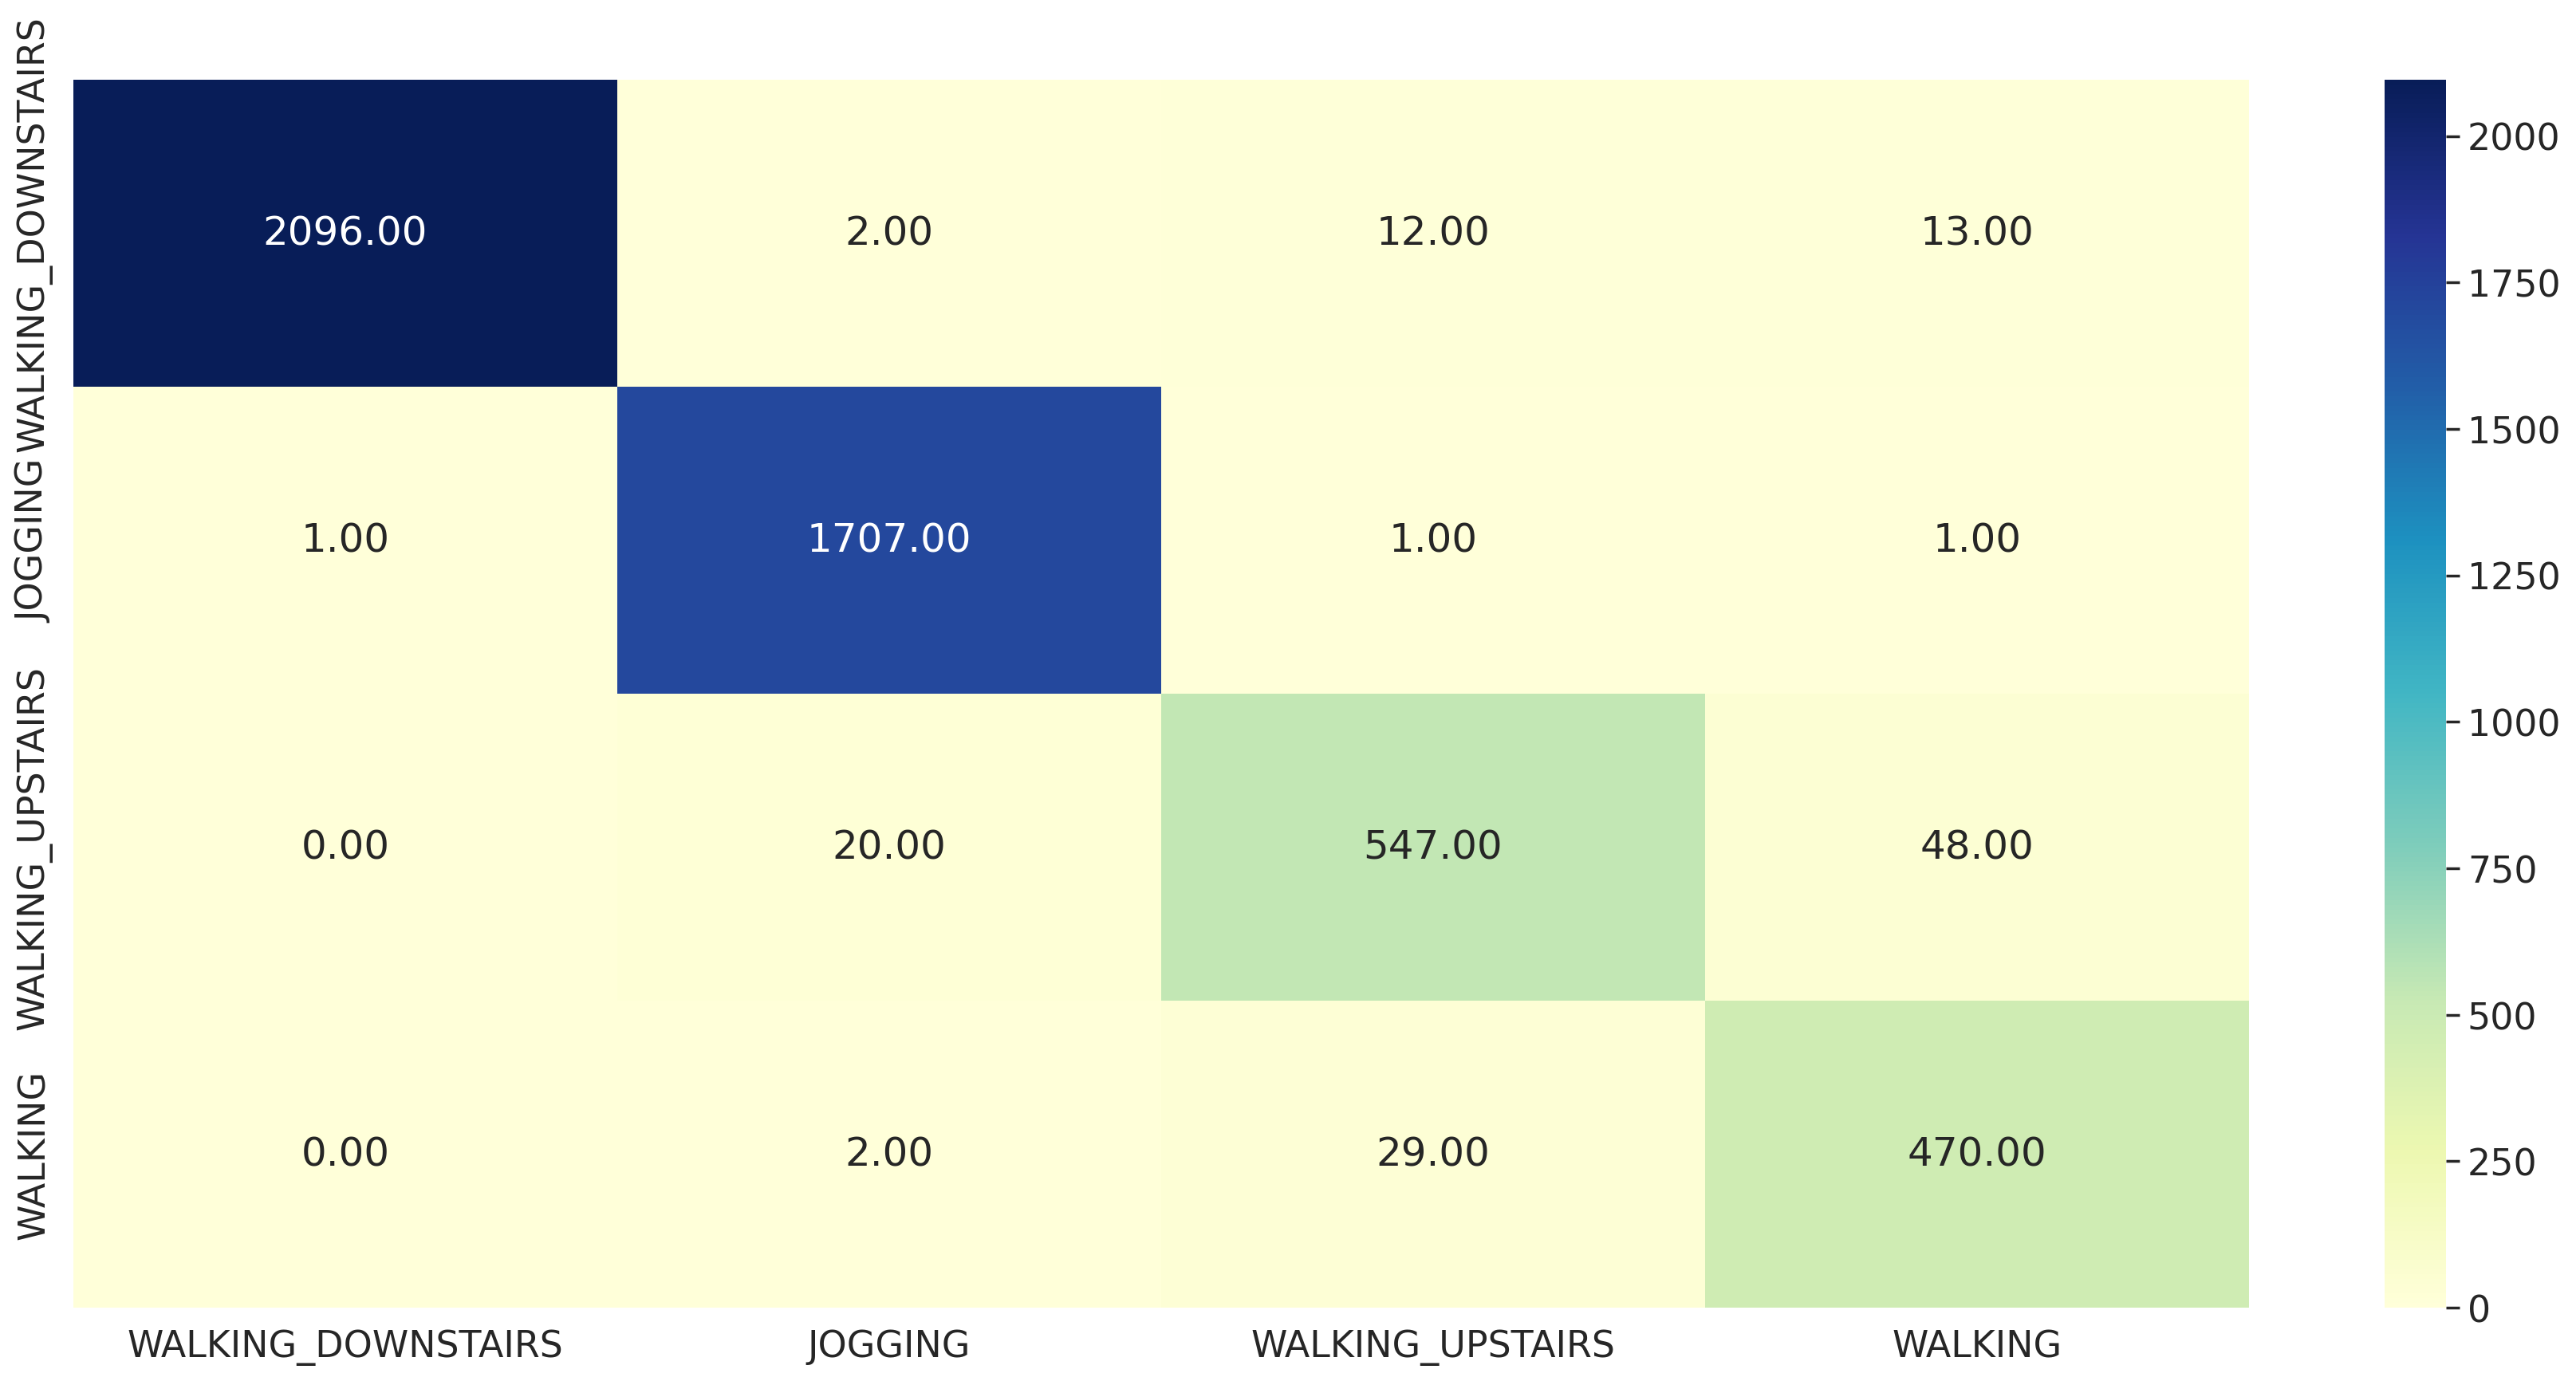

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')